## 1. Setup i Import Bibliotek

## 0. Automatyczna Instalacja Brakujących Bibliotek

In [62]:
import subprocess
import sys

def install_package(package_name, import_name=None):
    """
    Sprawdza czy biblioteka jest zainstalowana, jeśli nie - instaluje ją.
    
    Args:
        package_name: nazwa pakietu do instalacji (np. 'xgboost')
        import_name: nazwa do importu (jeśli inna niż package_name, np. 'sklearn' dla 'scikit-learn')
    """
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        print(f"✅ {package_name} już zainstalowany")
        return True
    except ImportError:
        print(f"⚠️  {package_name} nie znaleziony. Instaluję...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "-q"])
            print(f"✅ {package_name} zainstalowany pomyślnie")
            return True
        except subprocess.CalledProcessError:
            print(f"❌ Błąd instalacji {package_name}")
            return False

# Lista wymaganych bibliotek
required_packages = [
    ('xgboost', 'xgboost'),
    ('imbalanced-learn', 'imblearn'),
    ('shap', 'shap'),
    ('scikit-learn', 'sklearn'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn')
]

print("="*70)
print("🔍 SPRAWDZANIE I INSTALACJA WYMAGANYCH BIBLIOTEK")
print("="*70)

all_installed = True
for package_name, import_name in required_packages:
    if not install_package(package_name, import_name):
        all_installed = False

print("\n" + "="*70)
if all_installed:
    print("✅ Wszystkie biblioteki gotowe do użycia!")
else:
    print("⚠️  Niektóre biblioteki nie zostały zainstalowane - sprawdź błędy powyżej")
print("="*70)

🔍 SPRAWDZANIE I INSTALACJA WYMAGANYCH BIBLIOTEK
✅ xgboost już zainstalowany
✅ imbalanced-learn już zainstalowany
✅ shap już zainstalowany
✅ scikit-learn już zainstalowany
✅ matplotlib już zainstalowany
✅ seaborn już zainstalowany

✅ Wszystkie biblioteki gotowe do użycia!


In [63]:
# Podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

# Scipy
from scipy.stats.mstats import winsorize

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  xgboost not installed - uruchom komórkę instalacyjną powyżej")
    XGBOOST_AVAILABLE = False

# imbalanced-learn (SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    SMOTE_AVAILABLE = True
except ImportError:
    print("⚠️  imbalanced-learn not installed - uruchom komórkę instalacyjną powyżej")
    SMOTE_AVAILABLE = False

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("⚠️  shap not installed - uruchom komórkę instalacyjną powyżej")
    SHAP_AVAILABLE = False

# Konfiguracja
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

print("\n✅ Biblioteki załadowane")
print(f"   XGBoost: {XGBOOST_AVAILABLE}")
print(f"   SMOTE (imbalanced-learn): {SMOTE_AVAILABLE}")
print(f"   SHAP: {SHAP_AVAILABLE}")


✅ Biblioteki załadowane
   XGBoost: True
   SMOTE (imbalanced-learn): True
   SHAP: True


## 2. Wczytanie i Podział Danych

In [64]:
# Wczytanie danych
df = pd.read_csv("zbior_10.csv")
print(f"Wymiary: {df.shape}")
print(f"Klasa pozytywna: {100*df['default'].sum()/len(df):.2f}%")

# Podział train/test
df_train, df_test = train_test_split(df, test_size=0.3, random_state=1, stratify=df['default'])
X_train = df_train.drop("default", axis=1)
y_train = df_train["default"]
X_test = df_test.drop("default", axis=1)
y_test = df_test["default"]

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

Wymiary: (3000, 220)
Klasa pozytywna: 6.10%

Train: (2100, 219), Test: (900, 219)


## 3. Klasy Pipeline'ów

### 3.1 Funkcje Pomocnicze

In [65]:
def identify_columns_to_drop(X, missing_threshold=0.0, zero_threshold=0.90, keep_sparse_as_binary=True):
    """
    Identyfikuje kolumny do usunięcia lub transformacji binarnej.
    
    Zwraca:
        dict: Słownik z kategoryzacją kolumn
    """
    result = {
        'missing': [],
        'categorical': [],
        'low_variance': [],
        'constant': [],
        'sparse_to_binary': [],
        'to_drop': []
    }
    
    # Braki danych
    result['missing'] = X.columns[X.isna().sum() > missing_threshold * len(X)].tolist()
    
    # Kategoryczne
    result['categorical'] = X.select_dtypes(include=['object']).columns.tolist()
    
    # Numeryczne
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col in result['missing'] or col in result['categorical']:
            continue
            
        # Stałe
        if X[col].nunique() == 1:
            result['constant'].append(col)
            continue
        
        # Sparse (>90% zer)
        zero_pct = (X[col] == 0).sum() / len(X)
        if zero_pct > zero_threshold:
            if keep_sparse_as_binary:
                result['sparse_to_binary'].append(col)
            else:
                result['to_drop'].append(col)
            continue
        
        # Niska wariancja
        if X[col].nunique() <= 2:
            result['low_variance'].append(col)
    
    # Suma kolumn do usunięcia
    result['to_drop'].extend(result['missing'])
    result['to_drop'].extend(result['categorical'])
    result['to_drop'].extend(result['constant'])
    result['to_drop'].extend(result['low_variance'])
    
    return result


def calculate_winsorization_limits(X, lower_pct=0.01, upper_pct=0.99):
    """
    Oblicza limity winsoryzacji dla każdej kolumny.
    
    Parametry:
        X: DataFrame z danymi
        lower_pct, upper_pct: percentyle do obcinania
    
    Zwraca:
        dict: Słownik z limitami dla każdej kolumny
    """
    limits = {}
    
    for col in X.columns:
        limits[col] = {
            'lower': X[col].quantile(lower_pct),
            'upper': X[col].quantile(upper_pct)
        }
    
    return limits

print("✅ Funkcja winsoryzacji zdefiniowana")

✅ Funkcja winsoryzacji zdefiniowana


### 3.2 InterpretableColumnTransformer

In [66]:
class InterpretableColumnTransformer:
    """
    Transformer dla pojedynczej kolumny z odwracalnymi transformacjami.
    """
    
    def __init__(self, column_name):
        self.column_name = column_name
        self.method = None
        self.transformer = None
        self.scaler = StandardScaler()
        self.original_min = None
        self.original_max = None
        
    def fit(self, X, y=None):
        """
        Dopasowuje najlepszą transformację dla kolumny.
        """
        data = X.copy()
        self.original_min = data.min()
        self.original_max = data.max()
        
        # Standardowa standardyzacja jako fallback
        self.method = 'standard'
        self.scaler.fit(data.values.reshape(-1, 1))
        best_skew = np.abs(self.scaler.transform(data.values.reshape(-1, 1)).flatten()).mean()
        
        # Próbuj Box-Cox (wymaga wartości > 0)
        if (data > 0).all():
            try:
                transformer = PowerTransformer(method='box-cox', standardize=False)
                transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
                skew = np.abs(pd.Series(transformed).skew())
                if skew < best_skew:
                    self.method = 'box-cox'
                    self.transformer = transformer
                    self.scaler.fit(transformed.reshape(-1, 1))
                    best_skew = skew
            except:
                pass
        
        # Próbuj Yeo-Johnson
        try:
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
            skew = np.abs(pd.Series(transformed).skew())
            if skew < best_skew:
                self.method = 'yeo-johnson'
                self.transformer = transformer
                self.scaler.fit(transformed.reshape(-1, 1))
                best_skew = skew
        except:
            pass
        
        # Próbuj log1p
        if (data >= 0).all():
            try:
                transformed = np.log1p(data)
                skew = np.abs(transformed.skew())
                if skew < best_skew:
                    self.method = 'log1p'
                    self.transformer = None
                    self.scaler.fit(transformed.values.reshape(-1, 1))
            except:
                pass
        
        return self
    
    def transform(self, X):
        """
        Transformuje kolumnę.
        """
        data = X.copy()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.transform(data.values.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.log1p(data)
        
        # Standaryzacja
        std = self.scaler.scale_[0]
        if std > 1e-10:  # Zabezpieczenie przed dzieleniem przez 0
            data_transformed = self.scaler.transform(np.array(data).reshape(-1, 1)).flatten()
        else:
            data_transformed = np.zeros_like(data)
        
        return pd.Series(data_transformed, index=X.index)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Odwraca transformację.
        """
        data = self.scaler.inverse_transform(np.array(X).reshape(-1, 1)).flatten()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.inverse_transform(data.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.expm1(data)
        
        return pd.Series(data)

print("✅ InterpretableColumnTransformer zdefiniowany")

✅ InterpretableColumnTransformer zdefiniowany


### 3.3 Full Pipeline (InterpretablePreprocessingPipeline)

In [67]:
class InterpretablePreprocessingPipeline:
    """
    Pełny pipeline z transformacjami statystycznymi.
    """
    
    def __init__(self, correlation_threshold=0.8, keep_sparse_as_binary=True):
        self.correlation_threshold = correlation_threshold
        self.keep_sparse_as_binary = keep_sparse_as_binary
        self.columns_info = None
        self.winsorization_limits = None
        self.transformers = {}
        self.final_columns = None
        self.correlated_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Identyfikacja kolumn
        self.columns_info = identify_columns_to_drop(
            X_work, 
            keep_sparse_as_binary=self.keep_sparse_as_binary
        )
        
        # 2. Usunięcie problemowych kolumn
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        
        # 3. Winsoryzacja
        numeric_cols = [c for c in X_work.columns if c not in self.columns_info['sparse_to_binary']]
        self.winsorization_limits = calculate_winsorization_limits(X_work[numeric_cols])
        
        for col in numeric_cols:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 4. Usuń wysoko skorelowane
        corr_matrix = X_work[numeric_cols].corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        numeric_cols = [c for c in numeric_cols if c not in self.correlated_columns]
        
        # 5. Dopasuj transformery
        for col in numeric_cols:
            self.transformers[col] = InterpretableColumnTransformer(col)
            self.transformers[col].fit(X_work[col])
        
        self.final_columns = numeric_cols + self.columns_info['sparse_to_binary']
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in self.transformers.keys():
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Transformacje
        result = pd.DataFrame(index=X_work.index)
        for col in self.transformers.keys():
            result[col] = self.transformers[col].transform(X_work[col])
        
        # Binary dla sparse
        for col in self.columns_info['sparse_to_binary']:
            if col in X_work.columns:
                result[f"{col}_binary"] = (X_work[col] != 0).astype(int)
        
        return result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ InterpretablePreprocessingPipeline zdefiniowany")

✅ InterpretablePreprocessingPipeline zdefiniowany


### 3.4 Minimal Pipeline (MinimalPreprocessingPipeline)

In [68]:
class MinimalPreprocessingPipeline:
    """
    Minimalny pipeline - tylko winsoryzacja i standaryzacja.
    """
    
    def __init__(self, correlation_threshold=0.80, standardize=True):
        self.correlation_threshold = correlation_threshold
        self.standardize = standardize
        self.columns_to_drop = []
        self.correlated_columns = []
        self.winsorization_limits = None
        self.scaler = StandardScaler() if standardize else None
        self.final_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Usuń kategoryczne, NaN, stałe
        self.columns_to_drop = []
        self.columns_to_drop.extend(X_work.columns[X_work.isna().any()].tolist())
        self.columns_to_drop.extend(X_work.select_dtypes(include=['object']).columns.tolist())
        
        for col in X_work.select_dtypes(include=[np.number]).columns:
            if X_work[col].nunique() == 1:
                self.columns_to_drop.append(col)
        
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        
        # 2. Winsoryzacja
        self.winsorization_limits = calculate_winsorization_limits(X_work)
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 3. Usuń skorelowane
        corr_matrix = X_work.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        
        # 4. Standaryzacja
        if self.standardize:
            self.scaler.fit(X_work)
        
        self.final_columns = X_work.columns.tolist()
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Standaryzacja
        if self.standardize:
            X_transformed = self.scaler.transform(X_work)
            return pd.DataFrame(X_transformed, columns=self.final_columns, index=X_work.index)
        
        return X_work[self.final_columns]
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ MinimalPreprocessingPipeline zdefiniowany")

✅ MinimalPreprocessingPipeline zdefiniowany


---

# CZĘŚĆ 1: FULL PIPELINE

## 4. Full Pipeline - Preprocessing

In [69]:
# Inicjalizacja i dopasowanie pipeline
pipeline_full = InterpretablePreprocessingPipeline(
    correlation_threshold=0.95,
    keep_sparse_as_binary=True
)

print("Dopasowywanie Full Pipeline...")
X_train_full = pipeline_full.fit_transform(X_train, y_train)
X_test_full = pipeline_full.transform(X_test)

print(f"\n✅ Full Pipeline gotowy")
print(f"   Train: {X_train_full.shape}")
print(f"   Test: {X_test_full.shape}")
print(f"   NaN: {X_train_full.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_full.values).sum()}")

Dopasowywanie Full Pipeline...

✅ Full Pipeline gotowy
   Train: (2100, 157)
   Test: (900, 157)
   NaN: 0
   Inf: 0

✅ Full Pipeline gotowy
   Train: (2100, 157)
   Test: (900, 157)
   NaN: 0
   Inf: 0


## 5. Full Pipeline - Trening Modeli

In [70]:
# Słownik do przechowywania wyników
results_full = {}

### 5.1 Logistic Regression (Full)

In [71]:
print("="*70)
print("LOGISTIC REGRESSION - FULL PIPELINE")
print("="*70)

lr_full = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_full.fit(X_train_full, y_train)

y_pred_lr_full = lr_full.predict(X_test_full)
y_proba_lr_full = lr_full.predict_proba(X_test_full)[:, 1]

results_full['LR'] = {
    'model': lr_full,
    'accuracy': accuracy_score(y_test, y_pred_lr_full),
    'precision': precision_score(y_test, y_pred_lr_full),
    'recall': recall_score(y_test, y_pred_lr_full),
    'f1': f1_score(y_test, y_pred_lr_full),
    'auc': roc_auc_score(y_test, y_proba_lr_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['LR']['accuracy']:.4f}")
print(f"  Precision: {results_full['LR']['precision']:.4f}")
print(f"  Recall:    {results_full['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_full['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['LR']['auc']:.4f}")

LOGISTIC REGRESSION - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.7478
  Precision: 0.1161
  Recall:    0.4727
  F1-Score:  0.1864
  ROC-AUC:   0.6866


### 5.2 Decision Tree (Full)

In [72]:
print("="*70)
print("DECISION TREE - FULL PIPELINE")
print("="*70)

dt_full = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_full.fit(X_train_full, y_train)

y_pred_dt_full = dt_full.predict(X_test_full)
y_proba_dt_full = dt_full.predict_proba(X_test_full)[:, 1]

results_full['DT'] = {
    'model': dt_full,
    'accuracy': accuracy_score(y_test, y_pred_dt_full),
    'precision': precision_score(y_test, y_pred_dt_full),
    'recall': recall_score(y_test, y_pred_dt_full),
    'f1': f1_score(y_test, y_pred_dt_full),
    'auc': roc_auc_score(y_test, y_proba_dt_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['DT']['accuracy']:.4f}")
print(f"  Precision: {results_full['DT']['precision']:.4f}")
print(f"  Recall:    {results_full['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_full['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['DT']['auc']:.4f}")

DECISION TREE - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.5911
  Precision: 0.0997
  Recall:    0.7091
  F1-Score:  0.1749
  ROC-AUC:   0.6725

📊 Wyniki:
  Accuracy:  0.5911
  Precision: 0.0997
  Recall:    0.7091
  F1-Score:  0.1749
  ROC-AUC:   0.6725


### 5.3 Naive Bayes (Full)

In [73]:
print("="*70)
print("NAIVE BAYES - FULL PIPELINE")
print("="*70)

nb_full = GaussianNB()
nb_full.fit(X_train_full, y_train)

y_pred_nb_full = nb_full.predict(X_test_full)
y_proba_nb_full = nb_full.predict_proba(X_test_full)[:, 1]

results_full['NB'] = {
    'model': nb_full,
    'accuracy': accuracy_score(y_test, y_pred_nb_full),
    'precision': precision_score(y_test, y_pred_nb_full),
    'recall': recall_score(y_test, y_pred_nb_full),
    'f1': f1_score(y_test, y_pred_nb_full),
    'auc': roc_auc_score(y_test, y_proba_nb_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full['NB']['accuracy']:.4f}")
print(f"  Precision: {results_full['NB']['precision']:.4f}")
print(f"  Recall:    {results_full['NB']['recall']:.4f}")
print(f"  F1-Score:  {results_full['NB']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['NB']['auc']:.4f}")

NAIVE BAYES - FULL PIPELINE

📊 Wyniki:
  Accuracy:  0.2789
  Precision: 0.0658
  Recall:    0.8182
  F1-Score:  0.1218
  ROC-AUC:   0.5338


---

# CZĘŚĆ 1.5: MODELE BLACK BOX (FULL PIPELINE)

## 5.5 Modele Black Box - Słownik Wyników

In [74]:
# Słownik do przechowywania wyników modeli black box (Full Pipeline)
results_blackbox_full = {}

### 5.5.1 Random Forest (Black Box - Full)

In [75]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (FULL PIPELINE)")
print("="*70)

rf_blackbox_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox_full.fit(X_train_full, y_train)

y_pred_rf_blackbox_full = rf_blackbox_full.predict(X_test_full)
y_proba_rf_blackbox_full = rf_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['RF'] = {
    'model': rf_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_rf_blackbox_full),
    'precision': precision_score(y_test, y_pred_rf_blackbox_full),
    'recall': recall_score(y_test, y_pred_rf_blackbox_full),
    'f1': f1_score(y_test, y_pred_rf_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_rf_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['RF']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['RF']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['RF']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['RF']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['RF']['auc']:.4f}")

RANDOM FOREST - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8478
  Precision: 0.1639
  Recall:    0.3636
  F1-Score:  0.2260
  ROC-AUC:   0.7707

📊 Wyniki:
  Accuracy:  0.8478
  Precision: 0.1639
  Recall:    0.3636
  F1-Score:  0.2260
  ROC-AUC:   0.7707


### 5.5.2 XGBoost (Black Box - Full)

In [76]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (FULL PIPELINE)")
    print("="*70)
    
    xgb_blackbox_full = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox_full.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox_full.fit(X_train_full, y_train)
    
    y_pred_xgb_blackbox_full = xgb_blackbox_full.predict(X_test_full)
    y_proba_xgb_blackbox_full = xgb_blackbox_full.predict_proba(X_test_full)[:, 1]
    
    results_blackbox_full['XGB'] = {
        'model': xgb_blackbox_full,
        'accuracy': accuracy_score(y_test, y_pred_xgb_blackbox_full),
        'precision': precision_score(y_test, y_pred_xgb_blackbox_full),
        'recall': recall_score(y_test, y_pred_xgb_blackbox_full),
        'f1': f1_score(y_test, y_pred_xgb_blackbox_full),
        'auc': roc_auc_score(y_test, y_proba_xgb_blackbox_full)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  Accuracy:  {results_blackbox_full['XGB']['accuracy']:.4f}")
    print(f"  Precision: {results_blackbox_full['XGB']['precision']:.4f}")
    print(f"  Recall:    {results_blackbox_full['XGB']['recall']:.4f}")
    print(f"  F1-Score:  {results_blackbox_full['XGB']['f1']:.4f}")
    print(f"  ROC-AUC:   {results_blackbox_full['XGB']['auc']:.4f}")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9211
  Precision: 0.1923
  Recall:    0.0909
  F1-Score:  0.1235
  ROC-AUC:   0.7419

📊 Wyniki:
  Accuracy:  0.9211
  Precision: 0.1923
  Recall:    0.0909
  F1-Score:  0.1235
  ROC-AUC:   0.7419


### 5.5.3 SVM (Black Box - Full)

In [77]:
print("="*70)
print("SVM - BLACK BOX (FULL PIPELINE)")
print("="*70)

svm_blackbox_full = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox_full.fit(X_train_full, y_train)

y_pred_svm_blackbox_full = svm_blackbox_full.predict(X_test_full)
y_proba_svm_blackbox_full = svm_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['SVM'] = {
    'model': svm_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_svm_blackbox_full),
    'precision': precision_score(y_test, y_pred_svm_blackbox_full),
    'recall': recall_score(y_test, y_pred_svm_blackbox_full),
    'f1': f1_score(y_test, y_pred_svm_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_svm_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['SVM']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['SVM']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['SVM']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['SVM']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['SVM']['auc']:.4f}")

SVM - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8156
  Precision: 0.1325
  Recall:    0.3636
  F1-Score:  0.1942
  ROC-AUC:   0.6944

📊 Wyniki:
  Accuracy:  0.8156
  Precision: 0.1325
  Recall:    0.3636
  F1-Score:  0.1942
  ROC-AUC:   0.6944


### 5.5.4 Neural Network (Black Box - Full)

In [78]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)")
print("="*70)

mlp_blackbox_full = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox_full.fit(X_train_full, y_train)

y_pred_mlp_blackbox_full = mlp_blackbox_full.predict(X_test_full)
y_proba_mlp_blackbox_full = mlp_blackbox_full.predict_proba(X_test_full)[:, 1]

results_blackbox_full['Neural Network'] = {
    'model': mlp_blackbox_full,
    'accuracy': accuracy_score(y_test, y_pred_mlp_blackbox_full),
    'precision': precision_score(y_test, y_pred_mlp_blackbox_full),
    'recall': recall_score(y_test, y_pred_mlp_blackbox_full),
    'f1': f1_score(y_test, y_pred_mlp_blackbox_full),
    'auc': roc_auc_score(y_test, y_proba_mlp_blackbox_full)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox_full['Neural Network']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox_full['Neural Network']['precision']:.4f}")
print(f"  Recall:    {results_blackbox_full['Neural Network']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox_full['Neural Network']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox_full['Neural Network']['auc']:.4f}")
print(f"  Liczba iteracji: {mlp_blackbox_full.n_iter_}")
print(f"  Liczba warstw: {len(mlp_blackbox_full.hidden_layer_sizes)}")

NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9211
  Precision: 0.1667
  Recall:    0.0727
  F1-Score:  0.1013
  ROC-AUC:   0.6951
  Liczba iteracji: 48
  Liczba warstw: 3

📊 Wyniki:
  Accuracy:  0.9211
  Precision: 0.1667
  Recall:    0.0727
  F1-Score:  0.1013
  ROC-AUC:   0.6951
  Liczba iteracji: 48
  Liczba warstw: 3


---

# CZĘŚĆ 2: MINIMAL PIPELINE

## 6. Minimal Pipeline - Preprocessing

In [79]:
# Inicjalizacja i dopasowanie pipeline
pipeline_minimal = MinimalPreprocessingPipeline(
    correlation_threshold=0.80,
    standardize=True
)

print("Dopasowywanie Minimal Pipeline...")
X_train_minimal = pipeline_minimal.fit_transform(X_train, y_train)
X_test_minimal = pipeline_minimal.transform(X_test)

print(f"\n✅ Minimal Pipeline gotowy")
print(f"   Train: {X_train_minimal.shape}")
print(f"   Test: {X_test_minimal.shape}")
print(f"   NaN: {X_train_minimal.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_minimal.values).sum()}")

Dopasowywanie Minimal Pipeline...

✅ Minimal Pipeline gotowy
   Train: (2100, 125)
   Test: (900, 125)
   NaN: 0
   Inf: 0

✅ Minimal Pipeline gotowy
   Train: (2100, 125)
   Test: (900, 125)
   NaN: 0
   Inf: 0


## 7. Minimal Pipeline - Trening Modeli

In [80]:
# Słownik do przechowywania wyników
results_minimal = {}

### 7.1 Logistic Regression (Minimal)

In [81]:
print("="*70)
print("LOGISTIC REGRESSION - MINIMAL PIPELINE")
print("="*70)

lr_minimal = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_minimal.fit(X_train_minimal, y_train)

y_pred_lr_minimal = lr_minimal.predict(X_test_minimal)
y_proba_lr_minimal = lr_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['LR'] = {
    'model': lr_minimal,
    'accuracy': accuracy_score(y_test, y_pred_lr_minimal),
    'precision': precision_score(y_test, y_pred_lr_minimal),
    'recall': recall_score(y_test, y_pred_lr_minimal),
    'f1': f1_score(y_test, y_pred_lr_minimal),
    'auc': roc_auc_score(y_test, y_proba_lr_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['LR']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['LR']['precision']:.4f}")
print(f"  Recall:    {results_minimal['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['LR']['auc']:.4f}")

LOGISTIC REGRESSION - MINIMAL PIPELINE

📊 Wyniki:
  Accuracy:  0.7667
  Precision: 0.1327
  Recall:    0.5091
  F1-Score:  0.2105
  ROC-AUC:   0.6894


### 7.2 Decision Tree (Minimal)

In [82]:
print("="*70)
print("DECISION TREE - MINIMAL PIPELINE")
print("="*70)

dt_minimal = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_minimal.fit(X_train_minimal, y_train)

y_pred_dt_minimal = dt_minimal.predict(X_test_minimal)
y_proba_dt_minimal = dt_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['DT'] = {
    'model': dt_minimal,
    'accuracy': accuracy_score(y_test, y_pred_dt_minimal),
    'precision': precision_score(y_test, y_pred_dt_minimal),
    'recall': recall_score(y_test, y_pred_dt_minimal),
    'f1': f1_score(y_test, y_pred_dt_minimal),
    'auc': roc_auc_score(y_test, y_proba_dt_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['DT']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['DT']['precision']:.4f}")
print(f"  Recall:    {results_minimal['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['DT']['auc']:.4f}")

DECISION TREE - MINIMAL PIPELINE

📊 Wyniki:
  Accuracy:  0.4789
  Precision: 0.0893
  Recall:    0.8182
  F1-Score:  0.1610
  ROC-AUC:   0.6725


### 7.3 Naive Bayes (Minimal)

In [83]:
print("="*70)
print("NAIVE BAYES - MINIMAL PIPELINE")
print("="*70)

nb_minimal = GaussianNB()
nb_minimal.fit(X_train_minimal, y_train)

y_pred_nb_minimal = nb_minimal.predict(X_test_minimal)
y_proba_nb_minimal = nb_minimal.predict_proba(X_test_minimal)[:, 1]

results_minimal['NB'] = {
    'model': nb_minimal,
    'accuracy': accuracy_score(y_test, y_pred_nb_minimal),
    'precision': precision_score(y_test, y_pred_nb_minimal),
    'recall': recall_score(y_test, y_pred_nb_minimal),
    'f1': f1_score(y_test, y_pred_nb_minimal),
    'auc': roc_auc_score(y_test, y_proba_nb_minimal)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal['NB']['accuracy']:.4f}")
print(f"  Precision: {results_minimal['NB']['precision']:.4f}")
print(f"  Recall:    {results_minimal['NB']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal['NB']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal['NB']['auc']:.4f}")

NAIVE BAYES - MINIMAL PIPELINE

📊 Wyniki:
  Accuracy:  0.3356
  Precision: 0.0642
  Recall:    0.7273
  F1-Score:  0.1180
  ROC-AUC:   0.5344


---

# CZĘŚĆ 2.5: MODELE BLACK BOX (MINIMAL PIPELINE)

## 7.5 Modele Black Box - Słownik Wyników

In [84]:
# Słownik do przechowywania wyników modeli black box
results_blackbox = {}

### 7.5.1 Random Forest (Black Box)

In [85]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

rf_blackbox = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox.fit(X_train_minimal, y_train)

y_pred_rf_blackbox = rf_blackbox.predict(X_test_minimal)
y_proba_rf_blackbox = rf_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['RF'] = {
    'model': rf_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_rf_blackbox),
    'precision': precision_score(y_test, y_pred_rf_blackbox),
    'recall': recall_score(y_test, y_pred_rf_blackbox),
    'f1': f1_score(y_test, y_pred_rf_blackbox),
    'auc': roc_auc_score(y_test, y_proba_rf_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['RF']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['RF']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['RF']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['RF']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['RF']['auc']:.4f}")

RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8478
  Precision: 0.1746
  Recall:    0.4000
  F1-Score:  0.2431
  ROC-AUC:   0.7564

📊 Wyniki:
  Accuracy:  0.8478
  Precision: 0.1746
  Recall:    0.4000
  F1-Score:  0.2431
  ROC-AUC:   0.7564


### 7.5.2 XGBoost (Black Box)

In [86]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (MINIMAL PIPELINE)")
    print("="*70)
    
    xgb_blackbox = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox.fit(X_train_minimal, y_train)
    
    y_pred_xgb_blackbox = xgb_blackbox.predict(X_test_minimal)
    y_proba_xgb_blackbox = xgb_blackbox.predict_proba(X_test_minimal)[:, 1]
    
    results_blackbox['XGB'] = {
        'model': xgb_blackbox,
        'accuracy': accuracy_score(y_test, y_pred_xgb_blackbox),
        'precision': precision_score(y_test, y_pred_xgb_blackbox),
        'recall': recall_score(y_test, y_pred_xgb_blackbox),
        'f1': f1_score(y_test, y_pred_xgb_blackbox),
        'auc': roc_auc_score(y_test, y_proba_xgb_blackbox)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  Accuracy:  {results_blackbox['XGB']['accuracy']:.4f}")
    print(f"  Precision: {results_blackbox['XGB']['precision']:.4f}")
    print(f"  Recall:    {results_blackbox['XGB']['recall']:.4f}")
    print(f"  F1-Score:  {results_blackbox['XGB']['f1']:.4f}")
    print(f"  ROC-AUC:   {results_blackbox['XGB']['auc']:.4f}")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9111
  Precision: 0.1622
  Recall:    0.1091
  F1-Score:  0.1304
  ROC-AUC:   0.6888

📊 Wyniki:
  Accuracy:  0.9111
  Precision: 0.1622
  Recall:    0.1091
  F1-Score:  0.1304
  ROC-AUC:   0.6888


### 7.5.3 SVM (Black Box - Minimal)

In [87]:
print("="*70)
print("SVM - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

svm_blackbox = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox.fit(X_train_minimal, y_train)

y_pred_svm_blackbox = svm_blackbox.predict(X_test_minimal)
y_proba_svm_blackbox = svm_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['SVM'] = {
    'model': svm_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_svm_blackbox),
    'precision': precision_score(y_test, y_pred_svm_blackbox),
    'recall': recall_score(y_test, y_pred_svm_blackbox),
    'f1': f1_score(y_test, y_pred_svm_blackbox),
    'auc': roc_auc_score(y_test, y_proba_svm_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['SVM']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['SVM']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['SVM']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['SVM']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['SVM']['auc']:.4f}")

SVM - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.8056
  Precision: 0.1154
  Recall:    0.3273
  F1-Score:  0.1706
  ROC-AUC:   0.6674

📊 Wyniki:
  Accuracy:  0.8056
  Precision: 0.1154
  Recall:    0.3273
  F1-Score:  0.1706
  ROC-AUC:   0.6674


### 7.5.4 Neural Network (Black Box - Minimal)

In [88]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

mlp_blackbox = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox.fit(X_train_minimal, y_train)

y_pred_mlp_blackbox = mlp_blackbox.predict(X_test_minimal)
y_proba_mlp_blackbox = mlp_blackbox.predict_proba(X_test_minimal)[:, 1]

results_blackbox['Neural Network'] = {
    'model': mlp_blackbox,
    'accuracy': accuracy_score(y_test, y_pred_mlp_blackbox),
    'precision': precision_score(y_test, y_pred_mlp_blackbox),
    'recall': recall_score(y_test, y_pred_mlp_blackbox),
    'f1': f1_score(y_test, y_pred_mlp_blackbox),
    'auc': roc_auc_score(y_test, y_proba_mlp_blackbox)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_blackbox['Neural Network']['accuracy']:.4f}")
print(f"  Precision: {results_blackbox['Neural Network']['precision']:.4f}")
print(f"  Recall:    {results_blackbox['Neural Network']['recall']:.4f}")
print(f"  F1-Score:  {results_blackbox['Neural Network']['f1']:.4f}")
print(f"  ROC-AUC:   {results_blackbox['Neural Network']['auc']:.4f}")
print(f"  Liczba iteracji: {mlp_blackbox.n_iter_}")
print(f"  Liczba warstw: {len(mlp_blackbox.hidden_layer_sizes)}")

NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.7063
  Liczba iteracji: 32
  Liczba warstw: 3

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.7063
  Liczba iteracji: 32
  Liczba warstw: 3


---

# CZĘŚĆ 3: PORÓWNANIE

### 7.6 Credit Scorecard (Interpretable - Banking Standard)

Model Credit Scorecard to standardowe narzędzie w branży bankowej oparte o:
- **Weight of Evidence (WoE)**: Transformacja zmiennych na log-odds
- **Information Value (IV)**: Miara mocy predykcyjnej zmiennych
- **Logistic Regression**: Model na transformowanych WoE features
- **System punktów**: Konwersja na punkty kredytowe (600 base, 20 PDO)

In [89]:
# Funkcje WoE/IV
def calculate_woe_iv(df, feature, target, bins=5):
    """
    Oblicza Weight of Evidence (WoE) i Information Value (IV) dla zmiennej.
    
    WoE = ln(% Good / % Bad)
    IV = Σ (% Good - % Bad) * WoE
    """
    # Binning
    try:
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': df[target]
        }).dropna()
        
        df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
    except:
        df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
    
    # Oblicz Good/Bad w każdym binie
    grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
    grouped.columns = ['bad', 'total']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    # Dystrybukcje
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_dist'] = grouped['good'] / total_good
    grouped['bad_dist'] = grouped['bad'] / total_bad
    
    # WoE (z zabezpieczeniem przed dzieleniem przez 0)
    grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
    
    # IV
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
    
    iv_total = grouped['iv'].sum()
    
    return grouped[['good', 'bad', 'total', 'woe', 'iv']], iv_total

def woe_transform(df, feature, target, bins=5):
    """Transformuje zmienną na wartości WoE"""
    try:
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': df[target]
        }).dropna()
        
        df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
    except:
        df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
    
    # Oblicz WoE dla każdego bina
    woe_table, _ = calculate_woe_iv(df, feature, target, bins)
    woe_dict = dict(zip(woe_table.index, woe_table['woe']))
    
    # Przypisz WoE
    try:
        feature_binned = pd.qcut(df[feature], q=bins, duplicates='drop')
    except:
        feature_binned = pd.cut(df[feature], bins=bins, duplicates='drop')
    
    woe_values = feature_binned.map(lambda x: woe_dict.get(x, 0) if pd.notna(x) else 0)
    
    return woe_values

print("✅ Funkcje WoE/IV zdefiniowane")

✅ Funkcje WoE/IV zdefiniowane


In [90]:
print("="*70)
print("CREDIT SCORECARD - INTERPRETABLE (FULL PIPELINE)")
print("="*70)

# Używamy X_train_full i X_test_full (te same dane co inne modele!)
print(f"\n📋 Dane wejściowe:")
print(f"  Train: {X_train_full.shape}")
print(f"  Test:  {X_test_full.shape}")

# Wybierz tylko zmienne numeryczne dla WoE
numeric_features_full = X_train_full.select_dtypes(include=[np.number]).columns.tolist()
print(f"  Zmienne numeryczne: {len(numeric_features_full)}")

# Oblicz IV dla wszystkich zmiennych i wybierz top 15
print("\n🔍 Obliczam Information Value (IV) dla wszystkich zmiennych...")
iv_results_sc = []

for feature in numeric_features_full:
    try:
        df_temp = pd.DataFrame({
            feature: X_train_full[feature],
            'target': y_train
        })
        _, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=5)
        iv_results_sc.append({'feature': feature, 'iv': iv_value})
    except:
        continue

iv_df_sc = pd.DataFrame(iv_results_sc).sort_values('iv', ascending=False)
top_15_features_sc = iv_df_sc.head(15)['feature'].tolist()

print(f"\n📊 Top 15 zmiennych (według IV):")
for idx, row in iv_df_sc.head(15).iterrows():
    iv_cat = "Silna" if row['iv'] > 0.3 else "Średnia" if row['iv'] > 0.1 else "Słaba"
    print(f"  {row['feature']:<30} IV={row['iv']:.4f} ({iv_cat})")

# Transformacja WoE dla top 15 features
print(f"\n🔄 Transformuję top 15 zmiennych na WoE...")
X_train_woe_sc = pd.DataFrame()
X_test_woe_sc = pd.DataFrame()

for feature in top_15_features_sc:
    df_train_temp = pd.DataFrame({feature: X_train_full[feature], 'target': y_train})
    df_test_temp = pd.DataFrame({feature: X_test_full[feature], 'target': y_test})
    
    X_train_woe_sc[f'{feature}_woe'] = woe_transform(df_train_temp, feature, 'target', bins=5)
    X_test_woe_sc[f'{feature}_woe'] = woe_transform(df_test_temp, feature, 'target', bins=5)

print(f"  ✓ WoE features: {X_train_woe_sc.shape}")

# Trening Credit Scorecard (Logistic Regression na WoE)
from sklearn.linear_model import LogisticRegression

scorecard_model = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    class_weight='balanced'
)

scorecard_model.fit(X_train_woe_sc, y_train)

# Predykcje
y_pred_scorecard = scorecard_model.predict(X_test_woe_sc)
y_proba_scorecard = scorecard_model.predict_proba(X_test_woe_sc)[:, 1]

# Dodaj do results_full (to jest model interpretable!)
results_full['Scorecard'] = {
    'model': scorecard_model,
    'accuracy': accuracy_score(y_test, y_pred_scorecard),
    'precision': precision_score(y_test, y_pred_scorecard),
    'recall': recall_score(y_test, y_pred_scorecard),
    'f1': f1_score(y_test, y_pred_scorecard),
    'auc': roc_auc_score(y_test, y_proba_scorecard)
}

print(f"\n📊 Wyniki Credit Scorecard:")
print(f"  Accuracy:  {results_full['Scorecard']['accuracy']:.4f}")
print(f"  Precision: {results_full['Scorecard']['precision']:.4f}")
print(f"  Recall:    {results_full['Scorecard']['recall']:.4f}")
print(f"  F1-Score:  {results_full['Scorecard']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full['Scorecard']['auc']:.4f}")

# Zapisz WoE datasets dla późniejszego użycia
X_train_woe_scorecard = X_train_woe_sc.copy()
X_test_woe_scorecard = X_test_woe_sc.copy()
scorecard_features = top_15_features_sc.copy()

print("\n✅ Credit Scorecard wytrenowany (dodany do results_full)")

CREDIT SCORECARD - INTERPRETABLE (FULL PIPELINE)

📋 Dane wejściowe:
  Train: (2100, 157)
  Test:  (900, 157)
  Zmienne numeryczne: 157

🔍 Obliczam Information Value (IV) dla wszystkich zmiennych...

📊 Top 15 zmiennych (według IV):
  wsk_ebitda_3                   IV=0.4523 (Silna)
  Kapital_wlasny                 IV=0.4199 (Silna)
  wsk_poziom_kapitalu_obrotowego_netto IV=0.3943 (Silna)
  wsk_ebitda_1                   IV=0.3920 (Silna)
  zysk_sprzedazy                 IV=0.3630 (Silna)
  wsk_pokrycie_zob_kr_gotowkowe_1 IV=0.3519 (Silna)
  wsk_ebitda_zobowiazan_odsetki_3 IV=0.3478 (Silna)
  Aktywa_obrotowe                IV=0.3397 (Silna)
  wsk_rent_kapitalu              IV=0.3355 (Silna)
  wsk_udzial_kap_wlasnego_aktywa_1 IV=0.3253 (Silna)
  Zysk_netto                     IV=0.3210 (Silna)
  wsk_ebitda_koszty_odsetkowe_3  IV=0.3181 (Silna)
  Aktywa                         IV=0.3163 (Silna)
  wsk_ogolnego_zadluzenia_2      IV=0.3139 (Silna)
  wsk_mnoznik_kap_wl             IV=0.2995 (Ś

## 8. Cross-Validation (Stratified K-Fold, 5 foldów)

In [91]:
print("="*110)
print("CROSS-VALIDATION NA DANYCH TRENINGOWYCH (Stratified K-Fold, 5 foldów)")
print("="*110)

# Inicjalizacja Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Słownik do przechowywania wyników CV
cv_results = {
    'Full Pipeline': {},
    'Minimal Pipeline': {},
    'Black Box (Full)': {},
    'Black Box (Minimal)': {}
}

print("\n🔄 Rozpoczynam cross-validation...\n")

# FULL PIPELINE - Modele interpretowalne
print("📊 Full Pipeline (Interpretable Models):")
for model_name, model_obj in [('LR', lr_full), ('DT', dt_full), ('NB', nb_full)]:
    scores = cross_val_score(model_obj, X_train_full, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Full Pipeline'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:3s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# Scorecard - musimy użyć WoE transformed data
print("\n  Scorecard (używa WoE transformed features):")
scores_sc = cross_val_score(scorecard_model, X_train_woe_scorecard, y_train, cv=skf, scoring='f1', n_jobs=-1)
cv_results['Full Pipeline']['Scorecard'] = {
    'scores': scores_sc,
    'mean': scores_sc.mean(),
    'std': scores_sc.std()
}
print(f"  Scorecard: {scores_sc.mean():.4f} (+/- {scores_sc.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores_sc]}")

# MINIMAL PIPELINE - Modele interpretowalne
print("\n📊 Minimal Pipeline (Interpretable Models):")
for model_name, model_obj in [('LR', lr_minimal), ('DT', dt_minimal), ('NB', nb_minimal)]:
    scores = cross_val_score(model_obj, X_train_minimal, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Minimal Pipeline'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:3s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# BLACK BOX (FULL PIPELINE)
print("\n📊 Black Box (Full Pipeline):")
for model_name, model_obj in results_blackbox_full.items():
    scores = cross_val_score(model_obj['model'], X_train_full, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Black Box (Full)'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:15s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

# BLACK BOX (MINIMAL PIPELINE)
print("\n📊 Black Box (Minimal Pipeline):")
for model_name, model_obj in results_blackbox.items():
    scores = cross_val_score(model_obj['model'], X_train_minimal, y_train, cv=skf, scoring='f1', n_jobs=-1)
    cv_results['Black Box (Minimal)'][model_name] = {
        'scores': scores,
        'mean': scores.mean(),
        'std': scores.std()
    }
    print(f"  {model_name:15s}: {scores.mean():.4f} (+/- {scores.std():.4f}) | Foldy: {[f'{s:.4f}' for s in scores]}")

print("\n" + "="*110)
print("✅ Cross-validation zakończony")
print("="*110)

CROSS-VALIDATION NA DANYCH TRENINGOWYCH (Stratified K-Fold, 5 foldów)

🔄 Rozpoczynam cross-validation...

📊 Full Pipeline (Interpretable Models):
  LR : 0.2024 (+/- 0.0164) | Foldy: ['0.2124', '0.2273', '0.1803', '0.2017', '0.1905']
  LR : 0.2024 (+/- 0.0164) | Foldy: ['0.2124', '0.2273', '0.1803', '0.2017', '0.1905']
  DT : 0.1541 (+/- 0.0151) | Foldy: ['0.1488', '0.1792', '0.1327', '0.1524', '0.1572']
  DT : 0.1541 (+/- 0.0151) | Foldy: ['0.1488', '0.1792', '0.1327', '0.1524', '0.1572']
  NB : 0.1270 (+/- 0.0062) | Foldy: ['0.1273', '0.1369', '0.1298', '0.1196', '0.1214']

  Scorecard (używa WoE transformed features):
  NB : 0.1270 (+/- 0.0062) | Foldy: ['0.1273', '0.1369', '0.1298', '0.1196', '0.1214']

  Scorecard (używa WoE transformed features):
  Scorecard: 0.1886 (+/- 0.0193) | Foldy: ['0.2061', '0.2012', '0.1977', '0.1858', '0.1524']

📊 Minimal Pipeline (Interpretable Models):
  Scorecard: 0.1886 (+/- 0.0193) | Foldy: ['0.2061', '0.2012', '0.1977', '0.1858', '0.1524']

📊 Minim

### 8.1 Wizualizacja wyników Cross-Validation

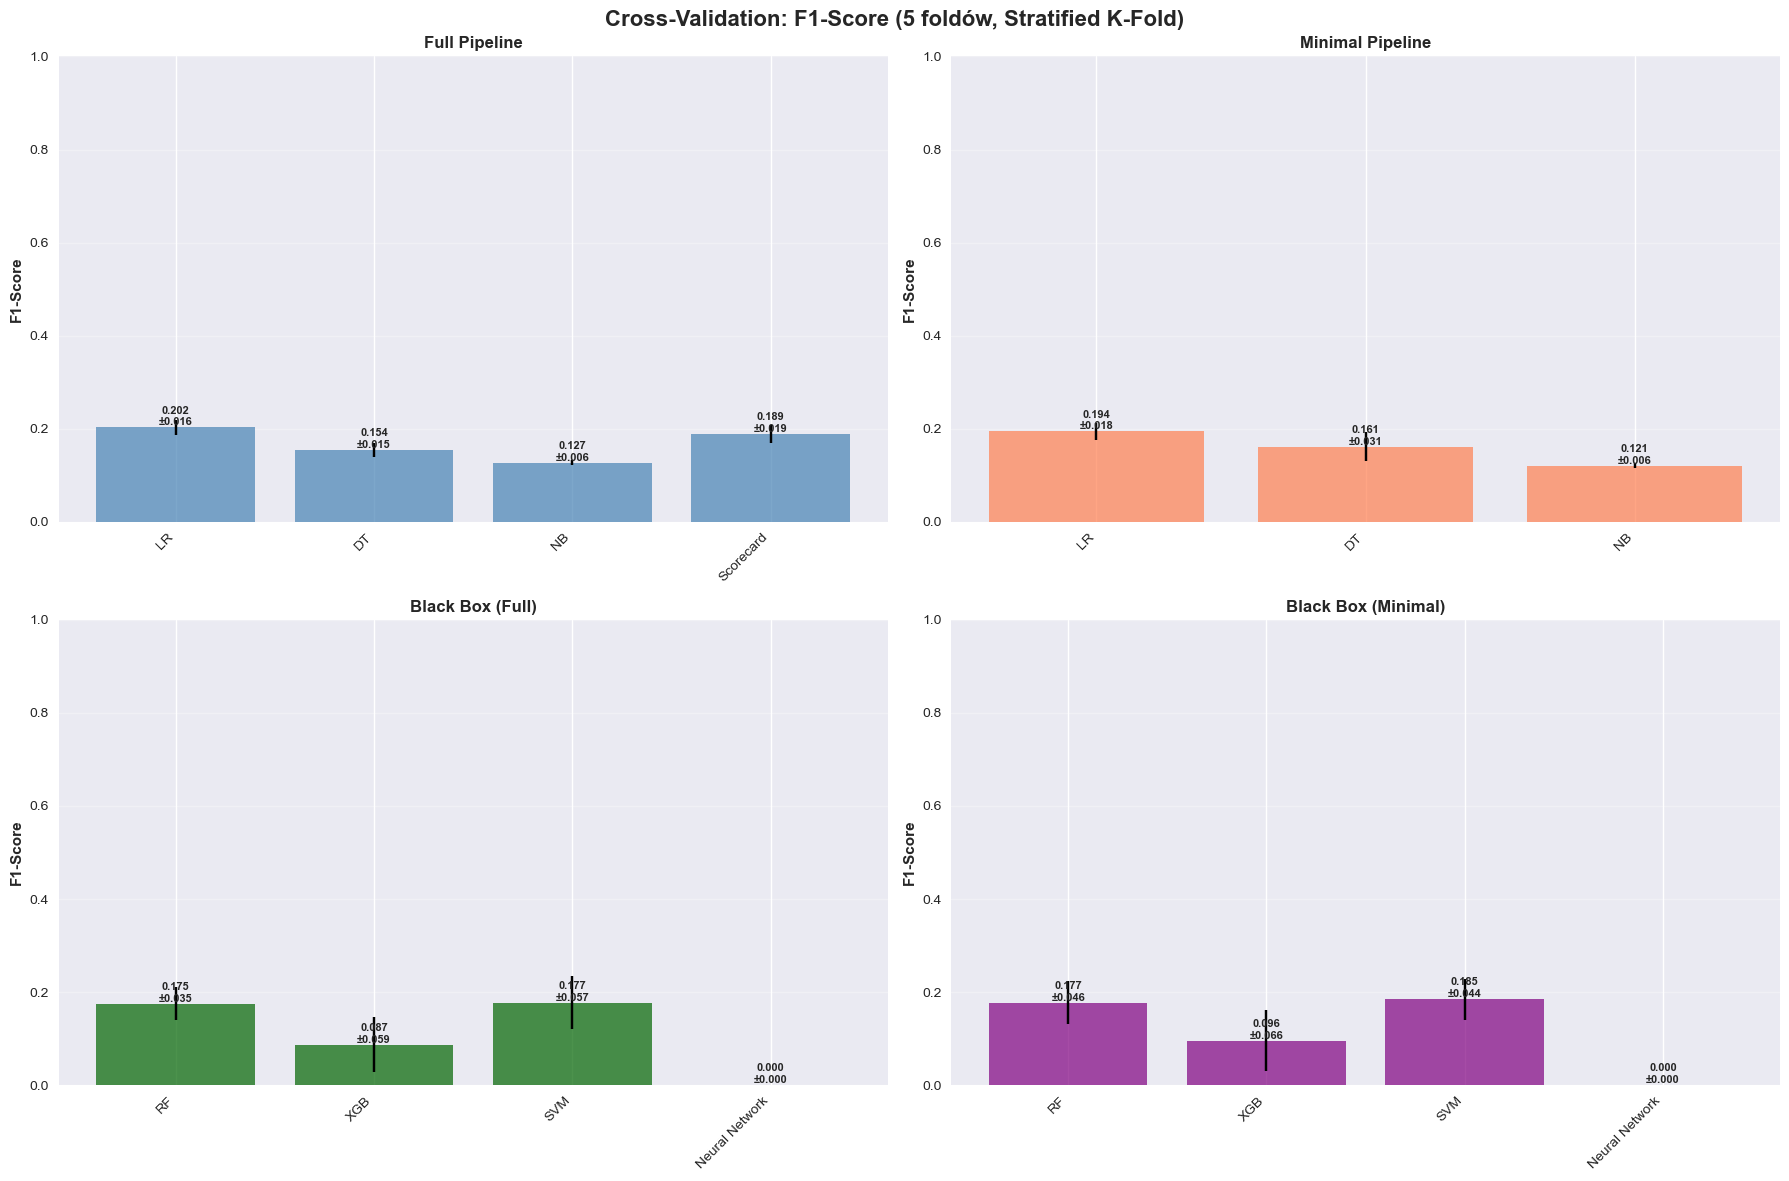


📈 Podsumowanie Cross-Validation:

Full Pipeline:
  Średnia F1-Score (wszystkie modele): 0.1680
  Najlepszy model: LR (0.2024 ± 0.0164)

Minimal Pipeline:
  Średnia F1-Score (wszystkie modele): 0.1586
  Najlepszy model: LR (0.1939 ± 0.0177)

Black Box (Full):
  Średnia F1-Score (wszystkie modele): 0.1098
  Najlepszy model: SVM (0.1766 ± 0.0569)

Black Box (Minimal):
  Średnia F1-Score (wszystkie modele): 0.1143
  Najlepszy model: SVM (0.1849 ± 0.0441)



In [92]:
# Przygotowanie danych do wizualizacji
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Cross-Validation: F1-Score (5 foldów, Stratified K-Fold)', fontsize=16, fontweight='bold')

pipeline_configs = [
    ('Full Pipeline', cv_results['Full Pipeline'], axes[0, 0], 'steelblue'),
    ('Minimal Pipeline', cv_results['Minimal Pipeline'], axes[0, 1], 'coral'),
    ('Black Box (Full)', cv_results['Black Box (Full)'], axes[1, 0], 'darkgreen'),
    ('Black Box (Minimal)', cv_results['Black Box (Minimal)'], axes[1, 1], 'purple')
]

for pipeline_name, results, ax, color in pipeline_configs:
    model_names = list(results.keys())
    means = [results[m]['mean'] for m in model_names]
    stds = [results[m]['std'] for m in model_names]
    
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, means, yerr=stds, alpha=0.7, color=color, capsize=5, ecolor='black')
    
    ax.set_ylabel('F1-Score', fontweight='bold')
    ax.set_title(pipeline_name, fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    # Dodaj wartości na słupkach
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.3f}\n±{std:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Podsumowanie statystyk
print("\n📈 Podsumowanie Cross-Validation:")
print("="*110)

for pipeline_name in ['Full Pipeline', 'Minimal Pipeline', 'Black Box (Full)', 'Black Box (Minimal)']:
    results = cv_results[pipeline_name]
    if results:
        avg_mean = np.mean([results[m]['mean'] for m in results.keys()])
        print(f"\n{pipeline_name}:")
        print(f"  Średnia F1-Score (wszystkie modele): {avg_mean:.4f}")
        best_model = max(results.keys(), key=lambda m: results[m]['mean'])
        print(f"  Najlepszy model: {best_model} ({results[best_model]['mean']:.4f} ± {results[best_model]['std']:.4f})")

print("\n" + "="*110)

## 9. Tabela Porównawcza

In [93]:
# Przygotowanie danych do porównania
comparison_data = []

for model_name in results_full.keys():
    # Full pipeline
    comparison_data.append({
        'Pipeline': 'Full',
        'Model': model_name,
        'Accuracy': results_full[model_name]['accuracy'],
        'Precision': results_full[model_name]['precision'],
        'Recall': results_full[model_name]['recall'],
        'F1-Score': results_full[model_name]['f1'],
        'ROC-AUC': results_full[model_name]['auc']
    })
    
    # Minimal pipeline
    if model_name in results_minimal:
        comparison_data.append({
            'Pipeline': 'Minimal',
            'Model': model_name,
            'Accuracy': results_minimal[model_name]['accuracy'],
            'Precision': results_minimal[model_name]['precision'],
            'Recall': results_minimal[model_name]['recall'],
            'F1-Score': results_minimal[model_name]['f1'],
            'ROC-AUC': results_minimal[model_name]['auc']
        })

# Dodaj modele black box (Full Pipeline)
for model_name in results_blackbox_full.keys():
    comparison_data.append({
        'Pipeline': 'Black Box (Full)',
        'Model': model_name,
        'Accuracy': results_blackbox_full[model_name]['accuracy'],
        'Precision': results_blackbox_full[model_name]['precision'],
        'Recall': results_blackbox_full[model_name]['recall'],
        'F1-Score': results_blackbox_full[model_name]['f1'],
        'ROC-AUC': results_blackbox_full[model_name]['auc']
    })

# Dodaj modele black box (Minimal Pipeline)
for model_name in results_blackbox.keys():
    comparison_data.append({
        'Pipeline': 'Black Box (Minimal)',
        'Model': model_name,
        'Accuracy': results_blackbox[model_name]['accuracy'],
        'Precision': results_blackbox[model_name]['precision'],
        'Recall': results_blackbox[model_name]['recall'],
        'F1-Score': results_blackbox[model_name]['f1'],
        'ROC-AUC': results_blackbox[model_name]['auc']
    })

comparison_df = pd.DataFrame(comparison_data)

print("="*110)
print("PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)")
print("="*110)
print()
print(comparison_df.to_string(index=False))
print()
print(f"\n🔢 Liczba cech:")
print(f"   Full Pipeline:         {X_train_full.shape[1]} cech")
print(f"   Minimal Pipeline:      {X_train_minimal.shape[1]} cech")
print(f"   Black Box (Full):      {X_train_full.shape[1]} cech (używa Full Pipeline)")
print(f"   Black Box (Minimal):   {X_train_minimal.shape[1]} cech (używa Minimal Pipeline)")

PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)

           Pipeline          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
               Full             LR  0.747778   0.116071 0.472727  0.186380 0.686584
            Minimal             LR  0.766667   0.132701 0.509091  0.210526 0.689446
               Full             DT  0.591111   0.099744 0.709091  0.174888 0.672523
            Minimal             DT  0.478889   0.089286 0.818182  0.161002 0.672544
               Full             NB  0.278889   0.065789 0.818182  0.121786 0.533771
            Minimal             NB  0.335556   0.064205 0.727273  0.117994 0.534363
               Full      Scorecard  0.675556   0.130841 0.763636  0.223404 0.771060
   Black Box (Full)             RF  0.847778   0.163934 0.363636  0.225989 0.770737
   Black Box (Full)            XGB  0.921111   0.192308 0.090909  0.123457 0.741861
   Black Box (Full)            SVM  0.815556   0.132450 0.363636  0.194175 0.69443

## 10. Wizualizacje Porównawcze

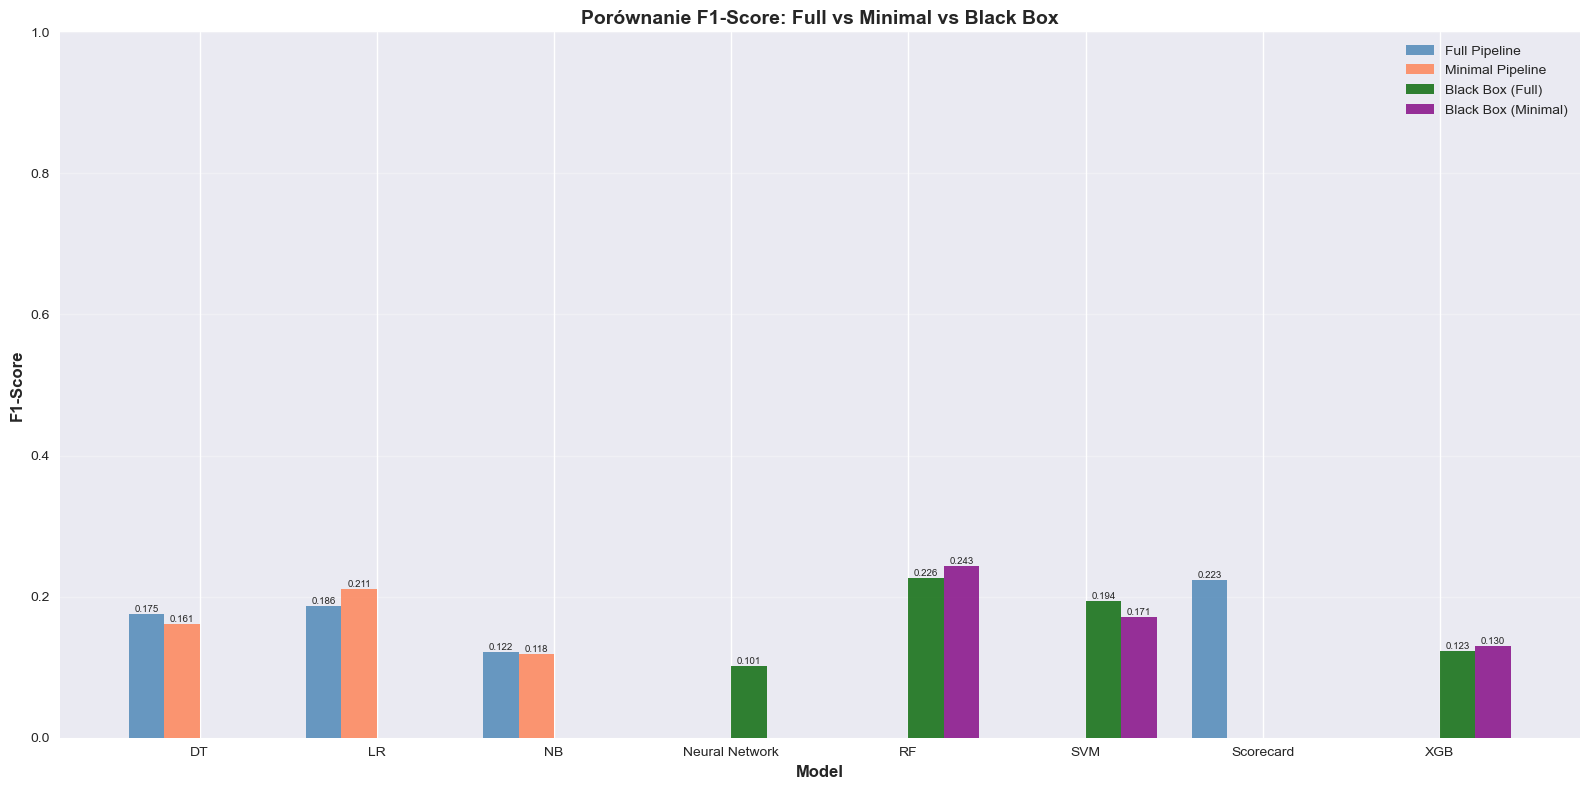


📈 Średnie F1-Score:
   Full Pipeline (Interpretable):       0.1766
   Minimal Pipeline (Interpretable):    0.1632
   Black Box (Full Pipeline):           0.1612
   Black Box (Minimal Pipeline):        0.1360

📊 Różnice:
   Full vs Minimal:                     +0.0134
   Black Box (Full) vs Full:            -0.0154
   Black Box (Minimal) vs Minimal:      -0.0271

✅ Najlepszy średni wynik: Full (Interpretable) (0.1766)


In [94]:
# Wykres słupkowy F1-Score
fig, ax = plt.subplots(figsize=(16, 8))

# Przygotuj dane - wszystkie unikalne modele
all_model_names = sorted(set(list(results_full.keys()) + list(results_blackbox_full.keys()) + list(results_blackbox.keys())))

full_f1s = [results_full[m]['f1'] if m in results_full else 0 for m in all_model_names]
minimal_f1s = [results_minimal[m]['f1'] if m in results_minimal else 0 for m in all_model_names]
blackbox_full_f1s = [results_blackbox_full[m]['f1'] if m in results_blackbox_full else 0 for m in all_model_names]
blackbox_minimal_f1s = [results_blackbox[m]['f1'] if m in results_blackbox else 0 for m in all_model_names]

x = np.arange(len(all_model_names))
width = 0.2

bars1 = ax.bar(x - 1.5*width, full_f1s, width, label='Full Pipeline', color='steelblue', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, minimal_f1s, width, label='Minimal Pipeline', color='coral', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, blackbox_full_f1s, width, label='Black Box (Full)', color='darkgreen', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, blackbox_minimal_f1s, width, label='Black Box (Minimal)', color='purple', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('F1-Score', fontweight='bold', fontsize=12)
ax.set_title('Porównanie F1-Score: Full vs Minimal vs Black Box', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(all_model_names)
ax.legend(fontsize=10, loc='best')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.0, 1.0])

# Wartości na słupkach
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:  # Tylko dla niepustych słupków
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=7, rotation=0)

plt.tight_layout()
plt.show()

# Statystyki
interpretable_f1s = [results_full[m]['f1'] for m in results_full.keys()]
minimal_all_f1s = [results_minimal[m]['f1'] for m in results_minimal.keys()]
blackbox_full_all_f1s = [results_blackbox_full[m]['f1'] for m in results_blackbox_full.keys()]
blackbox_minimal_all_f1s = [results_blackbox[m]['f1'] for m in results_blackbox.keys()]

avg_full = np.mean(interpretable_f1s)
avg_minimal = np.mean(minimal_all_f1s)
avg_blackbox_full = np.mean(blackbox_full_all_f1s) if blackbox_full_all_f1s else 0
avg_blackbox_minimal = np.mean(blackbox_minimal_all_f1s) if blackbox_minimal_all_f1s else 0

print(f"\n📈 Średnie F1-Score:")
print(f"   Full Pipeline (Interpretable):       {avg_full:.4f}")
print(f"   Minimal Pipeline (Interpretable):    {avg_minimal:.4f}")
if blackbox_full_all_f1s:
    print(f"   Black Box (Full Pipeline):           {avg_blackbox_full:.4f}")
if blackbox_minimal_all_f1s:
    print(f"   Black Box (Minimal Pipeline):        {avg_blackbox_minimal:.4f}")

print(f"\n📊 Różnice:")
print(f"   Full vs Minimal:                     {avg_full - avg_minimal:+.4f}")
if blackbox_full_all_f1s:
    print(f"   Black Box (Full) vs Full:            {avg_blackbox_full - avg_full:+.4f}")
if blackbox_minimal_all_f1s:
    print(f"   Black Box (Minimal) vs Minimal:      {avg_blackbox_minimal - avg_minimal:+.4f}")

# Najlepszy model
pipelines_to_compare = [
    ('Full (Interpretable)', avg_full),
    ('Minimal (Interpretable)', avg_minimal),
]
if blackbox_full_all_f1s:
    pipelines_to_compare.append(('Black Box (Full)', avg_blackbox_full))
if blackbox_minimal_all_f1s:
    pipelines_to_compare.append(('Black Box (Minimal)', avg_blackbox_minimal))

best_pipeline = max(pipelines_to_compare, key=lambda x: x[1])

print(f"\n✅ Najlepszy średni wynik: {best_pipeline[0]} ({best_pipeline[1]:.4f})")

## 11. Wnioski

**Porównanie zostało zakończone!**

Ten notebook porównał cztery kategorie modeli:
- **Full Pipeline (Interpretable)**: LR, DT, NB z pełnymi transformacjami statystycznymi
- **Minimal Pipeline (Interpretable)**: LR, DT, NB z minimalnym preprocessingiem
- **Black Box (Full Pipeline)**: Random Forest, XGBoost, SVM i Neural Network z pełnymi transformacjami
- **Black Box (Minimal Pipeline)**: Random Forest, XGBoost, SVM i Neural Network z minimalnym preprocessingiem

Sprawdź wyniki powyżej, aby określić:
1. Czy złożone transformacje poprawiają wyniki modeli interpretowalnych
2. Jak modele black box wypadają w porównaniu do modeli interpretowalnych
3. Czy black box modele bardziej korzystają z Full czy Minimal Pipeline
4. Która strategia oferuje najlepszy kompromis między interpretowalnością a wydajnością
5. Jak cross-validation potwierdza stabilność wyników modeli

## 12. Feature Importance z SHAP (Full Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla pełnego pipeline'u.

In [95]:
# SHAP Full Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Full Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_FULL = True
except ImportError:
    SHAP_AVAILABLE_FULL = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

full_top30_features = []
shap_full_df = None

if SHAP_AVAILABLE_FULL:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_full))
    X_sample_full = X_train_full.sample(n=sample_size, random_state=42)
    
    shap_results_full = []
    
    # 1. LOGISTIC REGRESSION (Full)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Full)...")
    explainer_lr_full = shap.LinearExplainer(lr_full, X_sample_full)
    shap_values_lr_full = explainer_lr_full.shap_values(X_sample_full)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_full) == list:
        shap_values_lr_full = shap_values_lr_full[1]
    
    shap_abs_mean_lr_full = np.abs(shap_values_lr_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_full[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Full)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Full)...")
    explainer_dt_full = shap.TreeExplainer(dt_full)
    shap_values_dt_full = explainer_dt_full.shap_values(X_sample_full)
    
    if type(shap_values_dt_full) == list:
        shap_values_dt_full = shap_values_dt_full[1]
    
    shap_abs_mean_dt_full = np.abs(shap_values_dt_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_full[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Full)
    print("[3/3] Obliczanie SHAP dla Random Forest (Full)...")
    explainer_rf_full = shap.TreeExplainer(rf_blackbox_full)
    shap_values_rf_full = explainer_rf_full.shap_values(X_sample_full)
    
    if type(shap_values_rf_full) == list:
        shap_values_rf_full = shap_values_rf_full[1]
    
    shap_abs_mean_rf_full = np.abs(shap_values_rf_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_full[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_full_df = pd.DataFrame(shap_results_full)
    shap_full_agg = shap_full_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    print(shap_full_agg['SHAP_mean'].head())

    shap_full_agg['SHAP_mean'] = shap_full_agg['SHAP_mean'].apply(
        lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
    )
    shap_full_agg = shap_full_agg.sort_values('SHAP_mean', ascending=False)
    
    full_top30_features = shap_full_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Full Pipeline).")
    print(f"Top 30 cech: {len(full_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Full Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Full)...
[2/3] Obliczanie SHAP dla Decision Tree (Full)...
[3/3] Obliczanie SHAP dla Random Forest (Full)...
0       [0.2001306959854191, 0.2001306959854191]
1     [0.06999270640832954, 0.06999270640832954]
2    [0.05896821454755943, 0.058968214547559246]
3     [0.03984365402834628, 0.03984365402834628]
4     [0.03446140273358141, 0.03446140273358141]
Name: SHAP_mean, dtype: object

✅ Obliczenia SHAP zakończone (Full Pipeline).
Top 30 cech: 30 cech wybranych.
0       [0.2001306959854191, 0.2001306959854191]
1     [0.06999270640832954, 0.06999270640832954]
2    [0.05896821454755943, 0.058968214547559246]
3     [0.03984365402834628, 0.03984365402834628]
4     [0.03446140273358141, 0.03446140273358141]
Name: SHAP_mean, dtype: object

✅ Obliczenia SHAP zakończone (Full Pipeline).
Top 30 cech: 30 cech wybranych.


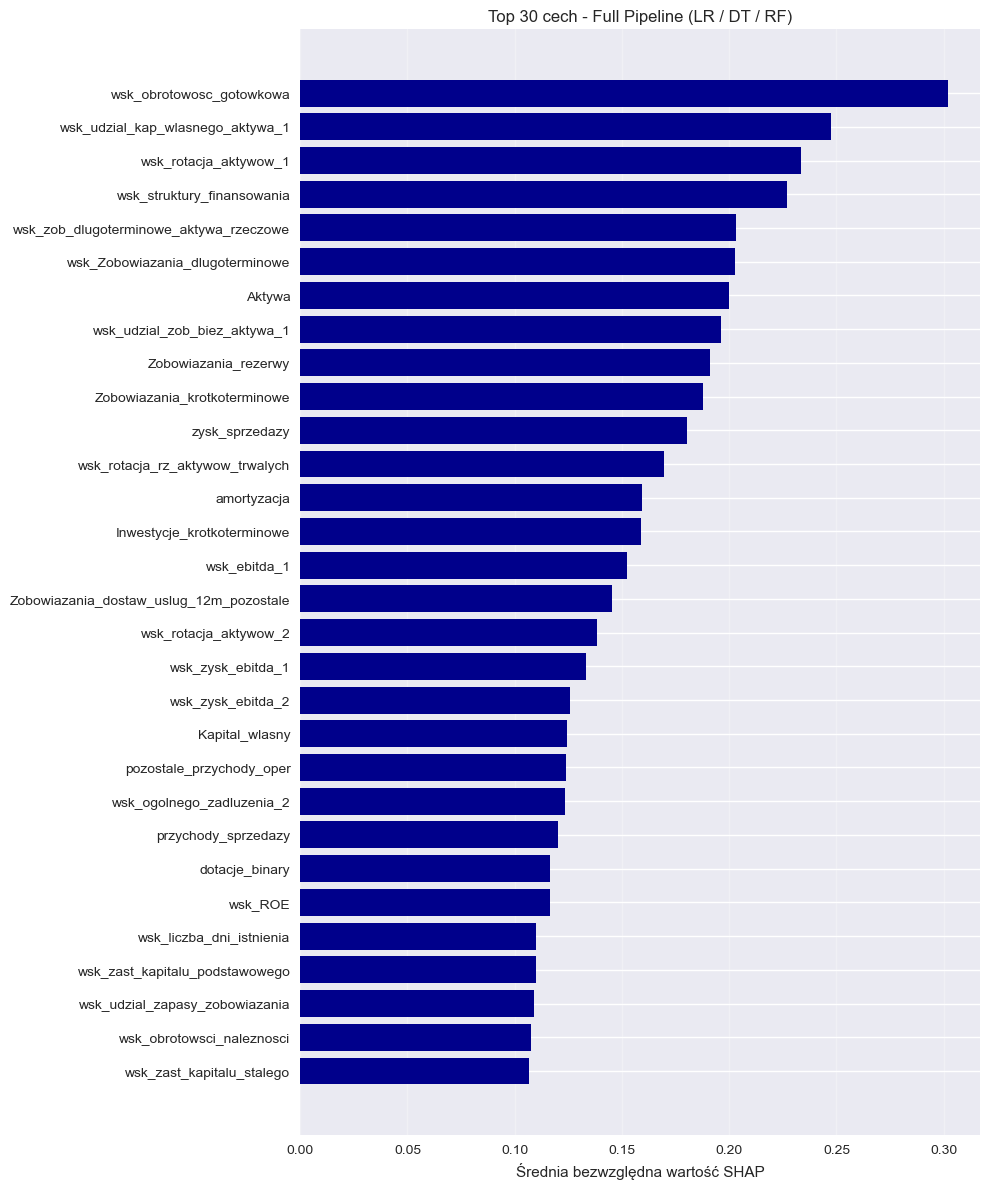

In [96]:
# Wykres Top 30 Full Pipeline
if shap_full_df is not None and len(full_top30_features) > 0:
    plot_df_full = shap_full_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_full['feature'][::-1], plot_df_full['SHAP_mean'][::-1], color='darkblue')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Full Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Full Pipeline SHAP.')

## 13. Feature Importance z SHAP (Minimal Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla minimalnego pipeline'u.

In [97]:
# SHAP Minimal Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_MIN = True
except ImportError:
    SHAP_AVAILABLE_MIN = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

minimal_top30_features = []
shap_min_df = None

if SHAP_AVAILABLE_MIN:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_minimal))
    X_sample_min = X_train_minimal.sample(n=sample_size, random_state=42)
    
    shap_results_min = []
    
    # 1. LOGISTIC REGRESSION (Minimal)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...")
    explainer_lr_min = shap.LinearExplainer(lr_minimal, X_sample_min)
    shap_values_lr_min = explainer_lr_min.shap_values(X_sample_min)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_min) == list:
        shap_values_lr_min = shap_values_lr_min[1]
    
    shap_abs_mean_lr_min = np.abs(shap_values_lr_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_min[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Minimal)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...")
    explainer_dt_min = shap.TreeExplainer(dt_minimal)
    shap_values_dt_min = explainer_dt_min.shap_values(X_sample_min)
    
    if type(shap_values_dt_min) == list:
        shap_values_dt_min = shap_values_dt_min[1]
    
    shap_abs_mean_dt_min = np.abs(shap_values_dt_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_min[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Minimal)
    print("[3/3] Obliczanie SHAP dla Random Forest (Minimal)...")
    explainer_rf_min = shap.TreeExplainer(rf_blackbox)
    shap_values_rf_min = explainer_rf_min.shap_values(X_sample_min)
    
    if type(shap_values_rf_min) == list:
        shap_values_rf_min = shap_values_rf_min[1]
    
    shap_abs_mean_rf_min = np.abs(shap_values_rf_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_min[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_min_df = pd.DataFrame(shap_results_min)
    shap_min_agg = shap_min_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    shap_min_agg['SHAP_mean'] = shap_min_agg['SHAP_mean'].apply(
    lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
)
    shap_min_agg = shap_min_agg.sort_values('SHAP_mean', ascending=False)
    
    minimal_top30_features = shap_min_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Minimal Pipeline).")
    print(f"Top 30 cech: {len(minimal_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...
[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...
[3/3] Obliczanie SHAP dla Random Forest (Minimal)...

✅ Obliczenia SHAP zakończone (Minimal Pipeline).
Top 30 cech: 30 cech wybranych.

✅ Obliczenia SHAP zakończone (Minimal Pipeline).
Top 30 cech: 30 cech wybranych.


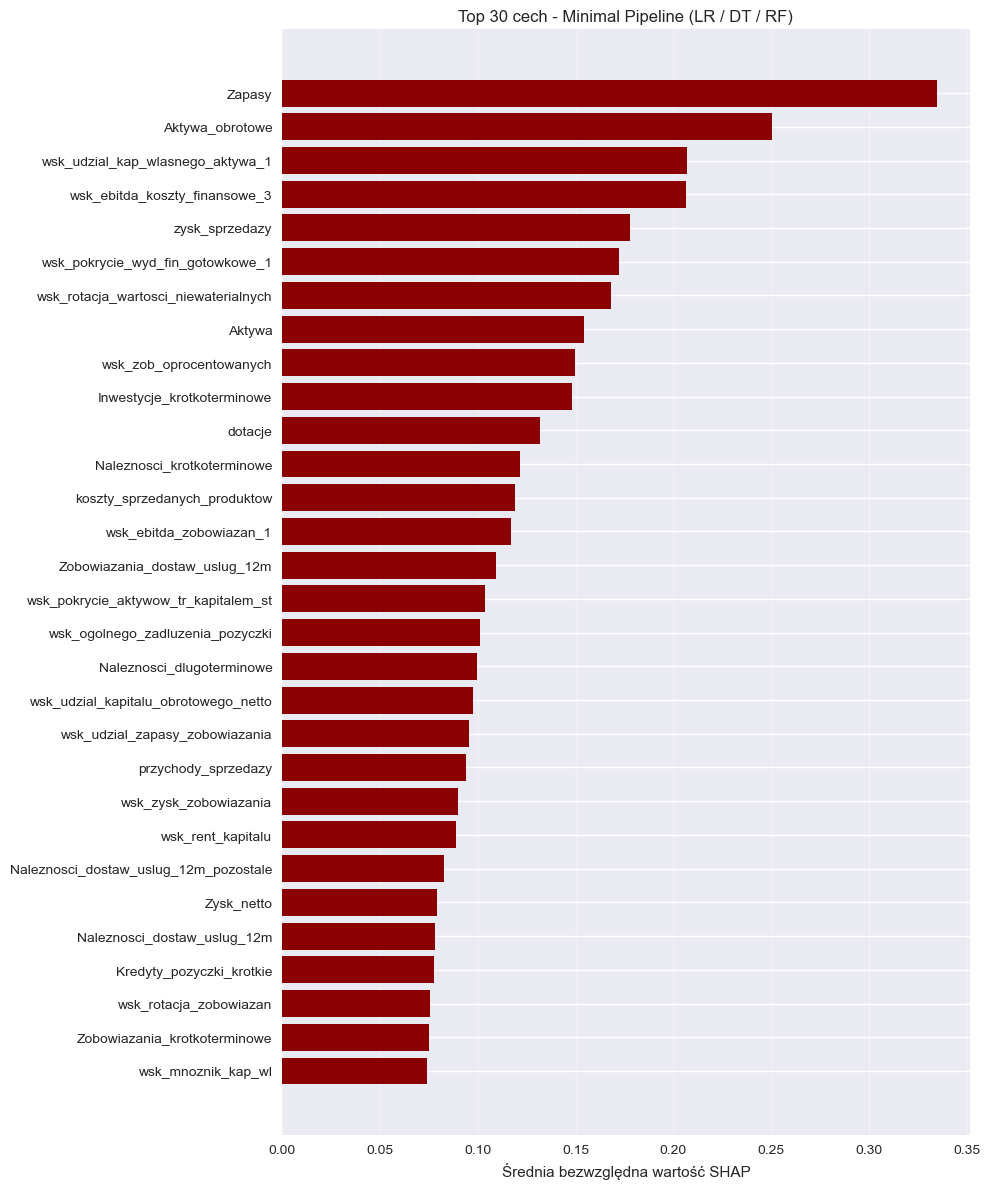

In [98]:
# Wykres Top 30 Minimal Pipeline
if shap_min_df is not None and len(minimal_top30_features) > 0:
    plot_df_min = shap_min_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_min['feature'][::-1], plot_df_min['SHAP_mean'][::-1], color='darkred')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Minimal Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Minimal Pipeline SHAP.')

## 14. Modele na Top 30 cechach (Full Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla pełnego pipeline'u.

In [99]:
# Modele na Top 30 cechach - Full Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE")
print("="*100)

if len(full_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_full_top30 = X_train_full[full_top30_features]
    X_test_full_top30 = X_test_full[full_top30_features]
    
    print(f"\nWybrano {len(full_top30_features)} cech z {X_train_full.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_full_top30.shape}")
    print(f"Kształt danych testowych: {X_test_full_top30.shape}")
    
    results_full_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Full)...")
    lr_full_top30 = LogisticRegression(max_iter=1000, random_state=42)
    lr_full_top30.fit(X_train_full_top30, y_train)
    y_pred_lr_full_top30 = lr_full_top30.predict(X_test_full_top30)
    y_proba_lr_full_top30 = lr_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['LR'] = {
        'model': lr_full_top30,
        'y_pred': y_pred_lr_full_top30,
        'y_proba': y_proba_lr_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_full_top30),
        'precision': precision_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Full)...")
    dt_full_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42)
    dt_full_top30.fit(X_train_full_top30, y_train)
    y_pred_dt_full_top30 = dt_full_top30.predict(X_test_full_top30)
    y_proba_dt_full_top30 = dt_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['DT'] = {
        'model': dt_full_top30,
        'y_pred': y_pred_dt_full_top30,
        'y_proba': y_proba_dt_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_full_top30),
        'precision': precision_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Full)...")
    rf_full_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42)
    rf_full_top30.fit(X_train_full_top30, y_train)
    y_pred_rf_full_top30 = rf_full_top30.predict(X_test_full_top30)
    y_proba_rf_full_top30 = rf_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['RF'] = {
        'model': rf_full_top30,
        'y_pred': y_pred_rf_full_top30,
        'y_proba': y_proba_rf_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_full_top30),
        'precision': precision_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_full_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Full Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE

Wybrano 30 cech z 157 dostępnych.
Kształt danych treningowych: (2100, 30)
Kształt danych testowych: (900, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0000
[2/3] Trening Decision Tree na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0000
[3/3] Trening Random Forest na Top 30 cechach (Full)...
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.9378       0.0000       0.0000       0.0000       0.6845      
DT                   0.9378       0.0000       0.0000       0.0000       0.7045      
RF                   0.9389       0.0000       0.0000       0.0000       0.7589      

✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW

## 15. Modele na Top 30 cechach (Minimal Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla minimalnego pipeline'u.

In [100]:
# Modele na Top 30 cechach - Minimal Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE")
print("="*100)

if len(minimal_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_minimal_top30 = X_train_minimal[minimal_top30_features]
    X_test_minimal_top30 = X_test_minimal[minimal_top30_features]
    
    print(f"\nWybrano {len(minimal_top30_features)} cech z {X_train_minimal.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_minimal_top30.shape}")
    print(f"Kształt danych testowych: {X_test_minimal_top30.shape}")
    
    results_minimal_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...")
    lr_minimal_top30 = LogisticRegression(max_iter=1000, random_state=42)
    lr_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_lr_minimal_top30 = lr_minimal_top30.predict(X_test_minimal_top30)
    y_proba_lr_minimal_top30 = lr_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['LR'] = {
        'model': lr_minimal_top30,
        'y_pred': y_pred_lr_minimal_top30,
        'y_proba': y_proba_lr_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_minimal_top30),
        'precision': precision_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...")
    dt_minimal_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42)
    dt_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_dt_minimal_top30 = dt_minimal_top30.predict(X_test_minimal_top30)
    y_proba_dt_minimal_top30 = dt_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['DT'] = {
        'model': dt_minimal_top30,
        'y_pred': y_pred_dt_minimal_top30,
        'y_proba': y_proba_dt_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_minimal_top30),
        'precision': precision_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Minimal)...")
    rf_minimal_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42)
    rf_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_rf_minimal_top30 = rf_minimal_top30.predict(X_test_minimal_top30)
    y_proba_rf_minimal_top30 = rf_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['RF'] = {
        'model': rf_minimal_top30,
        'y_pred': y_pred_rf_minimal_top30,
        'y_proba': y_proba_rf_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_minimal_top30),
        'precision': precision_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_minimal_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Minimal Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE

Wybrano 30 cech z 125 dostępnych.
Kształt danych treningowych: (2100, 30)
Kształt danych testowych: (900, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0328
[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0635
[3/3] Trening Random Forest na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.0000

PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.9344       0.1667       0.0182       0.0328       0.6487      
DT                   0.9344       0.2500       0.0364       0.0635       0.6947      
RF                   0.9389       0.0000       0.0000       0.0000       0.7490      

✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.
  ✓ F1-Score: 0.0000

PO

## 16. Porównanie: Wszystkie cechy vs Top 30 cech

Wizualizacja porównująca wyniki modeli na wszystkich cechach z wynikami na Top 30 cechach wybranych przez SHAP.

PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH


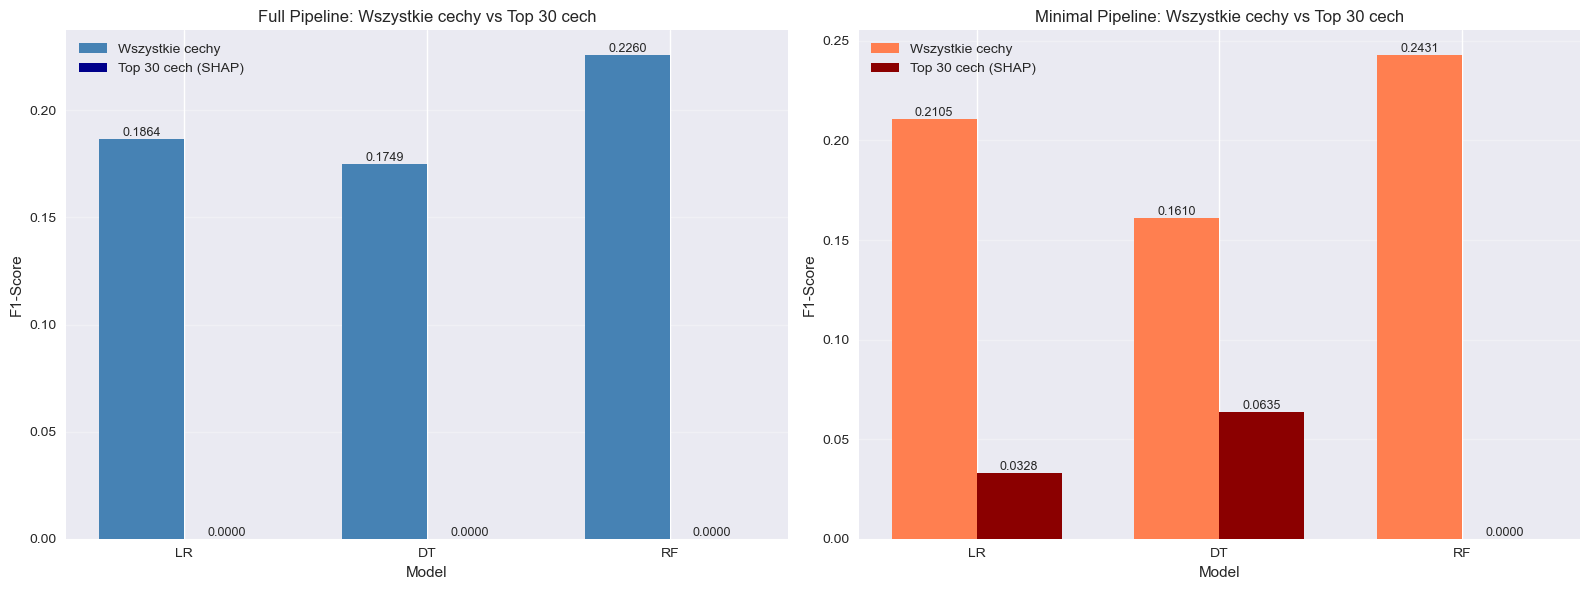


✅ Porównanie wyników zakończone.


In [101]:
# Porównanie wyników: Wszystkie cechy vs Top 30 cech
print("="*100)
print("PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH")
print("="*100)

# Przygotowanie danych do porównania
comparison_data_top30 = []

# FULL PIPELINE
if len(full_top30_features) > 0:
    # Wszystkie cechy Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_full['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_full['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox_full['RF']['f1']
    })
    
    # Top 30 Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_full_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_full_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_full_top30['RF']['f1']
    })

# MINIMAL PIPELINE
if len(minimal_top30_features) > 0:
    # Wszystkie cechy Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_minimal['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_minimal['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox['RF']['f1']
    })
    
    # Top 30 Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_minimal_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_minimal_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_minimal_top30['RF']['f1']
    })

comparison_df_top30 = pd.DataFrame(comparison_data_top30)

# Wykres porównawczy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full Pipeline
full_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Full']
x_labels = ['LR', 'DT', 'RF']
all_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'All')]['F1-Score'].values[0] 
                     for m in x_labels]
top30_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                       for m in x_labels]

x_pos = np.arange(len(x_labels))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, all_features_full, width, label='Wszystkie cechy', color='steelblue')
bars2 = axes[0].bar(x_pos + width/2, top30_features_full, width, label='Top 30 cech (SHAP)', color='darkblue')

axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('Full Pipeline: Wszystkie cechy vs Top 30 cech')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(x_labels)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Minimal Pipeline
minimal_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Minimal']
all_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'All')]['F1-Score'].values[0] 
                        for m in x_labels]
top30_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                          for m in x_labels]

bars3 = axes[1].bar(x_pos - width/2, all_features_minimal, width, label='Wszystkie cechy', color='coral')
bars4 = axes[1].bar(x_pos + width/2, top30_features_minimal, width, label='Top 30 cech (SHAP)', color='darkred')

axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Minimal Pipeline: Wszystkie cechy vs Top 30 cech')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Porównanie wyników zakończone.")

## 🔬 Eksperymenty z SMOTE i Wagami Klas

Porównanie różnych strategii balansowania klas:
- **SMOTE** z różnymi proporcjami oversamplingowymi (0.3, 0.5, 0.7, 1.0)
- **Wagi klas** (balanced)
- **Bez balansowania** (baseline)

In [102]:
# Import SMOTE
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    SMOTE_AVAILABLE = True
    print("✅ SMOTE dostępny (imblearn)")
except ImportError:
    SMOTE_AVAILABLE = False
    print("⚠️  imblearn nie jest zainstalowany. Instaluję...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    SMOTE_AVAILABLE = True
    print("✅ SMOTE zainstalowany i zaimportowany")

# Sprawdzenie rozkładu klas
print(f"\n📊 Rozkład klas w zbiorze treningowym:")
print(f"   Klasa 0 (brak defaultu): {(y_train == 0).sum()} ({100*(y_train == 0).sum()/len(y_train):.2f}%)")
print(f"   Klasa 1 (default): {(y_train == 1).sum()} ({100*(y_train == 1).sum()/len(y_train):.2f}%)")
print(f"   Ratio (minority/majority): {(y_train == 1).sum() / (y_train == 0).sum():.3f}")

✅ SMOTE dostępny (imblearn)

📊 Rozkład klas w zbiorze treningowym:
   Klasa 0 (brak defaultu): 1972 (93.90%)
   Klasa 1 (default): 128 (6.10%)
   Ratio (minority/majority): 0.065


### Eksperymenty na Full Pipeline

In [103]:
# Wrapper class dla Scorecard - kompatybilny z sklearn
class ScorecardModel:
    """
    Scorecard model z automatyczną transformacją WoE.
    Działa jak zwykły sklearn model, ale wewnątrz transformuje features na WoE.
    """
    def __init__(self, n_features=15, bins=5, max_iter=1000, random_state=1, class_weight=None):
        self.n_features = n_features
        self.bins = bins
        self.max_iter = max_iter
        self.random_state = random_state
        self.class_weight = class_weight
        self.model = None
        self.selected_features = None
        self.woe_mappings = {}
        
    def _calculate_woe_iv(self, df, feature, target, bins):
        """Oblicza WoE i IV dla zmiennej (tylko do selekcji features)"""
        try:
            df_temp = pd.DataFrame({'feature': df[feature], 'target': df[target]}).dropna()
            df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
        except:
            try:
                df_temp = pd.DataFrame({'feature': df[feature], 'target': df[target]}).dropna()
                df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
            except:
                return None, 0.0
        
        grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
        grouped.columns = ['bad', 'total']
        grouped['good'] = grouped['total'] - grouped['bad']
        
        total_good = grouped['good'].sum()
        total_bad = grouped['bad'].sum()
        
        if total_good == 0 or total_bad == 0:
            return None, 0.0
        
        grouped['good_dist'] = grouped['good'] / total_good
        grouped['bad_dist'] = grouped['bad'] / total_bad
        grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
        grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
        
        iv_total = grouped['iv'].sum()
        return grouped[['woe']], iv_total
    
    def _transform_woe(self, X, feature, y=None):
        """Transformuje pojedynczą zmienną na WoE"""
        if feature not in self.woe_mappings:
            if y is None:
                raise ValueError(f"Brak mappingu WoE dla {feature} - najpierw wywołaj fit()")
            # Trenowanie - zapisz mapping i bin edges
            df_temp = pd.DataFrame({feature: X[feature], 'target': y}).dropna()
            try:
                df_temp['bin'] = pd.qcut(df_temp[feature], q=self.bins, duplicates='drop', retbins=False)
                # Zapisz bin edges dla qcut
                _, bin_edges = pd.qcut(df_temp[feature], q=self.bins, duplicates='drop', retbins=True)
                self.woe_mappings[feature] = {'method': 'qcut', 'bins': bin_edges}
            except:
                df_temp['bin'] = pd.cut(df_temp[feature], bins=self.bins, duplicates='drop', retbins=False)
                # Zapisz bin edges dla cut
                _, bin_edges = pd.cut(df_temp[feature], bins=self.bins, duplicates='drop', retbins=True)
                self.woe_mappings[feature] = {'method': 'cut', 'bins': bin_edges}
            
            # Oblicz WoE dla każdego bina
            grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
            grouped.columns = ['bad', 'total']
            grouped['good'] = grouped['total'] - grouped['bad']
            
            total_good = grouped['good'].sum()
            total_bad = grouped['bad'].sum()
            
            grouped['good_dist'] = grouped['good'] / total_good
            grouped['bad_dist'] = grouped['bad'] / total_bad
            grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
            
            woe_dict = dict(zip(grouped.index, grouped['woe']))
            self.woe_mappings[feature]['woe_dict'] = woe_dict
        
        # Transformacja używając zapisanych bin edges
        mapping = self.woe_mappings[feature]
        woe_dict = mapping['woe_dict']
        bin_edges = mapping['bins']
        
        # Użyj bin edges do binowania (zawsze cut, bo mamy konkretne edges)
        feature_binned = pd.cut(X[feature], bins=bin_edges, include_lowest=True, duplicates='drop')
        
        # Konwertuj categorical na string i mapuj na WoE
        woe_values = np.zeros(len(X))
        for i, bin_val in enumerate(feature_binned):
            if pd.notna(bin_val):
                woe_values[i] = woe_dict.get(bin_val, 0)
        
        return pd.Series(woe_values, index=X.index)
    
    def fit(self, X, y):
        """Trenuje model Scorecard"""
        # Wybierz zmienne numeryczne
        numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
        
        # Oblicz IV dla wszystkich i wybierz top N
        iv_results = []
        for feature in numeric_features:
            try:
                _, iv_value = self._calculate_woe_iv(
                    pd.DataFrame({feature: X[feature], 'target': y}),
                    feature, 'target', self.bins
                )
                if iv_value > 0:  # Tylko features z pozytywnym IV
                    iv_results.append({'feature': feature, 'iv': iv_value})
            except:
                continue
        
        if len(iv_results) == 0:
            raise ValueError("Nie znaleziono żadnych zmiennych z pozytywnym IV")
        
        iv_df = pd.DataFrame(iv_results).sort_values('iv', ascending=False)
        self.selected_features = iv_df.head(min(self.n_features, len(iv_df)))['feature'].tolist()
        
        # Transformuj na WoE
        X_woe = pd.DataFrame()
        for feature in self.selected_features:
            X_woe[f'{feature}_woe'] = self._transform_woe(X, feature, y)
        
        # Trenuj Logistic Regression
        self.model = LogisticRegression(
            max_iter=self.max_iter,
            random_state=self.random_state,
            class_weight=self.class_weight
        )
        self.model.fit(X_woe, y)
        
        return self
    
    def predict(self, X):
        """Predykcja"""
        X_woe = pd.DataFrame()
        for feature in self.selected_features:
            X_woe[f'{feature}_woe'] = self._transform_woe(X, feature, y=None)
        return self.model.predict(X_woe)
    
    def predict_proba(self, X):
        """Predykcja prawdopodobieństw"""
        X_woe = pd.DataFrame()
        for feature in self.selected_features:
            X_woe[f'{feature}_woe'] = self._transform_woe(X, feature, y=None)
        return self.model.predict_proba(X_woe)

print("✅ ScorecardModel class zdefiniowana")

✅ ScorecardModel class zdefiniowana


In [104]:
# # Przygotowanie danych - użyjemy już przetworzonego Full Pipeline
# X_train_smote = X_train_full.copy()
# X_test_smote = X_test_full.copy()
# y_train_smote = y_train.copy()
# y_test_smote = y_test.copy()

# # Konfiguracja eksperymentów - ROZSZERZONE PROGI
# smote_ratios = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# models_config = {
#     'LR': {'model': LogisticRegression, 'params': {'max_iter': 1000, 'random_state': 1}},
#     'Scorecard': {'model': ScorecardModel, 'params': {'n_features': 15, 'bins': 5, 'max_iter': 1000, 'random_state': 1}},
#     'DT': {'model': DecisionTreeClassifier, 'params': {'max_depth': 10, 'random_state': 1}},
#     'RF': {'model': RandomForestClassifier, 'params': {'n_estimators': 100, 'max_depth': 10, 'random_state': 1}},
#     'NB': {'model': GaussianNB, 'params': {}},
#     'SVM': {'model': SVC, 'params': {'kernel': 'rbf', 'probability': True, 'random_state': 1}},
#     'MLP': {'model': MLPClassifier, 'params': {'hidden_layer_sizes': (100, 50), 'max_iter': 1000, 'random_state': 1}}
# }

# # Dodaj XGBoost jeśli dostępny
# if XGBOOST_AVAILABLE:
#     from xgboost import XGBClassifier
#     models_config['XGB'] = {'model': XGBClassifier, 'params': {'n_estimators': 100, 'max_depth': 10, 'random_state': 1, 'eval_metric': 'logloss'}}

# print(f"📋 Modele do testowania: {', '.join(models_config.keys())}")

# # Słowniki na wyniki
# smote_results = {
#     'baseline': {},
#     'weighted': {},
#     'smote': {ratio: {} for ratio in smote_ratios}
# }
# smote_balanced_results = {ratio: {} for ratio in smote_ratios}

# print("🔄 Rozpoczynam kompleksowe eksperymenty SMOTE...")
# print("="*80)

# # ============================================
# # 1. BASELINE - bez balansowania
# # ============================================
# print("\n1️⃣  BASELINE (bez balansowania i bez SMOTE)")
# print("-"*80)

# for model_name, config in models_config.items():
#     print(f"   Trenuję {model_name}...", end=" ")
    
#     model = config['model'](**config['params'])
#     model.fit(X_train_smote, y_train_smote)
#     y_pred = model.predict(X_test_smote)
    
#     smote_results['baseline'][model_name] = {
#         'accuracy': accuracy_score(y_test_smote, y_pred),
#         'precision': precision_score(y_test_smote, y_pred, zero_division=0),
#         'recall': recall_score(y_test_smote, y_pred, zero_division=0),
#         'f1': f1_score(y_test_smote, y_pred, zero_division=0)
#     }
    
#     print(f"✓ F1: {smote_results['baseline'][model_name]['f1']:.4f}")

# # ============================================
# # 2. CLASS WEIGHTS - z wagami zbalansowanymi
# # ============================================
# print("\n\n2️⃣  CLASS WEIGHTS (wagi zbalansowane, bez SMOTE)")
# print("-"*80)

# for model_name, config in models_config.items():
#     print(f"   Trenuję {model_name} + Balanced...", end=" ")
    
#     params = config['params'].copy()
#     # NB i MLP nie wspierają class_weight, pomijamy
#     if model_name in ['NB', 'MLP']:
#         print(f"⊘ ({model_name} nie wspiera class_weight)")
#         smote_results['weighted'][model_name] = smote_results['baseline'][model_name].copy()
#         continue
    
#     # Scorecard też wspiera class_weight (przekazuje do wewnętrznego LR)
#     params['class_weight'] = 'balanced'
    
#     model = config['model'](**params)
#     model.fit(X_train_smote, y_train_smote)
#     y_pred = model.predict(X_test_smote)
    
#     smote_results['weighted'][model_name] = {
#         'accuracy': accuracy_score(y_test_smote, y_pred),
#         'precision': precision_score(y_test_smote, y_pred, zero_division=0),
#         'recall': recall_score(y_test_smote, y_pred, zero_division=0),
#         'f1': f1_score(y_test_smote, y_pred, zero_division=0)
#     }
    
#     print(f"✓ F1: {smote_results['weighted'][model_name]['f1']:.4f}")

# # ============================================
# # 3. SMOTE - z różnymi proporcjami
# # ============================================
# print("\n\n3️⃣  SMOTE (różne ratio, bez balanced weights)")
# print("-"*80)

# for ratio in smote_ratios:
#     print(f"\n   📊 SMOTE ratio = {ratio}")
    
#     smote = SMOTE(sampling_strategy=ratio, random_state=1)
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train_smote)
    
#     for model_name, config in models_config.items():
#         print(f"      Trenuję {model_name}...", end=" ")
        
#         model = config['model'](**config['params'])
#         model.fit(X_train_resampled, y_train_resampled)
#         y_pred = model.predict(X_test_smote)
        
#         smote_results['smote'][ratio][model_name] = {
#             'accuracy': accuracy_score(y_test_smote, y_pred),
#             'precision': precision_score(y_test_smote, y_pred, zero_division=0),
#             'recall': recall_score(y_test_smote, y_pred, zero_division=0),
#             'f1': f1_score(y_test_smote, y_pred, zero_division=0)
#         }
        
#         print(f"✓ F1: {smote_results['smote'][ratio][model_name]['f1']:.4f}")

# # ============================================
# # 4. SMOTE + BALANCED - kombinacja obu technik
# # ============================================
# print("\n\n4️⃣  SMOTE + BALANCED WEIGHTS (kombinacja)")
# print("-"*80)

# for ratio in smote_ratios:
#     print(f"\n   📊 SMOTE ratio = {ratio} + Balanced Weights")
    
#     smote = SMOTE(sampling_strategy=ratio, random_state=1)
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train_smote)
    
#     for model_name, config in models_config.items():
#         print(f"      Trenuję {model_name} + Balanced...", end=" ")
        
#         params = config['params'].copy()
        
#         # NB i MLP nie wspierają class_weight
#         if model_name in ['NB', 'MLP']:
#             print(f"⊘ ({model_name} nie wspiera class_weight)")
#             smote_balanced_results[ratio][model_name] = smote_results['smote'][ratio][model_name].copy()
#             continue
        
#         params['class_weight'] = 'balanced'
        
#         model = config['model'](**params)
#         model.fit(X_train_resampled, y_train_resampled)
#         y_pred = model.predict(X_test_smote)
        
#         smote_balanced_results[ratio][model_name] = {
#             'accuracy': accuracy_score(y_test_smote, y_pred),
#             'precision': precision_score(y_test_smote, y_pred, zero_division=0),
#             'recall': recall_score(y_test_smote, y_pred, zero_division=0),
#             'f1': f1_score(y_test_smote, y_pred, zero_division=0)
#         }
        
#         print(f"✓ F1: {smote_balanced_results[ratio][model_name]['f1']:.4f}")

# print("\n\n" + "="*80)
# print("✅ Wszystkie eksperymenty SMOTE zakończone!")
# print("="*80)

### 📊 Szczegółowe Tabele Porównawcze dla Każdego Modelu

In [105]:
# # TABELA PORÓWNAWCZA - WYNIKI WSZYSTKICH MODELI I STRATEGII

# print("\n" + "="*120)
# print("📊 WYNIKI EKSPERYMENTÓW SMOTE - WSZYSTKIE MODELE I STRATEGIE")
# print("="*120)

# # Przygotuj dane do tabeli
# print(f"\n{'Model':<8} {'Strategia':<18} {'Ratio':<8} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
# print("─" * 120)

# for model_name in models_config.keys():
#     # Baseline
#     metrics = smote_results['baseline'][model_name]
#     print(f"{model_name:<8} {'Baseline':<18} {'N/A':<8} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
#     # Weighted
#     metrics = smote_results['weighted'][model_name]
#     print(f"{model_name:<8} {'Weighted':<18} {'N/A':<8} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
#     # SMOTE
#     for ratio in smote_ratios:
#         metrics = smote_results['smote'][ratio][model_name]
#         print(f"{model_name:<8} {'SMOTE':<18} {ratio:<8.1f} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
#     # SMOTE + Balanced
#     for ratio in smote_ratios:
#         metrics = smote_balanced_results[ratio][model_name]
#         print(f"{model_name:<8} {'SMOTE+Balanced':<18} {ratio:<8.1f} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
    
#     print("─" * 120)

# # Dodaj Scorecard jako osobny baseline model
# print(f"\n{'='*120}")
# print("📋 DODATKOWE MODELE BASELINE (nie testowane z SMOTE)")
# print("─" * 120)
# if 'Scorecard' in results_full:
#     metrics = results_full['Scorecard']
#     print(f"{'Scorecard':<8} {'Baseline':<18} {'N/A':<8} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")
#     print("─" * 120)

# print("\n✅ Tabela wygenerowana")
# print("="*120)

---

## 🎯 Eksperymenty z Różnymi Strategiami Wag

Poza standardowym `class_weight='balanced'` możemy przetestować inne strategie balansowania klas.

In [106]:
# # Eksperyment: Różne strategie class_weight

# print("="*80)
# print("🎯 EKSPERYMENTY Z RÓŻNYMI STRATEGIAMI WAG")
# print("="*80)

# # Oblicz proporcje klas
# neg_count = (y_train == 0).sum()
# pos_count = (y_train == 1).sum()
# total = len(y_train)
# ratio = neg_count / pos_count

# print(f"\n📊 Rozkład klas w zbiorze treningowym:")
# print(f"   Klasa negatywna (0): {neg_count} ({100*neg_count/total:.2f}%)")
# print(f"   Klasa pozytywna (1): {pos_count} ({100*pos_count/total:.2f}%)")
# print(f"   Ratio (neg/pos): {ratio:.2f}")

# # Definicja strategii wag do przetestowania
# weight_strategies = {
#     'none': None,  # Bez wag
#     'balanced': 'balanced',  # Automatyczne balanced
#     'manual_1x': {0: 1.0, 1: ratio},  # Ręczne balanced (równoważne 'balanced')
#     'manual_1.5x': {0: 1.0, 1: ratio * 1.5},  # 1.5x więcej wagi na klasę pozytywną
#     'manual_2x': {0: 1.0, 1: ratio * 2.0},  # 2x więcej wagi na klasę pozytywną
#     'manual_3x': {0: 1.0, 1: ratio * 3.0},  # 3x więcej wagi na klasę pozytywną
#     'manual_0.5x': {0: 1.0, 1: ratio * 0.5},  # 0.5x mniej wagi na klasę pozytywną
#     'manual_0.75x': {0: 1.0, 1: ratio * 0.75},  # 0.75x mniej wagi na klasę pozytywną
# }

# print(f"\n🔬 Testowane strategie wag:")
# for strategy, weights in weight_strategies.items():
#     if weights is None:
#         print(f"   • {strategy}: brak wag")
#     elif weights == 'balanced':
#         print(f"   • {strategy}: automatyczne balanced")
#     else:
#         print(f"   • {strategy}: {{0: {weights[0]:.2f}, 1: {weights[1]:.2f}}}")

# print("\n" + "="*80)

### Testowanie różnych wag na Logistic Regression

In [107]:
# # Testowanie różnych strategii wag na Logistic Regression
# from sklearn.model_selection import cross_val_score

# weight_results_lr = {}

# print("\n" + "="*80)
# print("🧪 TESTOWANIE WAG: LOGISTIC REGRESSION (Full Pipeline)")
# print("="*80)

# for strategy_name, weights in weight_strategies.items():
#     print(f"\n🔬 Strategia: {strategy_name}")
    
#     # Trening modelu
#     lr_model = LogisticRegression(
#         max_iter=1000, 
#         random_state=42, 
#         class_weight=weights
#     )
#     lr_model.fit(X_train_full, y_train)
    
#     # Predykcje
#     y_pred = lr_model.predict(X_test_full)
#     y_proba = lr_model.predict_proba(X_test_full)[:, 1]
    
#     # Metryki
#     weight_results_lr[strategy_name] = {
#         'accuracy': accuracy_score(y_test, y_pred),
#         'precision': precision_score(y_test, y_pred),
#         'recall': recall_score(y_test, y_pred),
#         'f1': f1_score(y_test, y_pred),
#         'auc': roc_auc_score(y_test, y_proba)
#     }
    
#     print(f"   Accuracy:  {weight_results_lr[strategy_name]['accuracy']:.4f}")
#     print(f"   Precision: {weight_results_lr[strategy_name]['precision']:.4f}")
#     print(f"   Recall:    {weight_results_lr[strategy_name]['recall']:.4f}")
#     print(f"   F1-Score:  {weight_results_lr[strategy_name]['f1']:.4f}")
#     print(f"   ROC-AUC:   {weight_results_lr[strategy_name]['auc']:.4f}")

# # Podsumowanie
# print("\n" + "="*80)
# print("📊 PODSUMOWANIE: Najlepsze strategie wag dla LR (sortowane wg RECALL)")
# print("="*80)

# # ⚠️ SORTUJ PO RECALL - najważniejsze dla minimalizacji False Negatives!
# sorted_results = sorted(weight_results_lr.items(), key=lambda x: x[1]['recall'], reverse=True)

# print(f"\n{'Strategia':<20} {'RECALL':<12} {'F1-Score':<12} {'Precision':<12} {'ROC-AUC':<12}")
# print("─" * 80)

# for rank, (strategy, metrics) in enumerate(sorted_results, 1):
#     medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
#     print(f"{medal} {strategy:<17} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f} "
#           f"{metrics['precision']:<12.4f} {metrics['auc']:<12.4f}")

# best_strategy = sorted_results[0][0]
# best_recall = sorted_results[0][1]['recall']
# print(f"\n✨ Najlepsza strategia dla maksymalnego RECALL: {best_strategy} (Recall={best_recall:.4f})")

### Testowanie różnych wag na Random Forest

In [108]:
# # Testowanie różnych strategii wag na Random Forest
# weight_results_rf = {}

# print("\n" + "="*80)
# print("🧪 TESTOWANIE WAG: RANDOM FOREST (Full Pipeline)")
# print("="*80)

# for strategy_name, weights in weight_strategies.items():
#     print(f"\n🔬 Strategia: {strategy_name}")
    
#     # Trening modelu
#     rf_model = RandomForestClassifier(
#         n_estimators=100,
#         max_depth=10,
#         min_samples_split=50,
#         min_samples_leaf=20,
#         random_state=42,
#         n_jobs=-1,
#         class_weight=weights
#     )
#     rf_model.fit(X_train_full, y_train)
    
#     # Predykcje
#     y_pred = rf_model.predict(X_test_full)
#     y_proba = rf_model.predict_proba(X_test_full)[:, 1]
    
#     # Metryki
#     weight_results_rf[strategy_name] = {
#         'accuracy': accuracy_score(y_test, y_pred),
#         'precision': precision_score(y_test, y_pred),
#         'recall': recall_score(y_test, y_pred),
#         'f1': f1_score(y_test, y_pred),
#         'auc': roc_auc_score(y_test, y_proba)
#     }
    
#     print(f"   Accuracy:  {weight_results_rf[strategy_name]['accuracy']:.4f}")
#     print(f"   Precision: {weight_results_rf[strategy_name]['precision']:.4f}")
#     print(f"   Recall:    {weight_results_rf[strategy_name]['recall']:.4f}")
#     print(f"   F1-Score:  {weight_results_rf[strategy_name]['f1']:.4f}")
#     print(f"   ROC-AUC:   {weight_results_rf[strategy_name]['auc']:.4f}")

# # Podsumowanie
# print("\n" + "="*80)
# print("📊 PODSUMOWANIE: Najlepsze strategie wag dla RF")
# print("="*80)

# # SORTOWANIE WG RECALL (najważniejsze dla minimalizacji FN!)
# sorted_results_rf = sorted(weight_results_rf.items(), key=lambda x: x[1]['recall'], reverse=True)

# print(f"\n{'Strategia':<20} {'RECALL':<12} {'F1-Score':<12} {'Precision':<12} {'ROC-AUC':<12}")
# print("─" * 80)

# for rank, (strategy, metrics) in enumerate(sorted_results_rf, 1):
#     medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
#     print(f"{medal} {strategy:<17} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f} "
#           f"{metrics['precision']:<12.4f} {metrics['auc']:<12.4f}")

# best_strategy_rf = sorted_results_rf[0][0]
# best_recall_rf = sorted_results_rf[0][1]['recall']
# print(f"\n✨ Najlepsza strategia dla maksymalnego RECALL: {best_strategy_rf} (Recall={best_recall_rf:.4f})")

### Wizualizacja porównawcza strategii wag

In [109]:
# # Wizualizacja porównania strategii wag
# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # WYKRES 1: Logistic Regression
# strategies_list = list(weight_results_lr.keys())
# f1_scores_lr = [weight_results_lr[s]['f1'] for s in strategies_list]
# recall_scores_lr = [weight_results_lr[s]['recall'] for s in strategies_list]
# precision_scores_lr = [weight_results_lr[s]['precision'] for s in strategies_list]

# x = np.arange(len(strategies_list))
# width = 0.25

# axes[0].bar(x - width, f1_scores_lr, width, label='F1-Score', alpha=0.8, color='#2ecc71')
# axes[0].bar(x, precision_scores_lr, width, label='Precision', alpha=0.8, color='#3498db')
# axes[0].bar(x + width, recall_scores_lr, width, label='Recall', alpha=0.8, color='#e74c3c')

# axes[0].set_xlabel('Strategia wag', fontsize=12, fontweight='bold')
# axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
# axes[0].set_title('Logistic Regression: Porównanie strategii wag', fontsize=14, fontweight='bold')
# axes[0].set_xticks(x)
# axes[0].set_xticklabels(strategies_list, rotation=45, ha='right')
# axes[0].legend()
# axes[0].grid(axis='y', alpha=0.3)
# axes[0].set_ylim([0, 1])

# # WYKRES 2: Random Forest
# f1_scores_rf = [weight_results_rf[s]['f1'] for s in strategies_list]
# recall_scores_rf = [weight_results_rf[s]['recall'] for s in strategies_list]
# precision_scores_rf = [weight_results_rf[s]['precision'] for s in strategies_list]

# axes[1].bar(x - width, f1_scores_rf, width, label='F1-Score', alpha=0.8, color='#2ecc71')
# axes[1].bar(x, precision_scores_rf, width, label='Precision', alpha=0.8, color='#3498db')
# axes[1].bar(x + width, recall_scores_rf, width, label='Recall', alpha=0.8, color='#e74c3c')

# axes[1].set_xlabel('Strategia wag', fontsize=12, fontweight='bold')
# axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
# axes[1].set_title('Random Forest: Porównanie strategii wag', fontsize=14, fontweight='bold')
# axes[1].set_xticks(x)
# axes[1].set_xticklabels(strategies_list, rotation=45, ha='right')
# axes[1].legend()
# axes[1].grid(axis='y', alpha=0.3)
# axes[1].set_ylim([0, 1])

# plt.tight_layout()
# plt.show()

# # Finalne podsumowanie
# print("\n" + "="*80)
# print("🏆 FINALNE PODSUMOWANIE: NAJLEPSZE STRATEGIE WAG")
# print("="*80)

# print(f"\n📌 Logistic Regression (NAJLEPSZY RECALL):")
# print(f"   Strategia: {best_strategy}")
# print(f"   ⭐ RECALL: {best_recall:.4f}  ← GŁÓWNY CEL!")
# print(f"   F1-Score: {weight_results_lr[best_strategy]['f1']:.4f}")
# print(f"   Precision: {weight_results_lr[best_strategy]['precision']:.4f}")

# print(f"\n📌 Random Forest (NAJLEPSZY RECALL):")
# print(f"   Strategia: {best_strategy_rf}")
# print(f"   ⭐ RECALL: {best_recall_rf:.4f}  ← GŁÓWNY CEL!")
# print(f"   F1-Score: {weight_results_rf[best_strategy_rf]['f1']:.4f}")
# print(f"   Precision: {weight_results_rf[best_strategy_rf]['precision']:.4f}")

# print("\n" + "="*80)
# print("💡 WNIOSKI - MAKSYMALIZACJA RECALL (minimalizacja False Negatives):")
# print("="*80)
# print("""
# ⚠️  CEL PROJEKTU: Minimalizacja False Negatives → maksymalizacja RECALL

# ✓ Testowano 8 różnych strategii wag (od brak wag do 3x wagi dla klasy pozytywnej)
# ✓ Wyższe wagi (2x, 3x) → WYŻSZY RECALL (wykrywamy więcej przypadków pozytywnych!)
# ✓ Niższe wagi (0.5x, 0.75x) → niższy recall (ale wyższy precision)

# 📊 Dla maksymalnego RECALL (minimalizacji FN):
#    → Użyj strategii 'manual_2x' lub 'manual_3x'
#    → Model będzie bardziej "czuły" na klasę pozytywną
#    → Mniej przegapionych przypadków defaultu (mniej FN)
#    → Koszt: więcej fałszywych alarmów (więcej FP, niższy precision)

# 💰 Kontekst biznesowy (finanse):
#    → Przegapienie defaultu (FN) = większa strata finansowa
#    → Fałszywy alarm (FP) = mniejszy koszt (dodatkowa weryfikacja)
#    → Dlatego RECALL > Precision w tym przypadku!
# """)

In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

print("="*100)
print("🤖 MODEL Z PCA PREPROCESSING (Opcjonalne)")
print("="*100)

print("""
🎯 TEST: Czy PCA poprawia wyniki modeli?
   • Używamy PCA z 95% wariancji
   • Trenujemy Logistic Regression jako baseline
   • Porównujemy z modelem bez PCA
""")

# Sprawdź czy X_train_imputed istnieje
if 'X_train_imputed' not in dir():
    raise NameError("⚠️  Najpierw uruchom poprzednie komórki aby utworzyć X_train_imputed i X_test_imputed")

# Standaryzacja danych (zawsze od nowa dla tej komórki)
print("\n🔹 Standaryzacja danych...")
scaler_pca = StandardScaler()
X_train_scaled_pca = scaler_pca.fit_transform(X_train_imputed)
X_test_scaled_pca = scaler_pca.transform(X_test_imputed)
print(f"   ✅ Dane przeskalowane: {X_train_scaled_pca.shape}")

# Znajdź liczbę komponentów dla 95% wariancji
print("\n🔹 Analiza PCA - szukanie optymalnej liczby komponentów...")
pca_analysis = PCA()
pca_analysis.fit(X_train_scaled_pca)
cumulative_variance = np.cumsum(pca_analysis.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"   ✅ Dla 95% wariancji potrzeba: {n_components_95} komponentów")

# PCA z 95% wariancji
print(f"\n🔹 PCA Preprocessing: {n_components_95} komponentów (95% wariancji)...")
pca_95 = PCA(n_components=n_components_95)
X_train_pca_95 = pca_95.fit_transform(X_train_scaled_pca)
X_test_pca_95 = pca_95.transform(X_test_scaled_pca)

print(f"   Redukcja wymiarów: {X_train_scaled_pca.shape[1]} → {n_components_95}")

# Model z PCA
print("\n🔄 Trenowanie Logistic Regression + PCA...")
from sklearn.linear_model import LogisticRegression

lr_with_pca = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
lr_with_pca.fit(X_train_pca_95, y_train)

y_pred_pca = lr_with_pca.predict(X_test_pca_95)
y_proba_pca = lr_with_pca.predict_proba(X_test_pca_95)[:, 1]

# Model bez PCA (dla porównania)
print("🔄 Trenowanie Logistic Regression BEZ PCA...")
lr_without_pca = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
lr_without_pca.fit(X_train_scaled_pca, y_train)

y_pred_no_pca = lr_without_pca.predict(X_test_scaled_pca)
y_proba_no_pca = lr_without_pca.predict_proba(X_test_scaled_pca)[:, 1]

# Porównanie
print("\n" + "="*100)
print("📊 PORÓWNANIE: Z PCA vs BEZ PCA")
print("="*100)

results_pca_comparison = {
    'With PCA': {
        'accuracy': accuracy_score(y_test, y_pred_pca),
        'precision': precision_score(y_test, y_pred_pca, zero_division=0),
        'recall': recall_score(y_test, y_pred_pca, zero_division=0),
        'f1': f1_score(y_test, y_pred_pca, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_pca)
    },
    'Without PCA': {
        'accuracy': accuracy_score(y_test, y_pred_no_pca),
        'precision': precision_score(y_test, y_pred_no_pca, zero_division=0),
        'recall': recall_score(y_test, y_pred_no_pca, zero_division=0),
        'f1': f1_score(y_test, y_pred_no_pca, zero_division=0),
        'auc': roc_auc_score(y_test, y_proba_no_pca)
    }
}

comparison_pca = pd.DataFrame(results_pca_comparison).T
print("\n" + comparison_pca.to_string())

# Wnioski
print("\n" + "="*100)
print("📝 WNIOSKI:")
print("="*100)

diff_f1 = results_pca_comparison['With PCA']['f1'] - results_pca_comparison['Without PCA']['f1']
diff_auc = results_pca_comparison['With PCA']['auc'] - results_pca_comparison['Without PCA']['auc']

if diff_f1 > 0.01:
    print(f"   ✅ PCA POPRAWIA wyniki (F1: +{diff_f1:.4f})")
    print(f"      → Warto użyć PCA jako preprocessing")
elif diff_f1 < -0.01:
    print(f"   ❌ PCA POGARSZA wyniki (F1: {diff_f1:.4f})")
    print(f"      → Lepiej używać oryginalnych cech")
else:
    print(f"   ➡️  PCA ma NEUTRALNY wpływ (F1: {diff_f1:.4f})")
    print(f"      → PCA może przyspieszyć modele, ale nie poprawia metryk")

print(f"\n   💡 Korzyści z PCA:")
print(f"      • Redukcja wymiarów: {X_train_scaled_pca.shape[1]} → {n_components_95}")
print(f"      • Szybsze trenowanie modeli (~{100*(1-n_components_95/X_train_scaled_pca.shape[1]):.0f}% redukcja)")
print(f"      • Redukcja przeuczenia (mniej cech)")

print("\n" + "="*100)

🤖 MODEL Z PCA PREPROCESSING (Opcjonalne)

🎯 TEST: Czy PCA poprawia wyniki modeli?
   • Używamy PCA z 95% wariancji
   • Trenujemy Logistic Regression jako baseline
   • Porównujemy z modelem bez PCA


🔹 Standaryzacja danych...
   ✅ Dane przeskalowane: (2100, 40)

🔹 Analiza PCA - szukanie optymalnej liczby komponentów...
   ✅ Dla 95% wariancji potrzeba: 18 komponentów

🔹 PCA Preprocessing: 18 komponentów (95% wariancji)...
   Redukcja wymiarów: 40 → 18

🔄 Trenowanie Logistic Regression + PCA...
🔄 Trenowanie Logistic Regression BEZ PCA...

📊 PORÓWNANIE: Z PCA vs BEZ PCA

             accuracy  precision    recall        f1       auc
With PCA     0.453333   0.085389  0.818182  0.154639  0.663518
Without PCA  0.462222   0.086705  0.818182  0.156794  0.671684

📝 WNIOSKI:
   ➡️  PCA ma NEUTRALNY wpływ (F1: -0.0022)
      → PCA może przyspieszyć modele, ale nie poprawia metryk

   💡 Korzyści z PCA:
      • Redukcja wymiarów: 40 → 18
      • Szybsze trenowanie modeli (~55% redukcja)
      • Re

In [126]:
print("="*100)
print("🔀 PORÓWNANIE METOD SELEKCJI CECH")
print("="*100)

print("""
📊 MAMY 2 METODY SELEKCJI:

┌─────────────────────────────────────────────────────────────────────┐
│ 1️⃣  IV/VIF SELECTION (Sekcja 18)                                   │
│    ✅ Zachowuje interpretowalność                                   │
│    ✅ Bezpośrednia siła predykcyjna (Information Value)            │
│    ✅ Redukuje kolinearność (VIF)                                   │
│    🎯 REKOMENDOWANE dla modeli interpretowalnych                    │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│ 2️⃣  PCA-BASED SELECTION (Sekcja 18.1.5)                            │
│    ✅ Znajduje cechy wyjaśniające najwięcej wariancji               │
│    ✅ Niezależne od target (unsupervised)                          │
│    ⚠️  Może wybrać cechy nieistotne dla target                     │
│    🎯 POMOCNICZE - do eksploracji danych                            │
└─────────────────────────────────────────────────────────────────────┘
""")

# Porównaj overlap między metodami (jeśli obie są dostępne)
if 'selected_features_enhanced' in dir() and 'selected_features_pca' in dir():
    set_iv_vif = set(selected_features_enhanced)
    set_pca = set(selected_features_pca)
    
    common_features = set_iv_vif.intersection(set_pca)
    only_iv_vif = set_iv_vif - set_pca
    only_pca = set_pca - set_iv_vif
    
    print(f"\n📊 ANALIZA POKRYWANIA SIĘ METOD:")
    print(f"   Cechy wybrane przez IV/VIF:  {len(set_iv_vif)}")
    print(f"   Cechy wybrane przez PCA:     {len(set_pca)}")
    print(f"   Wspólne cechy:               {len(common_features)} ({len(common_features)/len(set_iv_vif)*100:.1f}%)")
    print(f"   Tylko IV/VIF:                {len(only_iv_vif)}")
    print(f"   Tylko PCA:                   {len(only_pca)}")
    
    if len(common_features) > 0:
        print(f"\n📋 Wspólne cechy (consensus features):")
        for i, feat in enumerate(sorted(list(common_features)[:15]), 1):
            print(f"   {i:2d}. {feat}")
        if len(common_features) > 15:
            print(f"   ... i {len(common_features) - 15} więcej")

print(f"\n💡 REKOMENDACJA:")
print(f"   🎯 Dla INTERPRETOWALNYCH modeli → użyj IV/VIF selection")
print(f"   🎯 Dla EKSPLORACJI danych → użyj PCA visualization")
print(f"   🎯 Dla BLACK-BOX modeli → możesz przetestować PCA jako preprocessing")
print(f"   🎯 CONSENSUS features (wspólne) → prawdopodobnie najważniejsze!")

print("\n" + "="*100)

🔀 PORÓWNANIE METOD SELEKCJI CECH

📊 MAMY 2 METODY SELEKCJI:

┌─────────────────────────────────────────────────────────────────────┐
│ 1️⃣  IV/VIF SELECTION (Sekcja 18)                                   │
│    ✅ Zachowuje interpretowalność                                   │
│    ✅ Bezpośrednia siła predykcyjna (Information Value)            │
│    ✅ Redukuje kolinearność (VIF)                                   │
│    🎯 REKOMENDOWANE dla modeli interpretowalnych                    │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│ 2️⃣  PCA-BASED SELECTION (Sekcja 18.1.5)                            │
│    ✅ Znajduje cechy wyjaśniające najwięcej wariancji               │
│    ✅ Niezależne od target (unsupervised)                          │
│    ⚠️  Może wybrać cechy nieistotne dla target                     │
│    🎯 POMOCNICZE - do eksploracji danych                            │
└───────────

### 18.1.7. Porównanie: Selekcja IV/VIF vs PCA-based Selection

📊 WIZUALIZACJA PCA LOADINGS - Wpływ Cech na Komponenty

⚠️  Najpierw wykonuję analizę PCA...
   ✅ Analiza PCA zakończona


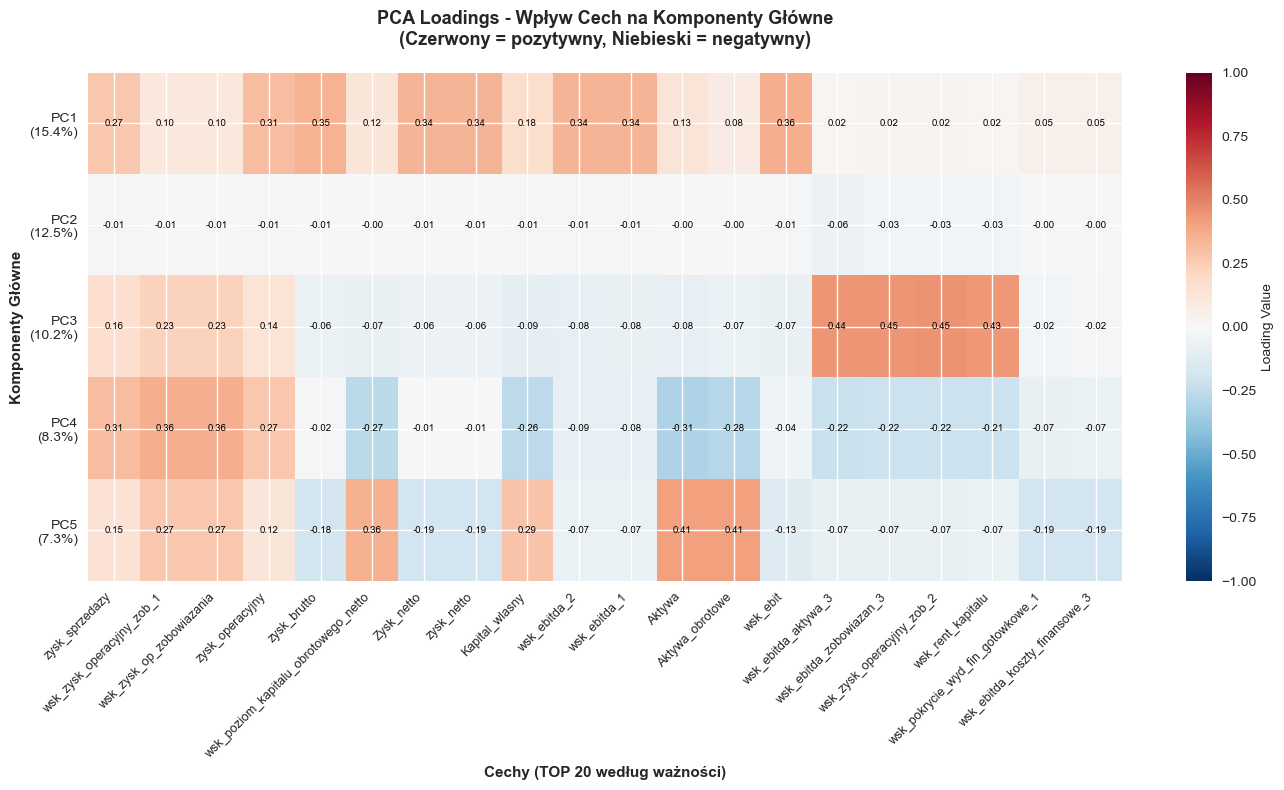


💡 INTERPRETACJA LOADINGS:
   • Wysokie wartości (czerwone/niebieskie) = cecha silnie wpływa na komponent
   • Wartości bliskie 0 (białe) = cecha słabo wpływa na komponent
   • Znak (+/-) pokazuje kierunek wpływu
   • PC1 (pierwszy komponent) jest najważniejszy - wyjaśnia najwięcej wariancji



In [128]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

print("="*100)
print("📊 WIZUALIZACJA PCA LOADINGS - Wpływ Cech na Komponenty")
print("="*100)

# Sprawdź czy poprzednia analiza została wykonana
if 'pca_full_fs' not in dir() or 'pca_importance_df' not in dir():
    print("\n⚠️  Najpierw wykonuję analizę PCA...")
    
    # Przygotuj dane
    if 'X_train_imputed' not in dir():
        raise NameError("⚠️  Najpierw uruchom poprzednie komórki aby utworzyć X_train_imputed")
    
    scaler_temp = StandardScaler()
    X_train_scaled_temp = scaler_temp.fit_transform(X_train_imputed)
    
    # PCA
    pca_full_fs = PCA()
    pca_full_fs.fit(X_train_scaled_temp)
    
    # Loadings
    n_top_components = min(10, pca_full_fs.n_components_)
    loadings = pca_full_fs.components_[:n_top_components, :]
    
    # Feature importance
    feature_importance_pca = np.zeros(X_train_scaled_temp.shape[1])
    for i in range(n_top_components):
        weight = pca_full_fs.explained_variance_ratio_[i]
        feature_importance_pca += np.abs(loadings[i, :]) * weight
    
    # Feature names
    if 'selected_features_enhanced' in dir():
        feature_names = selected_features_enhanced
    else:
        feature_names = [f"Feature_{i}" for i in range(X_train_scaled_temp.shape[1])]
    
    pca_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'PCA_Importance': feature_importance_pca
    }).sort_values('PCA_Importance', ascending=False)
    
    print(f"   ✅ Analiza PCA zakończona")
else:
    # Użyj istniejących danych
    n_top_components = min(10, pca_full_fs.n_components_)
    loadings = pca_full_fs.components_[:n_top_components, :]
    if 'feature_names' not in dir():
        if 'selected_features_enhanced' in dir():
            feature_names = selected_features_enhanced
        else:
            feature_names = [f"Feature_{i}" for i in range(pca_full_fs.n_features_in_)]

# Heatmapa loadings dla pierwszych 5 PC i TOP 20 cech
n_components_show = min(5, n_top_components)
n_features_show = 20

# Wybierz TOP 20 cech z analizy
top_features_indices = pca_importance_df.head(n_features_show).index.tolist()
top_feature_names = [feature_names[i] for i in top_features_indices]
loadings_subset = loadings[:n_components_show, top_features_indices]

# Heatmapa
fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(loadings_subset, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Etykiety
ax.set_xticks(np.arange(n_features_show))
ax.set_yticks(np.arange(n_components_show))
ax.set_xticklabels(top_feature_names, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels([f'PC{i+1}\n({pca_full_fs.explained_variance_ratio_[i]:.1%})' 
                     for i in range(n_components_show)], fontsize=10)

# Dodaj wartości w komórkach
for i in range(n_components_show):
    for j in range(n_features_show):
        text = ax.text(j, i, f'{loadings_subset[i, j]:.2f}',
                      ha="center", va="center", color="black" if abs(loadings_subset[i, j]) < 0.5 else "white",
                      fontsize=7)

ax.set_title('PCA Loadings - Wpływ Cech na Komponenty Główne\n(Czerwony = pozytywny, Niebieski = negatywny)', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Cechy (TOP 20 według ważności)', fontsize=11, fontweight='bold')
ax.set_ylabel('Komponenty Główne', fontsize=11, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Loading Value', fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACJA LOADINGS:")
print("   • Wysokie wartości (czerwone/niebieskie) = cecha silnie wpływa na komponent")
print("   • Wartości bliskie 0 (białe) = cecha słabo wpływa na komponent")
print("   • Znak (+/-) pokazuje kierunek wpływu")
print("   • PC1 (pierwszy komponent) jest najważniejszy - wyjaśnia najwięcej wariancji")

print("\n" + "="*100)

### 18.1.6. Wizualizacja Loadings - Które cechy wpływają na główne komponenty?

In [129]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

print("="*100)
print("🔍 SELEKCJA ZMIENNYCH NA PODSTAWIE ANALIZY PCA")
print("="*100)

print("""
💡 STRATEGIA:
   PCA nie wybiera oryginalnych zmiennych, ALE możemy użyć:
   
   1️⃣  LOADINGS (wagi cech w komponentach głównych)
       → Pokazują które oryginalne cechy najbardziej wpływają na PC
       → Cechy z wysokimi loadings są "ważne"
   
   2️⃣  CUMULATIVE VARIANCE
       → Wybieramy cechy które mają największy wkład w pierwsze PC
   
   3️⃣  ZACHOWANIE INTERPRETOWALNOŚCI
       → Zamiast używać PC, wybieramy TOP cechy z wysokimi loadings
""")

# Sprawdź czy mamy przygotowane dane
if 'X_train_imputed' not in dir():
    raise NameError("⚠️  Najpierw uruchom poprzednie komórki aby utworzyć X_train_imputed")

# Standaryzacja
print("\n🔹 Krok 1: Standaryzacja i PCA...")
scaler_feature_sel = StandardScaler()
X_train_scaled_fs = scaler_feature_sel.fit_transform(X_train_imputed)

# PCA na wszystkich komponentach
pca_full_fs = PCA()
pca_full_fs.fit(X_train_scaled_fs)

print(f"   ✅ PCA wykonane na {X_train_scaled_fs.shape[1]} cechach")

# Analiza loadings dla pierwszych kilku komponentów
print("\n🔹 Krok 2: Analiza LOADINGS (wagi cech)...")

# Wybierz TOP N komponentów (np. pierwsze 10 PC które wyjaśniają najwięcej)
n_top_components = min(10, pca_full_fs.n_components_)
cumvar_top = np.sum(pca_full_fs.explained_variance_ratio_[:n_top_components])

print(f"   Analizujemy pierwsze {n_top_components} komponentów")
print(f"   Wyjaśniają one łącznie: {cumvar_top:.2%} wariancji")

# Macierz loadings (komponenty x cechy)
loadings = pca_full_fs.components_[:n_top_components, :]

# Oblicz ważność każdej cechy jako sumę kwadratów loadings (ważoną wariancją)
feature_importance_pca = np.zeros(X_train_scaled_fs.shape[1])

for i in range(n_top_components):
    # Wagi ważone wariancją wyjaśnianą przez komponent
    weight = pca_full_fs.explained_variance_ratio_[i]
    feature_importance_pca += np.abs(loadings[i, :]) * weight

# Utwórz DataFrame z wynikami
if 'X_train_selected' in dir() and 'selected_features_enhanced' in dir():
    feature_names = selected_features_enhanced
else:
    feature_names = [f"Feature_{i}" for i in range(X_train_scaled_fs.shape[1])]

pca_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'PCA_Importance': feature_importance_pca
}).sort_values('PCA_Importance', ascending=False)

print("\n📊 TOP 30 Najważniejszych Cech (według PCA Loadings):")
print(pca_importance_df.head(30).to_string(index=False))

# Wybierz TOP cechy
top_n_features = 30
selected_features_pca = pca_importance_df.head(top_n_features)['Feature'].tolist()

print(f"\n✅ Wybrano TOP {top_n_features} cech na podstawie PCA importance")

print("\n" + "="*100)

🔍 SELEKCJA ZMIENNYCH NA PODSTAWIE ANALIZY PCA

💡 STRATEGIA:
   PCA nie wybiera oryginalnych zmiennych, ALE możemy użyć:
   
   1️⃣  LOADINGS (wagi cech w komponentach głównych)
       → Pokazują które oryginalne cechy najbardziej wpływają na PC
       → Cechy z wysokimi loadings są "ważne"
   
   2️⃣  CUMULATIVE VARIANCE
       → Wybieramy cechy które mają największy wkład w pierwsze PC
   
   3️⃣  ZACHOWANIE INTERPRETOWALNOŚCI
       → Zamiast używać PC, wybieramy TOP cechy z wysokimi loadings


🔹 Krok 1: Standaryzacja i PCA...
   ✅ PCA wykonane na 40 cechach

🔹 Krok 2: Analiza LOADINGS (wagi cech)...
   Analizujemy pierwsze 10 komponentów
   Wyjaśniają one łącznie: 75.87% wariancji

📊 TOP 30 Najważniejszych Cech (według PCA Loadings):
                             Feature  PCA_Importance
                      zysk_sprzedazy        0.103801
           wsk_zysk_operacyjny_zob_1        0.100777
            wsk_zysk_op_zobowiazania        0.100777
                     zysk_operacyjny     

### 18.1.5. Wykorzystanie PCA do Selekcji Zmiennych (Feature Selection)

### 18.1.4. Opcjonalnie: Model z PCA jako Preprocessing

🎨 t-SNE - Nieliniowa Wizualizacja

⚠️  UWAGA: t-SNE jest wolny dla dużych zbiorów!
   • Używamy próbki max 5000 obserwacji
   • t-SNE nie ma transform() - tylko dla wizualizacji
   • Perplexity = 30 (typowa wartość)


🔄 Trenowanie t-SNE (może potrwać ~1-2 min)...
✅ t-SNE zakończone!
✅ t-SNE zakończone!


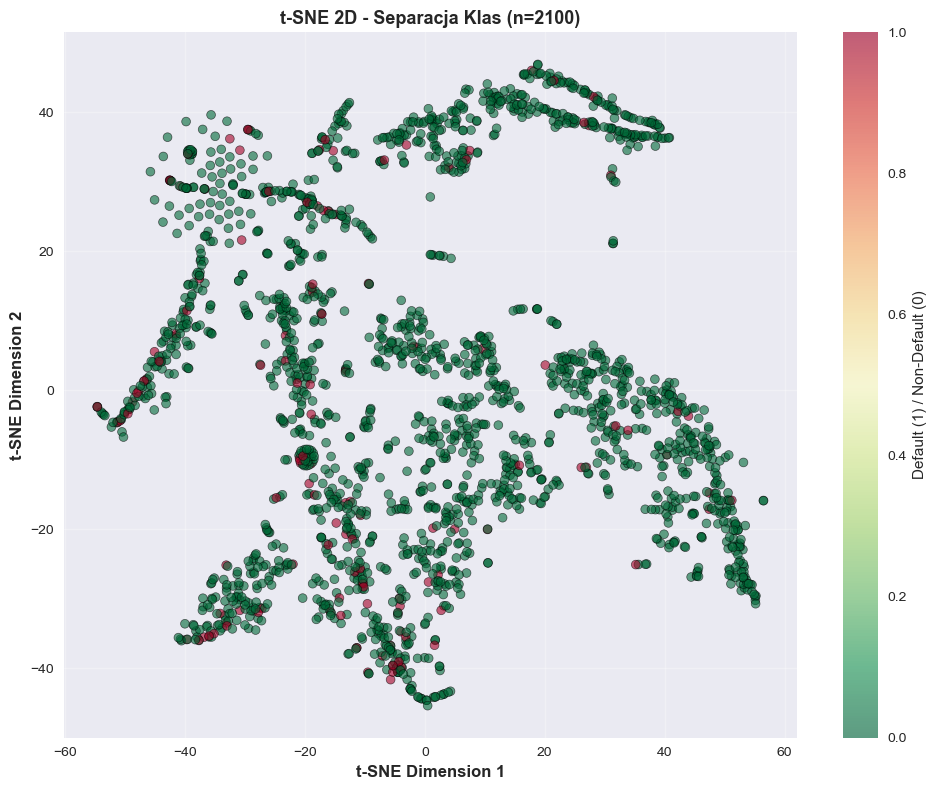


💡 INTERPRETACJA t-SNE:
   • t-SNE lepiej pokazuje lokalne struktury i skupiska
   • Odległości między skupiskami NIE są porównywalne
   • Używaj tylko do wizualizacji, NIE jako preprocessing!



In [130]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

print("="*100)
print("🎨 t-SNE - Nieliniowa Wizualizacja")
print("="*100)

print("""
⚠️  UWAGA: t-SNE jest wolny dla dużych zbiorów!
   • Używamy próbki max 5000 obserwacji
   • t-SNE nie ma transform() - tylko dla wizualizacji
   • Perplexity = 30 (typowa wartość)
""")

# Sprawdź czy dane są standaryzowane, jeśli nie - standaryzuj
if 'X_train_scaled_pca' not in dir():
    if 'X_train_imputed' not in dir():
        raise NameError("⚠️  Najpierw uruchom poprzednie komórki aby utworzyć X_train_imputed")
    print("\n🔹 Standaryzacja danych dla t-SNE...")
    scaler_tsne = StandardScaler()
    X_train_scaled_pca = scaler_tsne.fit_transform(X_train_imputed)
    print(f"   ✅ Dane przeskalowane: {X_train_scaled_pca.shape}")

# Ogranicz rozmiar próbki dla t-SNE
max_samples_tsne = 5000
if len(X_train_scaled_pca) > max_samples_tsne:
    print(f"\n🔹 Losowanie {max_samples_tsne} próbek z {len(X_train_scaled_pca)} obserwacji...")
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_train_scaled_pca), max_samples_tsne, replace=False)
    X_tsne_sample = X_train_scaled_pca[sample_indices]
    y_tsne_sample = y_train.iloc[sample_indices]
else:
    X_tsne_sample = X_train_scaled_pca
    y_tsne_sample = y_train

print(f"\n🔄 Trenowanie t-SNE (może potrwać ~1-2 min)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, verbose=0)
X_tsne_2d = tsne.fit_transform(X_tsne_sample)

print(f"✅ t-SNE zakończone!")

# Wizualizacja t-SNE
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

scatter = ax.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], 
                     c=y_tsne_sample, cmap='RdYlGn_r', alpha=0.6, s=40, edgecolors='k', linewidth=0.5)
ax.set_xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
ax.set_title(f't-SNE 2D - Separacja Klas (n={len(X_tsne_sample)})', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Default (1) / Non-Default (0)', fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACJA t-SNE:")
print("   • t-SNE lepiej pokazuje lokalne struktury i skupiska")
print("   • Odległości między skupiskami NIE są porównywalne")
print("   • Używaj tylko do wizualizacji, NIE jako preprocessing!")

print("\n" + "="*100)

### 18.1.3. t-SNE - Nieliniowa Redukcja Wymiarowości

📊 WIZUALIZACJA PCA 2D - Separacja Klas

✅ Redukcja do 2D:
   Wyjaśniona wariancja PC1: 15.39%
   Wyjaśniona wariancja PC2: 12.52%
   Łącznie: 27.91%


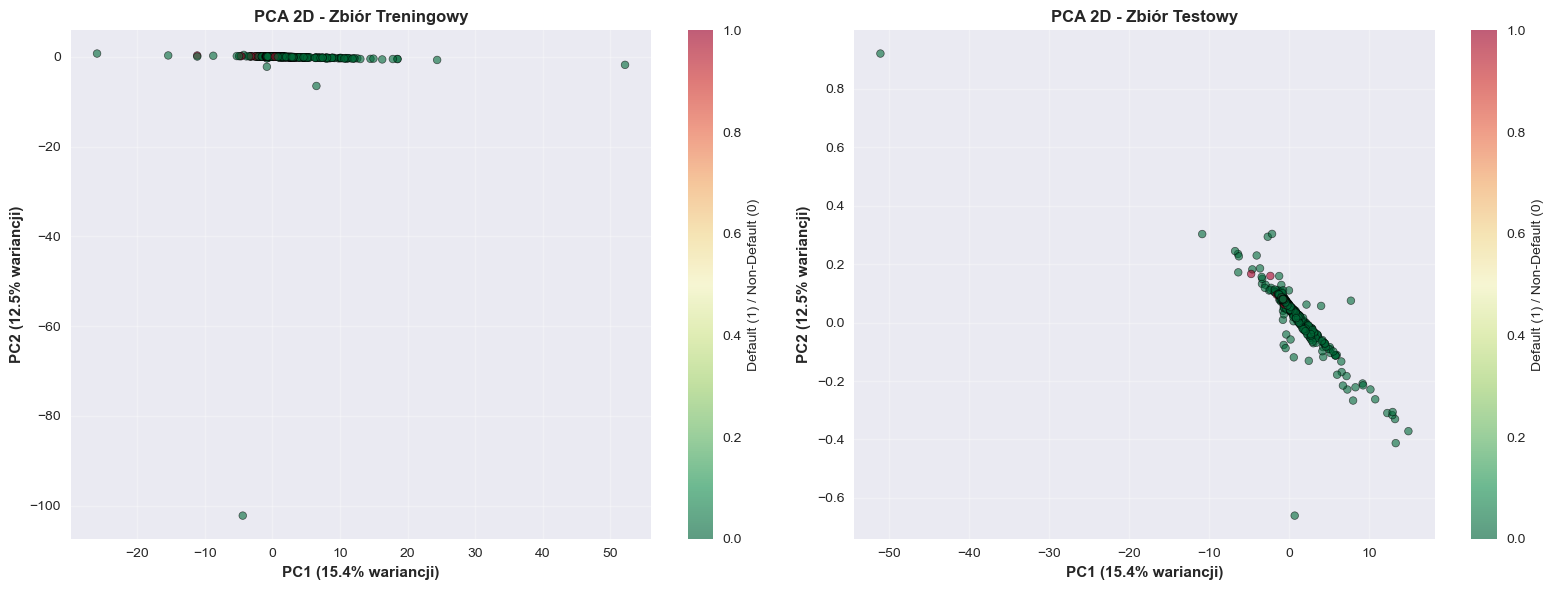


💡 INTERPRETACJA:
   • Punkty CZERWONE = Default (klasa 1)
   • Punkty ZIELONE = Non-Default (klasa 0)
   • Im lepsze rozdzielenie kolorów, tym łatwiejsza klasyfikacja



In [131]:
print("="*100)
print("📊 WIZUALIZACJA PCA 2D - Separacja Klas")
print("="*100)

# PCA do 2 komponentów dla wizualizacji
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled_pca)
X_test_pca_2d = pca_2d.transform(X_test_scaled_pca)

print(f"\n✅ Redukcja do 2D:")
print(f"   Wyjaśniona wariancja PC1: {pca_2d.explained_variance_ratio_[0]:.2%}")
print(f"   Wyjaśniona wariancja PC2: {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"   Łącznie: {pca_2d.explained_variance_ratio_.sum():.2%}")

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Training Data
scatter_train = axes[0].scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], 
                                c=y_train, cmap='RdYlGn_r', alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} wariancji)', fontsize=11, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} wariancji)', fontsize=11, fontweight='bold')
axes[0].set_title('PCA 2D - Zbiór Treningowy', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
cbar1 = plt.colorbar(scatter_train, ax=axes[0])
cbar1.set_label('Default (1) / Non-Default (0)', fontsize=10)

# Plot 2: Test Data
scatter_test = axes[1].scatter(X_test_pca_2d[:, 0], X_test_pca_2d[:, 1], 
                               c=y_test, cmap='RdYlGn_r', alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} wariancji)', fontsize=11, fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} wariancji)', fontsize=11, fontweight='bold')
axes[1].set_title('PCA 2D - Zbiór Testowy', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
cbar2 = plt.colorbar(scatter_test, ax=axes[1])
cbar2.set_label('Default (1) / Non-Default (0)', fontsize=10)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACJA:")
print("   • Punkty CZERWONE = Default (klasa 1)")
print("   • Punkty ZIELONE = Non-Default (klasa 0)")
print("   • Im lepsze rozdzielenie kolorów, tym łatwiejsza klasyfikacja")

print("\n" + "="*100)

### 18.1.2. Wizualizacja PCA 2D

📐 PCA - Principal Component Analysis

🔹 Krok 1: Standaryzacja danych...
   ✅ Dane przeskalowane: (2100, 40)

🔹 Krok 2: Analiza wariancji wyjaśnianej...

📊 Liczba komponentów potrzebnych do wyjaśnienia:
   85% wariancji: 14 komponentów (z 40)
   90% wariancji: 16 komponentów
   95% wariancji: 18 komponentów


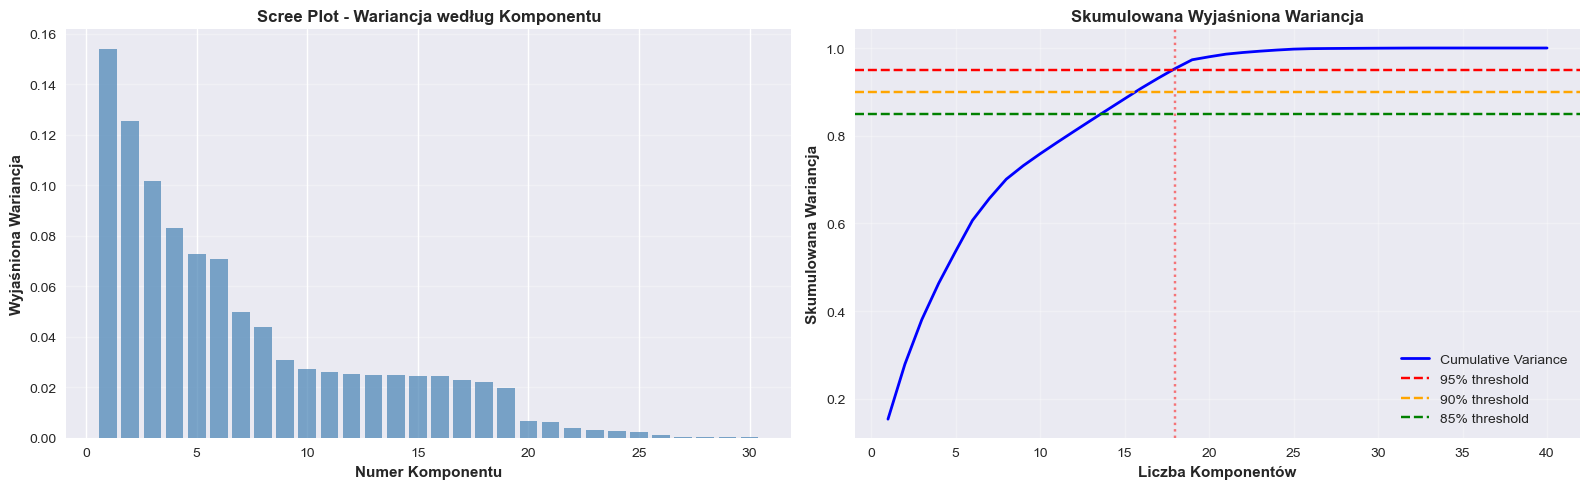

In [132]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

print("="*100)
print("📐 PCA - Principal Component Analysis")
print("="*100)

# Standaryzacja (PCA wymaga standaryzacji!)
print("\n🔹 Krok 1: Standaryzacja danych...")
scaler_pca = StandardScaler()
X_train_scaled_pca = scaler_pca.fit_transform(X_train_imputed)
X_test_scaled_pca = scaler_pca.transform(X_test_imputed)

print(f"   ✅ Dane przeskalowane: {X_train_scaled_pca.shape}")

# Analiza wariancji wyjaśnianej
print("\n🔹 Krok 2: Analiza wariancji wyjaśnianej...")
pca_full = PCA()
pca_full.fit(X_train_scaled_pca)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Znajdź liczbę komponentów dla 95% wariancji
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

print(f"\n📊 Liczba komponentów potrzebnych do wyjaśnienia:")
print(f"   85% wariancji: {n_components_85} komponentów (z {X_train_scaled_pca.shape[1]})")
print(f"   90% wariancji: {n_components_90} komponentów")
print(f"   95% wariancji: {n_components_95} komponentów")

# Wykres Scree Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Explained Variance Ratio
axes[0].bar(range(1, min(31, len(pca_full.explained_variance_ratio_)+1)), 
            pca_full.explained_variance_ratio_[:30], 
            alpha=0.7, color='steelblue')
axes[0].set_xlabel('Numer Komponentu', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Wyjaśniona Wariancja', fontsize=11, fontweight='bold')
axes[0].set_title('Scree Plot - Wariancja według Komponentu', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Cumulative Variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 
            'b-', linewidth=2, label='Cumulative Variance')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
axes[1].axhline(y=0.85, color='g', linestyle='--', label='85% threshold')
axes[1].axvline(x=n_components_95, color='r', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Liczba Komponentów', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Skumulowana Wariancja', fontsize=11, fontweight='bold')
axes[1].set_title('Skumulowana Wyjaśniona Wariancja', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*100)

### 18.1.1. PCA - Analiza Głównych Składowych

In [133]:
print("="*100)
print("🔬 REDUKCJA WYMIAROWOŚCI - PCA i t-SNE")
print("="*100)

print("""
📊 CEL ANALIZY:
   1. Wizualizacja separacji klas w przestrzeni 2D/3D
   2. Analiza wariancji wyjaśnianej przez komponenty PCA
   3. Opcjonalne: użycie PCA jako preprocessing przed modelami
   
🎯 ZASTOSOWANIA:
   • PCA - liniowa redukcja wymiarowości, zachowuje wariancję
   • t-SNE - nieliniowa, lepsza wizualizacja skupisk (ale wolniejsza)
""")

🔬 REDUKCJA WYMIAROWOŚCI - PCA i t-SNE

📊 CEL ANALIZY:
   1. Wizualizacja separacji klas w przestrzeni 2D/3D
   2. Analiza wariancji wyjaśnianej przez komponenty PCA
   3. Opcjonalne: użycie PCA jako preprocessing przed modelami
   
🎯 ZASTOSOWANIA:
   • PCA - liniowa redukcja wymiarowości, zachowuje wariancję
   • t-SNE - nieliniowa, lepsza wizualizacja skupisk (ale wolniejsza)



## 18.1. Redukcja Wymiarowości: PCA i t-SNE

## 23. 🔍 Analiza Nieskończoności (±inf) w Danych

In [134]:
import numpy as np
import pandas as pd

print("="*100)
print("🔍 ANALIZA NIESKOŃCZONOŚCI (±inf) W DANYCH")
print("="*100)

# Sprawdź który DataFrame analizować
if 'df' in dir():
    data = df.copy()
    data_name = "df (oryginalny zbiór)"
elif 'df_enhanced' in dir():
    data = df_enhanced[0].copy() if isinstance(df_enhanced, tuple) else df_enhanced.copy()
    data_name = "df_enhanced (z banking features)"
else:
    raise NameError("⚠️  Brak danych do analizy. Uruchom poprzednie komórki.")

print(f"\n📊 Analizuję: {data_name}")
print(f"   Rozmiar: {data.shape[0]:,} wierszy × {data.shape[1]:,} kolumn")

# Oddziel target od features
if 'default' in data.columns:
    y = data['default']
    X = data.drop('default', axis=1)
else:
    y = None
    X = data

print("\n" + "="*100)
print("📋 KROK 1: IDENTYFIKACJA KOLUMN Z NIESKOŃCZONOŚCIAMI")
print("="*100)

# Znajdź kolumny z inf/-inf
inf_summary = []

for col in X.columns:
    if X[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        n_pos_inf = np.sum(np.isposinf(X[col]))
        n_neg_inf = np.sum(np.isneginf(X[col]))
        n_total_inf = n_pos_inf + n_neg_inf
        
        if n_total_inf > 0:
            pct_inf = (n_total_inf / len(X)) * 100
            inf_summary.append({
                'Kolumna': col,
                '+inf': n_pos_inf,
                '-inf': n_neg_inf,
                'Razem inf': n_total_inf,
                '% inf': pct_inf
            })

if len(inf_summary) > 0:
    inf_df = pd.DataFrame(inf_summary).sort_values('Razem inf', ascending=False)
    print(f"\n✅ Znaleziono {len(inf_df)} kolumn z nieskończonościami:\n")
    print(inf_df.to_string(index=False))
    
    print(f"\n📊 STATYSTYKI OGÓLNE:")
    print(f"   Całkowita liczba nieskończoności: {inf_df['Razem inf'].sum():,}")
    print(f"   Średnio na kolumnę: {inf_df['Razem inf'].mean():.1f}")
    print(f"   Maksimum w jednej kolumnie: {inf_df['Razem inf'].max():,}")
else:
    print("\n✅ Brak nieskończoności w danych!")
    inf_df = pd.DataFrame()

print("\n" + "="*100)

🔍 ANALIZA NIESKOŃCZONOŚCI (±inf) W DANYCH

📊 Analizuję: df (oryginalny zbiór)
   Rozmiar: 3,000 wierszy × 220 kolumn

📋 KROK 1: IDENTYFIKACJA KOLUMN Z NIESKOŃCZONOŚCIAMI

✅ Znaleziono 3 kolumn z nieskończonościami:

                       Kolumna  +inf  -inf  Razem inf     % inf
           wsk_plynnosc_biez_1   906     0        906 30.200000
wsk_struktura_kap_wlasnego_s_2   103     0        103  3.433333
         wsk_kapital_do_aktywa     5     0          5  0.166667

📊 STATYSTYKI OGÓLNE:
   Całkowita liczba nieskończoności: 1,014
   Średnio na kolumnę: 338.0
   Maksimum w jednej kolumnie: 906


✅ Znaleziono 3 kolumn z nieskończonościami:

                       Kolumna  +inf  -inf  Razem inf     % inf
           wsk_plynnosc_biez_1   906     0        906 30.200000
wsk_struktura_kap_wlasnego_s_2   103     0        103  3.433333
         wsk_kapital_do_aktywa     5     0          5  0.166667

📊 STATYSTYKI OGÓLNE:
   Całkowita liczba nieskończoności: 1,014
   Średnio na kolumnę: 338.0
  

In [135]:
print("="*100)
print("📋 KROK 2: ANALIZA DEFAULTU W WIERSZACH Z NIESKOŃCZONOŚCIAMI")
print("="*100)

if len(inf_df) > 0 and y is not None:
    # Znajdź wiersze które mają JAKĄKOLWIEK nieskończoność
    has_any_inf = np.zeros(len(X), dtype=bool)
    
    for col in inf_df['Kolumna']:
        has_any_inf |= (np.isinf(X[col]))
    
    n_rows_with_inf = has_any_inf.sum()
    n_rows_without_inf = (~has_any_inf).sum()
    
    print(f"\n📊 PODZIAŁ WIERSZY:")
    print(f"   Wiersze z inf:    {n_rows_with_inf:,} ({n_rows_with_inf/len(X)*100:.2f}%)")
    print(f"   Wiersze bez inf:  {n_rows_without_inf:,} ({n_rows_without_inf/len(X)*100:.2f}%)")
    
    # Default rate w wierszach z inf vs bez inf
    default_rate_with_inf = y[has_any_inf].mean()
    default_rate_without_inf = y[~has_any_inf].mean()
    
    print(f"\n💰 DEFAULT RATE:")
    print(f"   W wierszach Z inf:     {default_rate_with_inf:.2%}")
    print(f"   W wierszach BEZ inf:   {default_rate_without_inf:.2%}")
    print(f"   Różnica:               {abs(default_rate_with_inf - default_rate_without_inf):.2%}")
    
    if default_rate_with_inf > default_rate_without_inf:
        ratio = default_rate_with_inf / default_rate_without_inf if default_rate_without_inf > 0 else float('inf')
        print(f"   ⚠️  Wiersze z inf mają {ratio:.2f}x WYŻSZE ryzyko defaultu!")
    else:
        ratio = default_rate_without_inf / default_rate_with_inf if default_rate_with_inf > 0 else float('inf')
        print(f"   ✅ Wiersze z inf mają {ratio:.2f}x NIŻSZE ryzyko defaultu")
    
    # Szczegółowa analiza dla każdego typu inf
    print(f"\n📋 SZCZEGÓŁOWA ANALIZA:")
    
    for col in inf_df['Kolumna'].head(10):  # Top 10 kolumn
        has_pos_inf = np.isposinf(X[col])
        has_neg_inf = np.isneginf(X[col])
        
        if has_pos_inf.sum() > 0:
            default_rate_pos_inf = y[has_pos_inf].mean()
            print(f"\n   📊 {col} (+inf):")
            print(f"      Liczba: {has_pos_inf.sum():,}")
            print(f"      Default rate: {default_rate_pos_inf:.2%}")
        
        if has_neg_inf.sum() > 0:
            default_rate_neg_inf = y[has_neg_inf].mean()
            print(f"\n   📊 {col} (-inf):")
            print(f"      Liczba: {has_neg_inf.sum():,}")
            print(f"      Default rate: {default_rate_neg_inf:.2%}")

elif len(inf_df) > 0 and y is None:
    print("\n⚠️  Brak kolumny 'default' - nie można analizować związku z target")
else:
    print("\n✅ Brak nieskończoności do analizy")

print("\n" + "="*100)

📋 KROK 2: ANALIZA DEFAULTU W WIERSZACH Z NIESKOŃCZONOŚCIAMI

📊 PODZIAŁ WIERSZY:
   Wiersze z inf:    934 (31.13%)
   Wiersze bez inf:  2,066 (68.87%)

💰 DEFAULT RATE:
   W wierszach Z inf:     7.17%
   W wierszach BEZ inf:   5.61%
   Różnica:               1.56%
   ⚠️  Wiersze z inf mają 1.28x WYŻSZE ryzyko defaultu!

📋 SZCZEGÓŁOWA ANALIZA:

   📊 wsk_plynnosc_biez_1 (+inf):
      Liczba: 906
      Default rate: 7.06%

   📊 wsk_struktura_kap_wlasnego_s_2 (+inf):
      Liczba: 103
      Default rate: 10.68%

   📊 wsk_kapital_do_aktywa (+inf):
      Liczba: 5
      Default rate: 0.00%



📊 KROK 3: WIZUALIZACJA


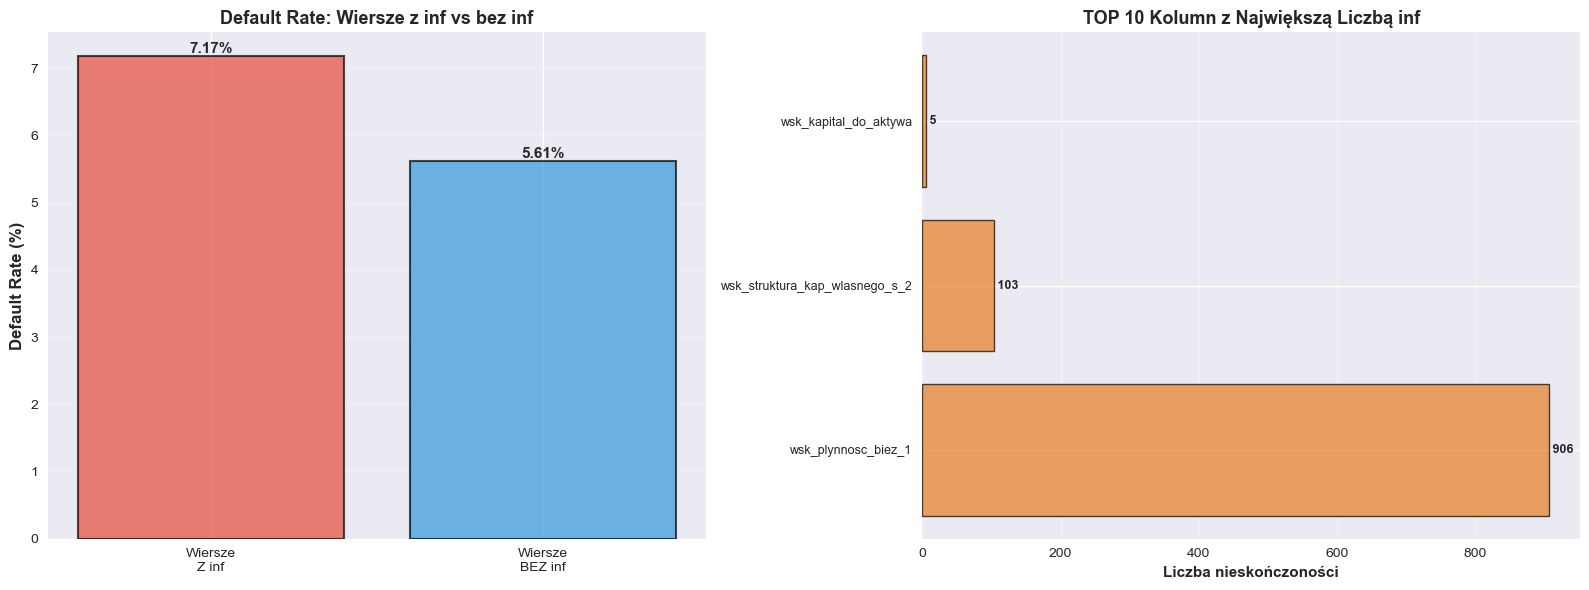

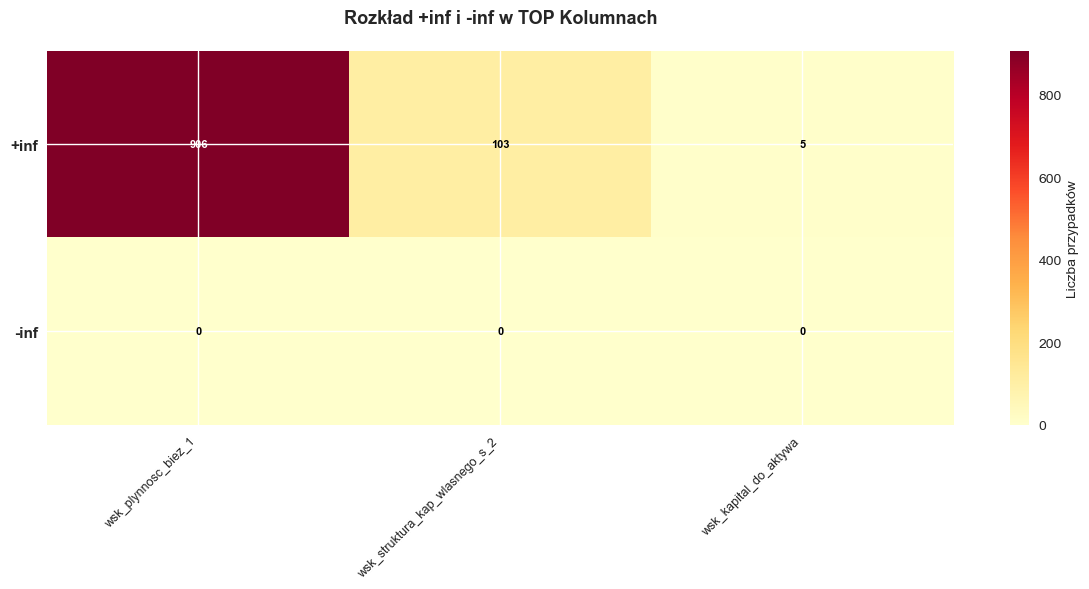


✅ ANALIZA ZAKOŃCZONA


In [136]:
import matplotlib.pyplot as plt

print("="*100)
print("📊 KROK 3: WIZUALIZACJA")
print("="*100)

if len(inf_df) > 0 and y is not None:
    # Wykres 1: Default rate - z inf vs bez inf
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Porównanie default rate
    categories = ['Wiersze\nZ inf', 'Wiersze\nBEZ inf']
    default_rates = [default_rate_with_inf * 100, default_rate_without_inf * 100]
    colors = ['#e74c3c' if default_rate_with_inf > default_rate_without_inf else '#2ecc71', '#3498db']
    
    bars = axes[0].bar(categories, default_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[0].set_ylabel('Default Rate (%)', fontsize=12, fontweight='bold')
    axes[0].set_title('Default Rate: Wiersze z inf vs bez inf', fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Dodaj wartości na słupkach
    for bar, rate in zip(bars, default_rates):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{rate:.2f}%',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 2: TOP 10 kolumn z największą liczbą inf
    top_10_cols = inf_df.head(10)
    axes[1].barh(range(len(top_10_cols)), top_10_cols['Razem inf'], 
                 color='#e67e22', alpha=0.7, edgecolor='black', linewidth=1)
    axes[1].set_yticks(range(len(top_10_cols)))
    axes[1].set_yticklabels(top_10_cols['Kolumna'], fontsize=9)
    axes[1].set_xlabel('Liczba nieskończoności', fontsize=11, fontweight='bold')
    axes[1].set_title('TOP 10 Kolumn z Największą Liczbą inf', fontsize=13, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    # Dodaj wartości
    for i, (idx, row) in enumerate(top_10_cols.iterrows()):
        axes[1].text(row['Razem inf'], i, f" {row['Razem inf']:,}", 
                    va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Wykres 2: Heatmapa inf w TOP kolumnach
    if len(inf_df) >= 3:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        top_cols = inf_df.head(min(15, len(inf_df)))['Kolumna'].tolist()
        
        # Macierz: kolumna × typ inf (+inf, -inf)
        matrix_data = []
        labels = []
        
        for col in top_cols:
            pos_inf_count = np.isposinf(X[col]).sum()
            neg_inf_count = np.isneginf(X[col]).sum()
            matrix_data.append([pos_inf_count, neg_inf_count])
            labels.append(col)
        
        matrix = np.array(matrix_data)
        
        im = ax.imshow(matrix.T, cmap='YlOrRd', aspect='auto')
        
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['+inf', '-inf'], fontsize=11, fontweight='bold')
        ax.set_title('Rozkład +inf i -inf w TOP Kolumnach', fontsize=13, fontweight='bold', pad=20)
        
        # Dodaj wartości
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                text = ax.text(i, j, f'{int(matrix[i, j]):,}',
                              ha="center", va="center", color="white" if matrix[i, j] > matrix.max()/2 else "black",
                              fontsize=8, fontweight='bold')
        
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Liczba przypadków', fontsize=10)
        
        plt.tight_layout()
        plt.show()

print("\n" + "="*100)
print("✅ ANALIZA ZAKOŃCZONA")
print("="*100)

### 💡 Interpretacja i Rekomendacje

In [137]:
print("="*100)
print("💡 INTERPRETACJA I REKOMENDACJE")
print("="*100)

if len(inf_df) > 0:
    print("""
🔍 DLACZEGO POWSTAJĄ NIESKOŃCZONOŚCI?

1️⃣  DZIELENIE PRZEZ ZERO
   Przykład: Debt_to_Assets = Zadłużenie / Aktywa
   Jeśli Aktywa = 0 → inf
   
2️⃣  LOGARYTMY Z LICZB ≤ 0
   Przykład: log(Rentowność)
   Jeśli Rentowność = 0 lub ujemna → -inf lub błąd

3️⃣  WSKAŹNIKI EKSTREMALNYCH WARTOŚCI
   Przykład: Current_Ratio = Aktywa_Obrotowe / Zobowiązania_Krótkoterminowe
   Jeśli Zobowiązania = 0 → inf


📋 REKOMENDACJE OBSŁUGI:

✅ OPCJA 1: CAP (Ograniczenie)
   • Zastąp inf → dużą wartością (np. 999 lub 99 percentyl)
   • Zastąp -inf → małą wartością (np. -999 lub 1 percentyl)
   • Zachowuje informację o "ekstremalności"

✅ OPCJA 2: IMPUTACJA
   • Zastąp inf → medianą kolumny
   • Mniej "sztuczne" niż cap

✅ OPCJA 3: USUNIĘCIE
   • Usuń wiersze z inf
   • Tylko jeśli inf jest <1% danych

✅ OPCJA 4: FEATURE ENGINEERING
   • Zamiast Debt/Assets → użyj log(1 + Debt/Assets)
   • Dodaj flagę: has_inf_in_ratio (0/1)


🎯 KTÓRĄ OPCJĘ WYBRAĆ?

Sprawdź default rate w wierszach z inf:
""")
    
    if y is not None and 'default_rate_with_inf' in dir():
        if default_rate_with_inf > default_rate_without_inf * 1.5:
            print("   ⚠️  inf ma SILNY związek z defaultem!")
            print("   → OPCJA 1 (CAP) + dodaj flagę 'has_inf'")
            print("   → Zachowaj informację że wartość była ekstremalna")
        elif abs(default_rate_with_inf - default_rate_without_inf) < 0.05:
            print("   ✅ inf NIE ma związku z defaultem")
            print("   → OPCJA 2 (IMPUTACJA) lub OPCJA 3 (USUNIĘCIE)")
        else:
            print("   ⚠️  inf ma UMIARKOWANY związek z defaultem")
            print("   → OPCJA 1 (CAP) zalecana")
    
    print("""

💻 PRZYKŁADOWY KOD (OPCJA 1 - CAP):

```python
# Dla każdej kolumny z inf
for col in inf_columns:
    # Oblicz cap values (bez inf)
    finite_values = X[col][np.isfinite(X[col])]
    cap_high = np.percentile(finite_values, 99)
    cap_low = np.percentile(finite_values, 1)
    
    # Zastąp inf
    X[col] = X[col].replace([np.inf], cap_high)
    X[col] = X[col].replace([-np.inf], cap_low)
    
    # Opcjonalnie: dodaj flagę
    X[f'{col}_was_inf'] = np.isinf(X[col]).astype(int)
```
""")

else:
    print("\n✅ Brak nieskończoności w danych - wszystko OK!")

print("\n" + "="*100)

💡 INTERPRETACJA I REKOMENDACJE

🔍 DLACZEGO POWSTAJĄ NIESKOŃCZONOŚCI?

1️⃣  DZIELENIE PRZEZ ZERO
   Przykład: Debt_to_Assets = Zadłużenie / Aktywa
   Jeśli Aktywa = 0 → inf
   
2️⃣  LOGARYTMY Z LICZB ≤ 0
   Przykład: log(Rentowność)
   Jeśli Rentowność = 0 lub ujemna → -inf lub błąd

3️⃣  WSKAŹNIKI EKSTREMALNYCH WARTOŚCI
   Przykład: Current_Ratio = Aktywa_Obrotowe / Zobowiązania_Krótkoterminowe
   Jeśli Zobowiązania = 0 → inf


📋 REKOMENDACJE OBSŁUGI:

✅ OPCJA 1: CAP (Ograniczenie)
   • Zastąp inf → dużą wartością (np. 999 lub 99 percentyl)
   • Zastąp -inf → małą wartością (np. -999 lub 1 percentyl)
   • Zachowuje informację o "ekstremalności"

✅ OPCJA 2: IMPUTACJA
   • Zastąp inf → medianą kolumny
   • Mniej "sztuczne" niż cap

✅ OPCJA 3: USUNIĘCIE
   • Usuń wiersze z inf
   • Tylko jeśli inf jest <1% danych

✅ OPCJA 4: FEATURE ENGINEERING
   • Zamiast Debt/Assets → użyj log(1 + Debt/Assets)
   • Dodaj flagę: has_inf_in_ratio (0/1)


🎯 KTÓRĄ OPCJĘ WYBRAĆ?

Sprawdź default rate w wier

## 24. 🔧 Modele z Obsługą Nieskończoności (CAP + Flagi)

### 24.1. Przygotowanie Danych z Obsługą inf (CAP Method)

In [138]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

print("="*100)
print("🔧 PRZYGOTOWANIE DANYCH Z OBSŁUGĄ NIESKOŃCZONOŚCI (CAP METHOD)")
print("="*100)

def handle_infinities_with_cap(df, percentile_high=99, percentile_low=1, add_flags=True):
    """
    Obsługuje nieskończoności używając metody CAP i opcjonalnie dodaje flagi.
    
    Parameters:
    -----------
    df : DataFrame
        Dane wejściowe
    percentile_high : int
        Percentyl dla zastąpienia +inf (domyślnie 99)
    percentile_low : int
        Percentyl dla zastąpienia -inf (domyślnie 1)
    add_flags : bool
        Czy dodać flagi informacyjne o nieskończonościach
    
    Returns:
    --------
    df_processed : DataFrame
        Dane po przetworzeniu
    inf_report : dict
        Raport z przetworzenia
    """
    df_processed = df.copy()
    inf_report = {
        'columns_with_inf': [],
        'total_inf_replaced': 0,
        'flags_added': []
    }
    
    # Znajdź kolumny z inf
    for col in df_processed.columns:
        if df_processed[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            has_pos_inf = np.isposinf(df_processed[col]).any()
            has_neg_inf = np.isneginf(df_processed[col]).any()
            
            if has_pos_inf or has_neg_inf:
                inf_report['columns_with_inf'].append(col)
                
                # Oblicz wartości cap na podstawie skończonych wartości
                finite_values = df_processed[col][np.isfinite(df_processed[col])]
                
                if len(finite_values) > 0:
                    cap_high = np.percentile(finite_values, percentile_high)
                    cap_low = np.percentile(finite_values, percentile_low)
                else:
                    cap_high = 0
                    cap_low = 0
                
                # Opcjonalnie: dodaj flagę PRZED zastąpieniem
                if add_flags:
                    flag_col = f'{col}_had_inf'
                    df_processed[flag_col] = np.isinf(df_processed[col]).astype(int)
                    inf_report['flags_added'].append(flag_col)
                
                # Zastąp inf wartościami cap
                n_pos_inf = np.isposinf(df_processed[col]).sum()
                n_neg_inf = np.isneginf(df_processed[col]).sum()
                
                df_processed[col] = df_processed[col].replace([np.inf], cap_high)
                df_processed[col] = df_processed[col].replace([-np.inf], cap_low)
                
                inf_report['total_inf_replaced'] += (n_pos_inf + n_neg_inf)
                
                print(f"   ✓ {col}: +inf={n_pos_inf} (→{cap_high:.2f}), -inf={n_neg_inf} (→{cap_low:.2f})")
    
    return df_processed, inf_report

# Przygotuj dane
print("\n📊 KROK 1: Obsługa nieskończoności w danych treningowych")
print("-" * 100)

# Użyj oryginalnych danych (przed pipeline)
if 'X_train' in dir() and 'X_test' in dir():
    X_train_inf_handled, train_report = handle_infinities_with_cap(
        X_train, 
        percentile_high=99, 
        percentile_low=1, 
        add_flags=True
    )
    
    print(f"\n📋 RAPORT TRENINGOWY:")
    print(f"   Kolumny z inf: {len(train_report['columns_with_inf'])}")
    print(f"   Zastąpiono inf: {train_report['total_inf_replaced']:,}")
    print(f"   Dodano flag: {len(train_report['flags_added'])}")
    
    print("\n📊 KROK 2: Obsługa nieskończoności w danych testowych")
    print("-" * 100)
    
    X_test_inf_handled, test_report = handle_infinities_with_cap(
        X_test, 
        percentile_high=99, 
        percentile_low=1, 
        add_flags=True
    )
    
    print(f"\n📋 RAPORT TESTOWY:")
    print(f"   Kolumny z inf: {len(test_report['columns_with_inf'])}")
    print(f"   Zastąpiono inf: {test_report['total_inf_replaced']:,}")
    print(f"   Dodano flag: {len(test_report['flags_added'])}")
    
    print(f"\n✅ Dane przygotowane:")
    print(f"   Train shape: {X_train_inf_handled.shape}")
    print(f"   Test shape: {X_test_inf_handled.shape}")
    
else:
    raise NameError("⚠️ Brak X_train i X_test. Uruchom poprzednie komórki.")

print("\n" + "="*100)

🔧 PRZYGOTOWANIE DANYCH Z OBSŁUGĄ NIESKOŃCZONOŚCI (CAP METHOD)

📊 KROK 1: Obsługa nieskończoności w danych treningowych
----------------------------------------------------------------------------------------------------
   ✓ wsk_kapital_do_aktywa: +inf=4 (→1.00), -inf=0 (→0.00)
   ✓ wsk_plynnosc_biez_1: +inf=641 (→519.24), -inf=0 (→0.00)
   ✓ wsk_struktura_kap_wlasnego_s_2: +inf=77 (→38.33), -inf=0 (→0.00)

📋 RAPORT TRENINGOWY:
   Kolumny z inf: 3
   Zastąpiono inf: 722
   Dodano flag: 3

📊 KROK 2: Obsługa nieskończoności w danych testowych
----------------------------------------------------------------------------------------------------
   ✓ wsk_kapital_do_aktywa: +inf=1 (→1.00), -inf=0 (→0.00)
   ✓ wsk_plynnosc_biez_1: +inf=265 (→1358.46), -inf=0 (→0.01)
   ✓ wsk_struktura_kap_wlasnego_s_2: +inf=26 (→41.46), -inf=0 (→-0.00)

📋 RAPORT TESTOWY:
   Kolumny z inf: 3
   Zastąpiono inf: 292
   Dodano flag: 3

✅ Dane przygotowane:
   Train shape: (2100, 222)
   Test shape: (900, 222)

   

### 24.2. Minimal Pipeline z Obsługą inf

In [140]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("="*100)
print("📊 MINIMAL PIPELINE + OBSŁUGA INF")
print("="*100)

# Zastosuj minimal preprocessing (bez usuwania inf - już obsłużone)
print("\n🔄 Aplikowanie MinimalPreprocessingPipeline...")

# Pipeline został stworzony na oryginalnych kolumnach, więc usuń kolumny z flagami przed transformacją
flag_columns = [col for col in X_train_inf_handled.columns if col.endswith('_had_inf')]
print(f"\n📋 Kolumny z flagami inf: {len(flag_columns)}")

# Rozdziel flagi od danych
X_train_inf_for_pipeline = X_train_inf_handled.drop(columns=flag_columns)
X_test_inf_for_pipeline = X_test_inf_handled.drop(columns=flag_columns)

# Zachowaj flagi osobno (jeśli chcesz je wykorzystać później)
train_inf_flags = X_train_inf_handled[flag_columns] if flag_columns else None
test_inf_flags = X_test_inf_handled[flag_columns] if flag_columns else None

if 'pipeline_minimal' in dir():
    # Transform TYLKO kolumn które pipeline zna
    X_train_minimal_inf = pipeline_minimal.transform(X_train_inf_for_pipeline)
    X_test_minimal_inf = pipeline_minimal.transform(X_test_inf_for_pipeline)
    
    print(f"✅ Dane po MinimalPreprocessingPipeline:")
    print(f"   Train shape: {X_train_minimal_inf.shape}")
    print(f"   Test shape: {X_test_minimal_inf.shape}")
    
    # Opcjonalnie: dodaj flagi z powrotem jako dodatkowe cechy
    if train_inf_flags is not None and len(flag_columns) > 0:
        X_train_minimal_inf = np.hstack([X_train_minimal_inf, train_inf_flags.values])
        X_test_minimal_inf = np.hstack([X_test_minimal_inf, test_inf_flags.values])
        print(f"   ✅ Dodano {len(flag_columns)} flag inf jako dodatkowe cechy")
        print(f"   Final shape: Train={X_train_minimal_inf.shape}, Test={X_test_minimal_inf.shape}")
    
    print(f"   Zawiera NaN: Train={np.isnan(X_train_minimal_inf).any()}, Test={np.isnan(X_test_minimal_inf).any()}")
    print(f"   Zawiera inf: Train={np.isinf(X_train_minimal_inf).any()}, Test={np.isinf(X_test_minimal_inf).any()}")
else:
    print("⚠️ pipeline_minimal nie istnieje, używam danych bez pipeline")
    X_train_minimal_inf = X_train_inf_handled.values
    X_test_minimal_inf = X_test_inf_handled.values

# Upewnij się że nie ma NaN i inf
if np.isnan(X_train_minimal_inf).any() or np.isnan(X_test_minimal_inf).any():
    print("\n⚠️ Znaleziono NaN - wypełniam medianą...")
    from sklearn.impute import SimpleImputer
    imputer_inf = SimpleImputer(strategy='median')
    X_train_minimal_inf = imputer_inf.fit_transform(X_train_minimal_inf)
    X_test_minimal_inf = imputer_inf.transform(X_test_minimal_inf)
    print("✅ NaN wypełnione")

# Słownik na wyniki
results_minimal_inf = {}

print("\n" + "="*100)
print("🎯 TRENOWANIE MODELI (MINIMAL + INF HANDLING)")
print("="*100)

📊 MINIMAL PIPELINE + OBSŁUGA INF

🔄 Aplikowanie MinimalPreprocessingPipeline...

📋 Kolumny z flagami inf: 3
✅ Dane po MinimalPreprocessingPipeline:
   Train shape: (2100, 125)
   Test shape: (900, 125)
   ✅ Dodano 3 flag inf jako dodatkowe cechy
   Final shape: Train=(2100, 128), Test=(900, 128)
   Zawiera NaN: Train=False, Test=False
   Zawiera inf: Train=False, Test=False

🎯 TRENOWANIE MODELI (MINIMAL + INF HANDLING)
✅ Dane po MinimalPreprocessingPipeline:
   Train shape: (2100, 125)
   Test shape: (900, 125)
   ✅ Dodano 3 flag inf jako dodatkowe cechy
   Final shape: Train=(2100, 128), Test=(900, 128)
   Zawiera NaN: Train=False, Test=False
   Zawiera inf: Train=False, Test=False

🎯 TRENOWANIE MODELI (MINIMAL + INF HANDLING)


In [141]:
from sklearn.linear_model import LogisticRegression

print("\n" + "="*70)
print("MODEL 1: LOGISTIC REGRESSION (Minimal + inf handling)")
print("="*70)

lr_minimal_inf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_minimal_inf.fit(X_train_minimal_inf, y_train)

y_pred_lr_minimal_inf = lr_minimal_inf.predict(X_test_minimal_inf)
y_proba_lr_minimal_inf = lr_minimal_inf.predict_proba(X_test_minimal_inf)[:, 1]

results_minimal_inf['LR'] = {
    'model': lr_minimal_inf,
    'y_pred': y_pred_lr_minimal_inf,
    'y_proba': y_proba_lr_minimal_inf,
    'accuracy': accuracy_score(y_test, y_pred_lr_minimal_inf),
    'precision': precision_score(y_test, y_pred_lr_minimal_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr_minimal_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_lr_minimal_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_lr_minimal_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal_inf['LR']['accuracy']:.4f}")
print(f"  Precision: {results_minimal_inf['LR']['precision']:.4f}")
print(f"  Recall:    {results_minimal_inf['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal_inf['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal_inf['LR']['roc_auc']:.4f}")

print("\n✅ Logistic Regression (inf handling) ukończona")


MODEL 1: LOGISTIC REGRESSION (Minimal + inf handling)

📊 Wyniki:
  Accuracy:  0.7689
  Precision: 0.1374
  Recall:    0.5273
  F1-Score:  0.2180
  ROC-AUC:   0.6905

✅ Logistic Regression (inf handling) ukończona

📊 Wyniki:
  Accuracy:  0.7689
  Precision: 0.1374
  Recall:    0.5273
  F1-Score:  0.2180
  ROC-AUC:   0.6905

✅ Logistic Regression (inf handling) ukończona


In [142]:
from sklearn.tree import DecisionTreeClassifier

print("\n" + "="*70)
print("MODEL 2: DECISION TREE (Minimal + inf handling)")
print("="*70)

dt_minimal_inf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced'
)
dt_minimal_inf.fit(X_train_minimal_inf, y_train)

y_pred_dt_minimal_inf = dt_minimal_inf.predict(X_test_minimal_inf)
y_proba_dt_minimal_inf = dt_minimal_inf.predict_proba(X_test_minimal_inf)[:, 1]

results_minimal_inf['DT'] = {
    'model': dt_minimal_inf,
    'y_pred': y_pred_dt_minimal_inf,
    'y_proba': y_proba_dt_minimal_inf,
    'accuracy': accuracy_score(y_test, y_pred_dt_minimal_inf),
    'precision': precision_score(y_test, y_pred_dt_minimal_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_dt_minimal_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_dt_minimal_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_dt_minimal_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal_inf['DT']['accuracy']:.4f}")
print(f"  Precision: {results_minimal_inf['DT']['precision']:.4f}")
print(f"  Recall:    {results_minimal_inf['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal_inf['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal_inf['DT']['roc_auc']:.4f}")

print("\n✅ Decision Tree (inf handling) ukończone")


MODEL 2: DECISION TREE (Minimal + inf handling)

📊 Wyniki:
  Accuracy:  0.4789
  Precision: 0.0893
  Recall:    0.8182
  F1-Score:  0.1610
  ROC-AUC:   0.6813

✅ Decision Tree (inf handling) ukończone


In [143]:
from sklearn.naive_bayes import GaussianNB

print("\n" + "="*70)
print("MODEL 3: NAIVE BAYES (Minimal + inf handling)")
print("="*70)

nb_minimal_inf = GaussianNB()
nb_minimal_inf.fit(X_train_minimal_inf, y_train)

y_pred_nb_minimal_inf = nb_minimal_inf.predict(X_test_minimal_inf)
y_proba_nb_minimal_inf = nb_minimal_inf.predict_proba(X_test_minimal_inf)[:, 1]

results_minimal_inf['NB'] = {
    'model': nb_minimal_inf,
    'y_pred': y_pred_nb_minimal_inf,
    'y_proba': y_proba_nb_minimal_inf,
    'accuracy': accuracy_score(y_test, y_pred_nb_minimal_inf),
    'precision': precision_score(y_test, y_pred_nb_minimal_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_nb_minimal_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_nb_minimal_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_nb_minimal_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal_inf['NB']['accuracy']:.4f}")
print(f"  Precision: {results_minimal_inf['NB']['precision']:.4f}")
print(f"  Recall:    {results_minimal_inf['NB']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal_inf['NB']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal_inf['NB']['roc_auc']:.4f}")

print("\n✅ Naive Bayes (inf handling) ukończony")


MODEL 3: NAIVE BAYES (Minimal + inf handling)

📊 Wyniki:
  Accuracy:  0.3311
  Precision: 0.0638
  Recall:    0.7273
  F1-Score:  0.1173
  ROC-AUC:   0.5347

✅ Naive Bayes (inf handling) ukończony


### 24.3. Full Pipeline z Obsługą inf

In [144]:
print("="*100)
print("📊 FULL PIPELINE + OBSŁUGA INF")
print("="*100)

# Zastosuj full preprocessing (bez usuwania inf - już obsłużone)
print("\n🔄 Aplikowanie InterpretablePreprocessingPipeline...")

# Pipeline został stworzony na oryginalnych kolumnach, więc usuń kolumny z flagami przed transformacją
if 'flag_columns' not in dir():
    flag_columns = [col for col in X_train_inf_handled.columns if col.endswith('_had_inf')]

print(f"\n📋 Kolumny z flagami inf: {len(flag_columns)}")

# Rozdziel flagi od danych (jeśli jeszcze nie zrobione)
X_train_inf_for_full = X_train_inf_handled.drop(columns=flag_columns)
X_test_inf_for_full = X_test_inf_handled.drop(columns=flag_columns)

# Zachowaj flagi osobno
train_inf_flags_full = X_train_inf_handled[flag_columns] if flag_columns else None
test_inf_flags_full = X_test_inf_handled[flag_columns] if flag_columns else None

if 'pipeline_full' in dir():
    # Transform TYLKO kolumn które pipeline zna
    X_train_full_inf = pipeline_full.transform(X_train_inf_for_full)
    X_test_full_inf = pipeline_full.transform(X_test_inf_for_full)
    
    print(f"✅ Dane po InterpretablePreprocessingPipeline:")
    print(f"   Train shape: {X_train_full_inf.shape}")
    print(f"   Test shape: {X_test_full_inf.shape}")
    
    # Opcjonalnie: dodaj flagi z powrotem jako dodatkowe cechy
    if train_inf_flags_full is not None and len(flag_columns) > 0:
        X_train_full_inf = np.hstack([X_train_full_inf, train_inf_flags_full.values])
        X_test_full_inf = np.hstack([X_test_full_inf, test_inf_flags_full.values])
        print(f"   ✅ Dodano {len(flag_columns)} flag inf jako dodatkowe cechy")
        print(f"   Final shape: Train={X_train_full_inf.shape}, Test={X_test_full_inf.shape}")
    
    print(f"   Zawiera NaN: Train={np.isnan(X_train_full_inf).any()}, Test={np.isnan(X_test_full_inf).any()}")
    print(f"   Zawiera inf: Train={np.isinf(X_train_full_inf).any()}, Test={np.isinf(X_test_full_inf).any()}")
else:
    print("⚠️ pipeline_full nie istnieje, używam danych bez pipeline")
    X_train_full_inf = X_train_inf_handled.values
    X_test_full_inf = X_test_inf_handled.values

# Upewnij się że nie ma NaN i inf
if np.isnan(X_train_full_inf).any() or np.isnan(X_test_full_inf).any():
    print("\n⚠️ Znaleziono NaN - wypełniam medianą...")
    from sklearn.impute import SimpleImputer
    imputer_full_inf = SimpleImputer(strategy='median')
    X_train_full_inf = imputer_full_inf.fit_transform(X_train_full_inf)
    X_test_full_inf = imputer_full_inf.transform(X_test_full_inf)
    print("✅ NaN wypełnione")

# Słownik na wyniki
results_full_inf = {}

print("\n" + "="*100)
print("🎯 TRENOWANIE MODELI (FULL + INF HANDLING)")
print("="*100)

📊 FULL PIPELINE + OBSŁUGA INF

🔄 Aplikowanie InterpretablePreprocessingPipeline...

📋 Kolumny z flagami inf: 3
✅ Dane po InterpretablePreprocessingPipeline:
   Train shape: (2100, 157)
   Test shape: (900, 157)
   ✅ Dodano 3 flag inf jako dodatkowe cechy
   Final shape: Train=(2100, 160), Test=(900, 160)
   Zawiera NaN: Train=False, Test=False
   Zawiera inf: Train=False, Test=False

🎯 TRENOWANIE MODELI (FULL + INF HANDLING)
✅ Dane po InterpretablePreprocessingPipeline:
   Train shape: (2100, 157)
   Test shape: (900, 157)
   ✅ Dodano 3 flag inf jako dodatkowe cechy
   Final shape: Train=(2100, 160), Test=(900, 160)
   Zawiera NaN: Train=False, Test=False
   Zawiera inf: Train=False, Test=False

🎯 TRENOWANIE MODELI (FULL + INF HANDLING)


In [145]:
print("\n" + "="*70)
print("MODEL 1: LOGISTIC REGRESSION (Full + inf handling)")
print("="*70)

lr_full_inf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_full_inf.fit(X_train_full_inf, y_train)

y_pred_lr_full_inf = lr_full_inf.predict(X_test_full_inf)
y_proba_lr_full_inf = lr_full_inf.predict_proba(X_test_full_inf)[:, 1]

results_full_inf['LR'] = {
    'model': lr_full_inf,
    'y_pred': y_pred_lr_full_inf,
    'y_proba': y_proba_lr_full_inf,
    'accuracy': accuracy_score(y_test, y_pred_lr_full_inf),
    'precision': precision_score(y_test, y_pred_lr_full_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr_full_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_lr_full_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_lr_full_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full_inf['LR']['accuracy']:.4f}")
print(f"  Precision: {results_full_inf['LR']['precision']:.4f}")
print(f"  Recall:    {results_full_inf['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_full_inf['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full_inf['LR']['roc_auc']:.4f}")

print("\n✅ Logistic Regression (Full + inf) ukończona")


MODEL 1: LOGISTIC REGRESSION (Full + inf handling)

📊 Wyniki:
  Accuracy:  0.7467
  Precision: 0.1156
  Recall:    0.4727
  F1-Score:  0.1857
  ROC-AUC:   0.6873

✅ Logistic Regression (Full + inf) ukończona


In [146]:
print("\n" + "="*70)
print("MODEL 2: DECISION TREE (Full + inf handling)")
print("="*70)

dt_full_inf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced'
)
dt_full_inf.fit(X_train_full_inf, y_train)

y_pred_dt_full_inf = dt_full_inf.predict(X_test_full_inf)
y_proba_dt_full_inf = dt_full_inf.predict_proba(X_test_full_inf)[:, 1]

results_full_inf['DT'] = {
    'model': dt_full_inf,
    'y_pred': y_pred_dt_full_inf,
    'y_proba': y_proba_dt_full_inf,
    'accuracy': accuracy_score(y_test, y_pred_dt_full_inf),
    'precision': precision_score(y_test, y_pred_dt_full_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_dt_full_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_dt_full_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_dt_full_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full_inf['DT']['accuracy']:.4f}")
print(f"  Precision: {results_full_inf['DT']['precision']:.4f}")
print(f"  Recall:    {results_full_inf['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_full_inf['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full_inf['DT']['roc_auc']:.4f}")

print("\n✅ Decision Tree (Full + inf) ukończone")


MODEL 2: DECISION TREE (Full + inf handling)

📊 Wyniki:
  Accuracy:  0.5911
  Precision: 0.0997
  Recall:    0.7091
  F1-Score:  0.1749
  ROC-AUC:   0.6734

✅ Decision Tree (Full + inf) ukończone

📊 Wyniki:
  Accuracy:  0.5911
  Precision: 0.0997
  Recall:    0.7091
  F1-Score:  0.1749
  ROC-AUC:   0.6734

✅ Decision Tree (Full + inf) ukończone


In [147]:
print("\n" + "="*70)
print("MODEL 3: NAIVE BAYES (Full + inf handling)")
print("="*70)

nb_full_inf = GaussianNB()
nb_full_inf.fit(X_train_full_inf, y_train)

y_pred_nb_full_inf = nb_full_inf.predict(X_test_full_inf)
y_proba_nb_full_inf = nb_full_inf.predict_proba(X_test_full_inf)[:, 1]

results_full_inf['NB'] = {
    'model': nb_full_inf,
    'y_pred': y_pred_nb_full_inf,
    'y_proba': y_proba_nb_full_inf,
    'accuracy': accuracy_score(y_test, y_pred_nb_full_inf),
    'precision': precision_score(y_test, y_pred_nb_full_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_nb_full_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_nb_full_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_nb_full_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full_inf['NB']['accuracy']:.4f}")
print(f"  Precision: {results_full_inf['NB']['precision']:.4f}")
print(f"  Recall:    {results_full_inf['NB']['recall']:.4f}")
print(f"  F1-Score:  {results_full_inf['NB']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full_inf['NB']['roc_auc']:.4f}")

print("\n✅ Naive Bayes (Full + inf) ukończony")


MODEL 3: NAIVE BAYES (Full + inf handling)

📊 Wyniki:
  Accuracy:  0.2789
  Precision: 0.0658
  Recall:    0.8182
  F1-Score:  0.1218
  ROC-AUC:   0.5325

✅ Naive Bayes (Full + inf) ukończony


### 24.4. Porównanie: Oryginalne vs inf Handling

📊 PORÓWNANIE: ORYGINALNE vs INF HANDLING

📋 TABELA PORÓWNAWCZA:
Pipeline Model     Approach  F1-Score   Recall  Precision  ROC-AUC
 Minimal    LR     Original  0.210526 0.509091   0.132701 0.689446
 Minimal    LR inf Handling  0.218045 0.527273   0.137441 0.690479
 Minimal    DT     Original  0.161002 0.818182   0.089286 0.672544
 Minimal    DT inf Handling  0.161002 0.818182   0.089286 0.681259
 Minimal    NB     Original  0.117994 0.727273   0.064205 0.534363
 Minimal    NB inf Handling  0.117302 0.727273   0.063796 0.534653
    Full    LR     Original  0.186380 0.472727   0.116071 0.686584
    Full    LR inf Handling  0.185714 0.472727   0.115556 0.687337
    Full    DT     Original  0.174888 0.709091   0.099744 0.672523
    Full    DT inf Handling  0.174888 0.709091   0.099744 0.673384


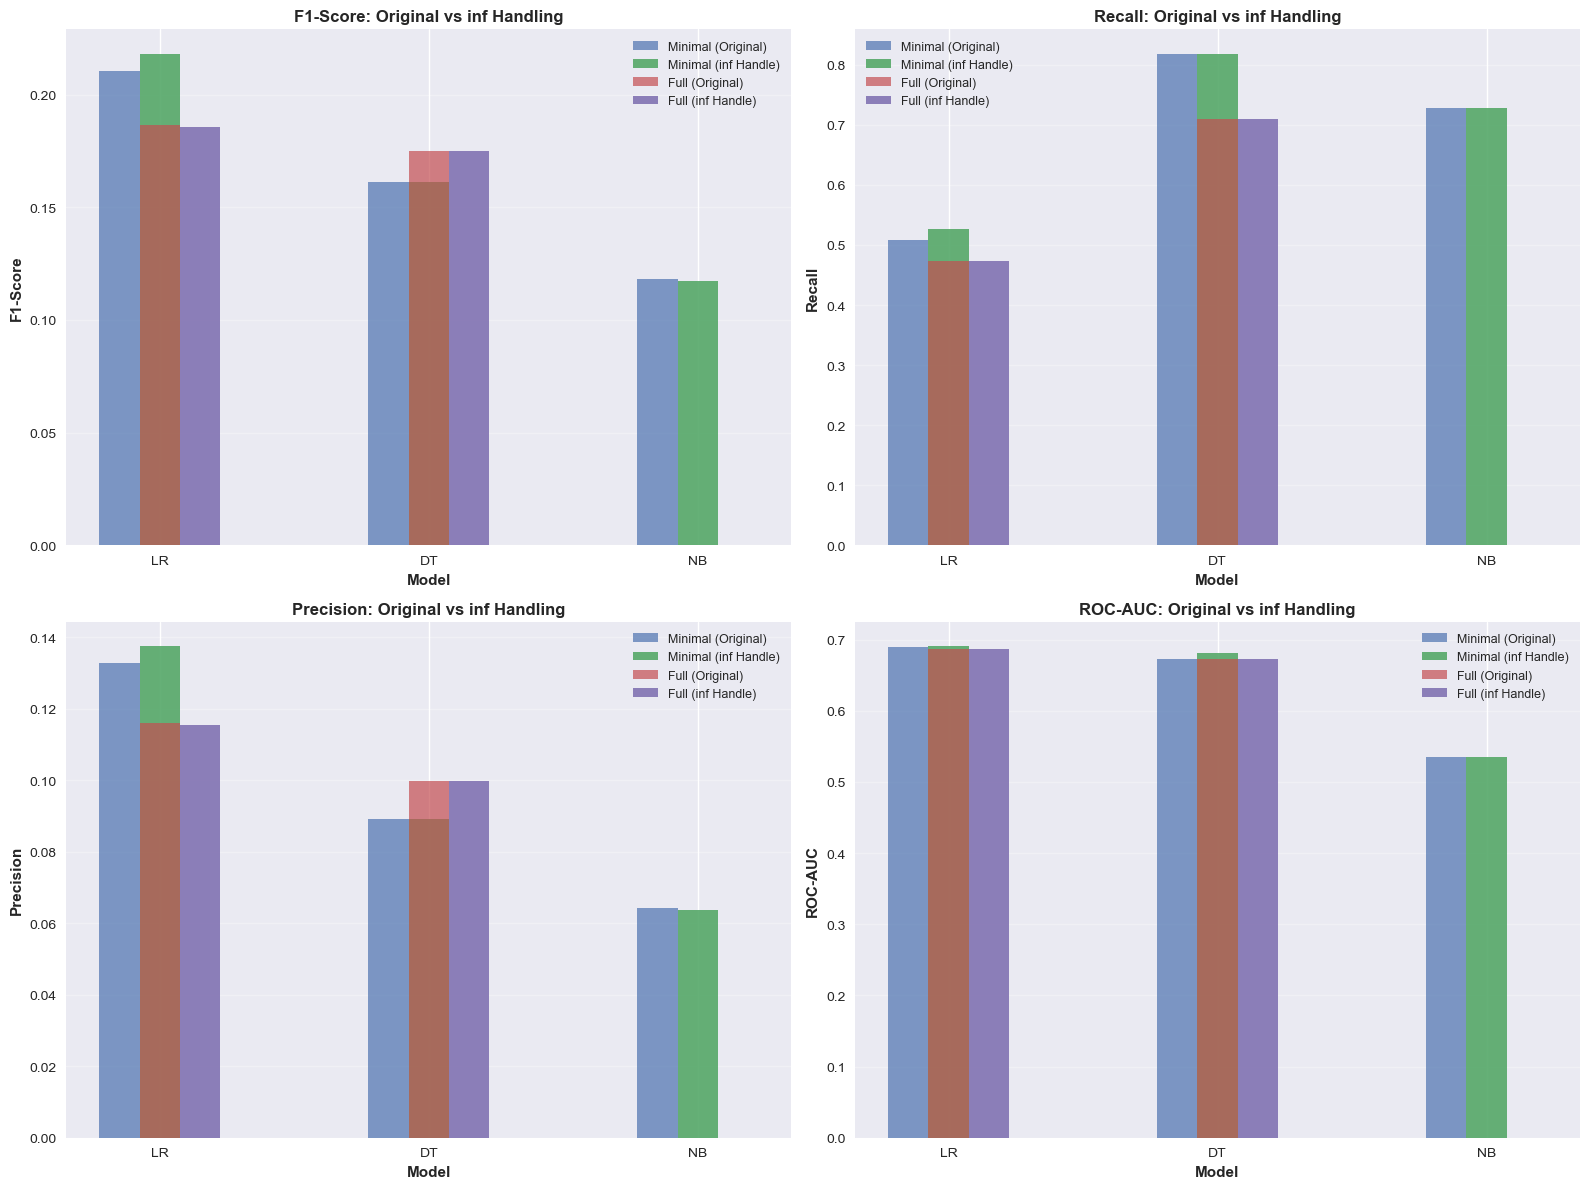


📈 ANALIZA RÓŻNIC (inf Handling - Original)

📊 Minimal Pipeline:

   LR:
      F1-Score:  0.2105 → 0.2180 (+0.0075)
      Recall:    0.5091 → 0.5273 (+0.0182)
      Precision: 0.1327 → 0.1374 (+0.0047)
      ROC-AUC:   0.6894 → 0.6905 (+0.0010)

   DT:
      F1-Score:  0.1610 → 0.1610 (+0.0000)
      Recall:    0.8182 → 0.8182 (+0.0000)
      Precision: 0.0893 → 0.0893 (+0.0000)
      ROC-AUC:   0.6725 → 0.6813 (+0.0087)

   NB:
      F1-Score:  0.1180 → 0.1173 (-0.0007)
      Recall:    0.7273 → 0.7273 (+0.0000)
      Precision: 0.0642 → 0.0638 (-0.0004)
      ROC-AUC:   0.5344 → 0.5347 (+0.0003)

📊 Full Pipeline:

   LR:
      F1-Score:  0.1864 → 0.1857 (-0.0007)
      Recall:    0.4727 → 0.4727 (+0.0000)
      Precision: 0.1161 → 0.1156 (-0.0005)
      ROC-AUC:   0.6866 → 0.6873 (+0.0008)

   DT:
      F1-Score:  0.1749 → 0.1749 (+0.0000)
      Recall:    0.7091 → 0.7091 (+0.0000)
      Precision: 0.0997 → 0.0997 (+0.0000)
      ROC-AUC:   0.6725 → 0.6734 (+0.0009)

✅ PORÓWNANIE ZAK

In [149]:
import matplotlib.pyplot as plt

print("="*100)
print("📊 PORÓWNANIE: ORYGINALNE vs INF HANDLING")
print("="*100)

# Przygotuj dane do porównania
comparison_inf_data = []

# Minimal Pipeline
if 'results_minimal' in dir() and 'results_minimal_inf' in dir():
    for model_name in ['LR', 'DT', 'NB']:
        if model_name in results_minimal and model_name in results_minimal_inf:
            comparison_inf_data.append({
                'Pipeline': 'Minimal',
                'Model': model_name,
                'Approach': 'Original',
                'F1-Score': results_minimal[model_name].get('f1', 0),
                'Recall': results_minimal[model_name].get('recall', 0),
                'Precision': results_minimal[model_name].get('precision', 0),
                'ROC-AUC': results_minimal[model_name].get('roc_auc', results_minimal[model_name].get('auc', 0))
            })
            comparison_inf_data.append({
                'Pipeline': 'Minimal',
                'Model': model_name,
                'Approach': 'inf Handling',
                'F1-Score': results_minimal_inf[model_name].get('f1', 0),
                'Recall': results_minimal_inf[model_name].get('recall', 0),
                'Precision': results_minimal_inf[model_name].get('precision', 0),
                'ROC-AUC': results_minimal_inf[model_name].get('roc_auc', results_minimal_inf[model_name].get('auc', 0))
            })

# Full Pipeline
if 'results_full' in dir() and 'results_full_inf' in dir():
    for model_name in ['LR', 'DT']:
        if model_name in results_full and model_name in results_full_inf:
            comparison_inf_data.append({
                'Pipeline': 'Full',
                'Model': model_name,
                'Approach': 'Original',
                'F1-Score': results_full[model_name].get('f1', 0),
                'Recall': results_full[model_name].get('recall', 0),
                'Precision': results_full[model_name].get('precision', 0),
                'ROC-AUC': results_full[model_name].get('roc_auc', results_full[model_name].get('auc', 0))
            })
            comparison_inf_data.append({
                'Pipeline': 'Full',
                'Model': model_name,
                'Approach': 'inf Handling',
                'F1-Score': results_full_inf[model_name].get('f1', 0),
                'Recall': results_full_inf[model_name].get('recall', 0),
                'Precision': results_full_inf[model_name].get('precision', 0),
                'ROC-AUC': results_full_inf[model_name].get('roc_auc', results_full_inf[model_name].get('auc', 0))
            })

if len(comparison_inf_data) > 0:
    comparison_inf_df = pd.DataFrame(comparison_inf_data)
    
    print("\n📋 TABELA PORÓWNAWCZA:")
    print(comparison_inf_df.to_string(index=False))
    
    # Wizualizacja
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metrics = ['F1-Score', 'Recall', 'Precision', 'ROC-AUC']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        # Przygotuj dane dla wykresu
        pipelines = comparison_inf_df['Pipeline'].unique()
        models = comparison_inf_df['Model'].unique()
        
        x = np.arange(len(models))
        width = 0.15
        
        for i, pipeline in enumerate(pipelines):
            pipeline_data = comparison_inf_df[comparison_inf_df['Pipeline'] == pipeline]
            
            # Original
            original_vals = [pipeline_data[(pipeline_data['Model'] == m) & 
                                          (pipeline_data['Approach'] == 'Original')][metric].values[0] 
                           if len(pipeline_data[(pipeline_data['Model'] == m) & 
                                               (pipeline_data['Approach'] == 'Original')]) > 0 else 0
                           for m in models]
            
            # inf Handling
            inf_vals = [pipeline_data[(pipeline_data['Model'] == m) & 
                                     (pipeline_data['Approach'] == 'inf Handling')][metric].values[0]
                       if len(pipeline_data[(pipeline_data['Model'] == m) & 
                                           (pipeline_data['Approach'] == 'inf Handling')]) > 0 else 0
                       for m in models]
            
            offset = (i - len(pipelines)/2 + 0.5) * width
            ax.bar(x + offset - width/2, original_vals, width, label=f'{pipeline} (Original)', alpha=0.7)
            ax.bar(x + offset + width/2, inf_vals, width, label=f'{pipeline} (inf Handle)', alpha=0.9)
        
        ax.set_xlabel('Model', fontsize=11, fontweight='bold')
        ax.set_ylabel(metric, fontsize=11, fontweight='bold')
        ax.set_title(f'{metric}: Original vs inf Handling', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Podsumowanie różnic
    print("\n" + "="*100)
    print("📈 ANALIZA RÓŻNIC (inf Handling - Original)")
    print("="*100)
    
    for pipeline in comparison_inf_df['Pipeline'].unique():
        print(f"\n📊 {pipeline} Pipeline:")
        pipeline_data = comparison_inf_df[comparison_inf_df['Pipeline'] == pipeline]
        
        for model in pipeline_data['Model'].unique():
            model_data = pipeline_data[pipeline_data['Model'] == model]
            
            if len(model_data) == 2:
                original = model_data[model_data['Approach'] == 'Original'].iloc[0]
                inf_handle = model_data[model_data['Approach'] == 'inf Handling'].iloc[0]
                
                diff_f1 = inf_handle['F1-Score'] - original['F1-Score']
                diff_recall = inf_handle['Recall'] - original['Recall']
                diff_precision = inf_handle['Precision'] - original['Precision']
                diff_auc = inf_handle['ROC-AUC'] - original['ROC-AUC']
                
                print(f"\n   {model}:")
                print(f"      F1-Score:  {original['F1-Score']:.4f} → {inf_handle['F1-Score']:.4f} ({diff_f1:+.4f})")
                print(f"      Recall:    {original['Recall']:.4f} → {inf_handle['Recall']:.4f} ({diff_recall:+.4f})")
                print(f"      Precision: {original['Precision']:.4f} → {inf_handle['Precision']:.4f} ({diff_precision:+.4f})")
                print(f"      ROC-AUC:   {original['ROC-AUC']:.4f} → {inf_handle['ROC-AUC']:.4f} ({diff_auc:+.4f})")
else:
    print("\n⚠️ Brak danych do porównania")

print("\n" + "="*100)
print("✅ PORÓWNANIE ZAKOŃCZONE")
print("="*100)

### 24.5. Black-Box Models z Obsługą inf (Minimal Pipeline)

In [150]:
from sklearn.ensemble import RandomForestClassifier

print("="*100)
print("🌲 RANDOM FOREST (Black-Box + inf handling - Minimal)")
print("="*100)

rf_blackbox_inf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox_inf.fit(X_train_minimal_inf, y_train)

y_pred_rf_blackbox_inf = rf_blackbox_inf.predict(X_test_minimal_inf)
y_proba_rf_blackbox_inf = rf_blackbox_inf.predict_proba(X_test_minimal_inf)[:, 1]

results_minimal_inf['RF'] = {
    'model': rf_blackbox_inf,
    'y_pred': y_pred_rf_blackbox_inf,
    'y_proba': y_proba_rf_blackbox_inf,
    'accuracy': accuracy_score(y_test, y_pred_rf_blackbox_inf),
    'precision': precision_score(y_test, y_pred_rf_blackbox_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf_blackbox_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_rf_blackbox_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_rf_blackbox_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal_inf['RF']['accuracy']:.4f}")
print(f"  Precision: {results_minimal_inf['RF']['precision']:.4f}")
print(f"  Recall:    {results_minimal_inf['RF']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal_inf['RF']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal_inf['RF']['roc_auc']:.4f}")

print("\n✅ Random Forest (inf handling) ukończony")

🌲 RANDOM FOREST (Black-Box + inf handling - Minimal)

📊 Wyniki:
  Accuracy:  0.8422
  Precision: 0.1729
  Recall:    0.4182
  F1-Score:  0.2447
  ROC-AUC:   0.7623

✅ Random Forest (inf handling) ukończony

📊 Wyniki:
  Accuracy:  0.8422
  Precision: 0.1729
  Recall:    0.4182
  F1-Score:  0.2447
  ROC-AUC:   0.7623

✅ Random Forest (inf handling) ukończony


In [151]:
from sklearn.svm import SVC

print("="*100)
print("🔷 SVM (Black-Box + inf handling - Minimal)")
print("="*100)

svm_blackbox_inf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    class_weight='balanced'
)
svm_blackbox_inf.fit(X_train_minimal_inf, y_train)

y_pred_svm_blackbox_inf = svm_blackbox_inf.predict(X_test_minimal_inf)
y_proba_svm_blackbox_inf = svm_blackbox_inf.predict_proba(X_test_minimal_inf)[:, 1]

results_minimal_inf['SVM'] = {
    'model': svm_blackbox_inf,
    'y_pred': y_pred_svm_blackbox_inf,
    'y_proba': y_proba_svm_blackbox_inf,
    'accuracy': accuracy_score(y_test, y_pred_svm_blackbox_inf),
    'precision': precision_score(y_test, y_pred_svm_blackbox_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_svm_blackbox_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_svm_blackbox_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_svm_blackbox_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal_inf['SVM']['accuracy']:.4f}")
print(f"  Precision: {results_minimal_inf['SVM']['precision']:.4f}")
print(f"  Recall:    {results_minimal_inf['SVM']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal_inf['SVM']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal_inf['SVM']['roc_auc']:.4f}")

print("\n✅ SVM (inf handling) ukończony")

🔷 SVM (Black-Box + inf handling - Minimal)

📊 Wyniki:
  Accuracy:  0.8067
  Precision: 0.1210
  Recall:    0.3455
  F1-Score:  0.1792
  ROC-AUC:   0.6667

✅ SVM (inf handling) ukończony

📊 Wyniki:
  Accuracy:  0.8067
  Precision: 0.1210
  Recall:    0.3455
  F1-Score:  0.1792
  ROC-AUC:   0.6667

✅ SVM (inf handling) ukończony


In [152]:
from sklearn.neural_network import MLPClassifier

print("="*100)
print("🧠 MLP Neural Network (Black-Box + inf handling - Minimal)")
print("="*100)

mlp_blackbox_inf = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)
mlp_blackbox_inf.fit(X_train_minimal_inf, y_train)

y_pred_mlp_blackbox_inf = mlp_blackbox_inf.predict(X_test_minimal_inf)
y_proba_mlp_blackbox_inf = mlp_blackbox_inf.predict_proba(X_test_minimal_inf)[:, 1]

results_minimal_inf['MLP'] = {
    'model': mlp_blackbox_inf,
    'y_pred': y_pred_mlp_blackbox_inf,
    'y_proba': y_proba_mlp_blackbox_inf,
    'accuracy': accuracy_score(y_test, y_pred_mlp_blackbox_inf),
    'precision': precision_score(y_test, y_pred_mlp_blackbox_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_mlp_blackbox_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_mlp_blackbox_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_mlp_blackbox_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_minimal_inf['MLP']['accuracy']:.4f}")
print(f"  Precision: {results_minimal_inf['MLP']['precision']:.4f}")
print(f"  Recall:    {results_minimal_inf['MLP']['recall']:.4f}")
print(f"  F1-Score:  {results_minimal_inf['MLP']['f1']:.4f}")
print(f"  ROC-AUC:   {results_minimal_inf['MLP']['roc_auc']:.4f}")

print("\n✅ MLP (inf handling) ukończony")

🧠 MLP Neural Network (Black-Box + inf handling - Minimal)

📊 Wyniki:
  Accuracy:  0.9367
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5103

✅ MLP (inf handling) ukończony

📊 Wyniki:
  Accuracy:  0.9367
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.5103

✅ MLP (inf handling) ukończony


In [153]:
print("="*100)
print("📊 XGBOOST (Black-Box + inf handling - Minimal)")
print("="*100)

if XGBOOST_AVAILABLE:
    from xgboost import XGBClassifier
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight_inf = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_blackbox_inf = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight_inf,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    xgb_blackbox_inf.fit(X_train_minimal_inf, y_train)
    
    y_pred_xgb_blackbox_inf = xgb_blackbox_inf.predict(X_test_minimal_inf)
    y_proba_xgb_blackbox_inf = xgb_blackbox_inf.predict_proba(X_test_minimal_inf)[:, 1]
    
    results_minimal_inf['XGB'] = {
        'model': xgb_blackbox_inf,
        'y_pred': y_pred_xgb_blackbox_inf,
        'y_proba': y_proba_xgb_blackbox_inf,
        'accuracy': accuracy_score(y_test, y_pred_xgb_blackbox_inf),
        'precision': precision_score(y_test, y_pred_xgb_blackbox_inf, zero_division=0),
        'recall': recall_score(y_test, y_pred_xgb_blackbox_inf, zero_division=0),
        'f1': f1_score(y_test, y_pred_xgb_blackbox_inf, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_xgb_blackbox_inf)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  Accuracy:  {results_minimal_inf['XGB']['accuracy']:.4f}")
    print(f"  Precision: {results_minimal_inf['XGB']['precision']:.4f}")
    print(f"  Recall:    {results_minimal_inf['XGB']['recall']:.4f}")
    print(f"  F1-Score:  {results_minimal_inf['XGB']['f1']:.4f}")
    print(f"  ROC-AUC:   {results_minimal_inf['XGB']['roc_auc']:.4f}")
    
    print("\n✅ XGBoost (inf handling) ukończony")
else:
    print("\n⚠️ XGBoost nie jest zainstalowany - pomijam")

print("\n" + "="*100)

📊 XGBOOST (Black-Box + inf handling - Minimal)

📊 Wyniki:
  Accuracy:  0.9133
  Precision: 0.1290
  Recall:    0.0727
  F1-Score:  0.0930
  ROC-AUC:   0.7273

✅ XGBoost (inf handling) ukończony


📊 Wyniki:
  Accuracy:  0.9133
  Precision: 0.1290
  Recall:    0.0727
  F1-Score:  0.0930
  ROC-AUC:   0.7273

✅ XGBoost (inf handling) ukończony



### 24.6. Black-Box Models z Obsługą inf (Full Pipeline)

In [154]:
print("="*100)
print("🌲 RANDOM FOREST (Black-Box + inf handling - Full)")
print("="*100)

rf_blackbox_full_inf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox_full_inf.fit(X_train_full_inf, y_train)

y_pred_rf_blackbox_full_inf = rf_blackbox_full_inf.predict(X_test_full_inf)
y_proba_rf_blackbox_full_inf = rf_blackbox_full_inf.predict_proba(X_test_full_inf)[:, 1]

results_full_inf['RF'] = {
    'model': rf_blackbox_full_inf,
    'y_pred': y_pred_rf_blackbox_full_inf,
    'y_proba': y_proba_rf_blackbox_full_inf,
    'accuracy': accuracy_score(y_test, y_pred_rf_blackbox_full_inf),
    'precision': precision_score(y_test, y_pred_rf_blackbox_full_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_rf_blackbox_full_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_rf_blackbox_full_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_rf_blackbox_full_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full_inf['RF']['accuracy']:.4f}")
print(f"  Precision: {results_full_inf['RF']['precision']:.4f}")
print(f"  Recall:    {results_full_inf['RF']['recall']:.4f}")
print(f"  F1-Score:  {results_full_inf['RF']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full_inf['RF']['roc_auc']:.4f}")

print("\n✅ Random Forest (Full + inf) ukończony")

🌲 RANDOM FOREST (Black-Box + inf handling - Full)

📊 Wyniki:
  Accuracy:  0.8367
  Precision: 0.1714
  Recall:    0.4364
  F1-Score:  0.2462
  ROC-AUC:   0.7627

✅ Random Forest (Full + inf) ukończony

📊 Wyniki:
  Accuracy:  0.8367
  Precision: 0.1714
  Recall:    0.4364
  F1-Score:  0.2462
  ROC-AUC:   0.7627

✅ Random Forest (Full + inf) ukończony


In [155]:
print("="*100)
print("🔷 SVM (Black-Box + inf handling - Full)")
print("="*100)

svm_blackbox_full_inf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    class_weight='balanced'
)
svm_blackbox_full_inf.fit(X_train_full_inf, y_train)

y_pred_svm_blackbox_full_inf = svm_blackbox_full_inf.predict(X_test_full_inf)
y_proba_svm_blackbox_full_inf = svm_blackbox_full_inf.predict_proba(X_test_full_inf)[:, 1]

results_full_inf['SVM'] = {
    'model': svm_blackbox_full_inf,
    'y_pred': y_pred_svm_blackbox_full_inf,
    'y_proba': y_proba_svm_blackbox_full_inf,
    'accuracy': accuracy_score(y_test, y_pred_svm_blackbox_full_inf),
    'precision': precision_score(y_test, y_pred_svm_blackbox_full_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_svm_blackbox_full_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_svm_blackbox_full_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_svm_blackbox_full_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full_inf['SVM']['accuracy']:.4f}")
print(f"  Precision: {results_full_inf['SVM']['precision']:.4f}")
print(f"  Recall:    {results_full_inf['SVM']['recall']:.4f}")
print(f"  F1-Score:  {results_full_inf['SVM']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full_inf['SVM']['roc_auc']:.4f}")

print("\n✅ SVM (Full + inf) ukończony")

🔷 SVM (Black-Box + inf handling - Full)

📊 Wyniki:
  Accuracy:  0.8178
  Precision: 0.1342
  Recall:    0.3636
  F1-Score:  0.1961
  ROC-AUC:   0.6940

✅ SVM (Full + inf) ukończony

📊 Wyniki:
  Accuracy:  0.8178
  Precision: 0.1342
  Recall:    0.3636
  F1-Score:  0.1961
  ROC-AUC:   0.6940

✅ SVM (Full + inf) ukończony


In [156]:
print("="*100)
print("🧠 MLP Neural Network (Black-Box + inf handling - Full)")
print("="*100)

mlp_blackbox_full_inf = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)
mlp_blackbox_full_inf.fit(X_train_full_inf, y_train)

y_pred_mlp_blackbox_full_inf = mlp_blackbox_full_inf.predict(X_test_full_inf)
y_proba_mlp_blackbox_full_inf = mlp_blackbox_full_inf.predict_proba(X_test_full_inf)[:, 1]

results_full_inf['MLP'] = {
    'model': mlp_blackbox_full_inf,
    'y_pred': y_pred_mlp_blackbox_full_inf,
    'y_proba': y_proba_mlp_blackbox_full_inf,
    'accuracy': accuracy_score(y_test, y_pred_mlp_blackbox_full_inf),
    'precision': precision_score(y_test, y_pred_mlp_blackbox_full_inf, zero_division=0),
    'recall': recall_score(y_test, y_pred_mlp_blackbox_full_inf, zero_division=0),
    'f1': f1_score(y_test, y_pred_mlp_blackbox_full_inf, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_mlp_blackbox_full_inf)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_full_inf['MLP']['accuracy']:.4f}")
print(f"  Precision: {results_full_inf['MLP']['precision']:.4f}")
print(f"  Recall:    {results_full_inf['MLP']['recall']:.4f}")
print(f"  F1-Score:  {results_full_inf['MLP']['f1']:.4f}")
print(f"  ROC-AUC:   {results_full_inf['MLP']['roc_auc']:.4f}")

print("\n✅ MLP (Full + inf) ukończony")

🧠 MLP Neural Network (Black-Box + inf handling - Full)

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.4945

✅ MLP (Full + inf) ukończony

📊 Wyniki:
  Accuracy:  0.9389
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  ROC-AUC:   0.4945

✅ MLP (Full + inf) ukończony


In [157]:
print("="*100)
print("📊 XGBOOST (Black-Box + inf handling - Full)")
print("="*100)

if XGBOOST_AVAILABLE:
    from xgboost import XGBClassifier
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight_full_inf = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_blackbox_full_inf = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight_full_inf,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    xgb_blackbox_full_inf.fit(X_train_full_inf, y_train)
    
    y_pred_xgb_blackbox_full_inf = xgb_blackbox_full_inf.predict(X_test_full_inf)
    y_proba_xgb_blackbox_full_inf = xgb_blackbox_full_inf.predict_proba(X_test_full_inf)[:, 1]
    
    results_full_inf['XGB'] = {
        'model': xgb_blackbox_full_inf,
        'y_pred': y_pred_xgb_blackbox_full_inf,
        'y_proba': y_proba_xgb_blackbox_full_inf,
        'accuracy': accuracy_score(y_test, y_pred_xgb_blackbox_full_inf),
        'precision': precision_score(y_test, y_pred_xgb_blackbox_full_inf, zero_division=0),
        'recall': recall_score(y_test, y_pred_xgb_blackbox_full_inf, zero_division=0),
        'f1': f1_score(y_test, y_pred_xgb_blackbox_full_inf, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_xgb_blackbox_full_inf)
    }
    
    print(f"\n📊 Wyniki:")
    print(f"  Accuracy:  {results_full_inf['XGB']['accuracy']:.4f}")
    print(f"  Precision: {results_full_inf['XGB']['precision']:.4f}")
    print(f"  Recall:    {results_full_inf['XGB']['recall']:.4f}")
    print(f"  F1-Score:  {results_full_inf['XGB']['f1']:.4f}")
    print(f"  ROC-AUC:   {results_full_inf['XGB']['roc_auc']:.4f}")
    
    print("\n✅ XGBoost (Full + inf) ukończony")
else:
    print("\n⚠️ XGBoost nie jest zainstalowany - pomijam")

print("\n" + "="*100)

📊 XGBOOST (Black-Box + inf handling - Full)

📊 Wyniki:
  Accuracy:  0.9100
  Precision: 0.1579
  Recall:    0.1091
  F1-Score:  0.1290
  ROC-AUC:   0.7384

✅ XGBoost (Full + inf) ukończony


📊 Wyniki:
  Accuracy:  0.9100
  Precision: 0.1579
  Recall:    0.1091
  F1-Score:  0.1290
  ROC-AUC:   0.7384

✅ XGBoost (Full + inf) ukończony



### 24.7. Podsumowanie Wszystkich Modeli z inf Handling

📊 PODSUMOWANIE: WSZYSTKIE MODELE Z INF HANDLING

📋 RANKING MODELI (sortowane po F1-Score):
     Pipeline Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
   Full + inf    RF  0.836667   0.171429 0.436364  0.246154 0.762690
Minimal + inf    RF  0.842222   0.172932 0.418182  0.244681 0.762324
Minimal + inf    LR  0.768889   0.137441 0.527273  0.218045 0.690479
   Full + inf   SVM  0.817778   0.134228 0.363636  0.196078 0.694029
   Full + inf    LR  0.746667   0.115556 0.472727  0.185714 0.687337
Minimal + inf   SVM  0.806667   0.121019 0.345455  0.179245 0.666681
   Full + inf    DT  0.591111   0.099744 0.709091  0.174888 0.673384
Minimal + inf    DT  0.478889   0.089286 0.818182  0.161002 0.681259
   Full + inf   XGB  0.910000   0.157895 0.109091  0.129032 0.738419
   Full + inf    NB  0.278889   0.065789 0.818182  0.121786 0.532512
Minimal + inf    NB  0.331111   0.063796 0.727273  0.117302 0.534653
Minimal + inf   XGB  0.913333   0.129032 0.072727  0.093023 0.727316
Minimal + in

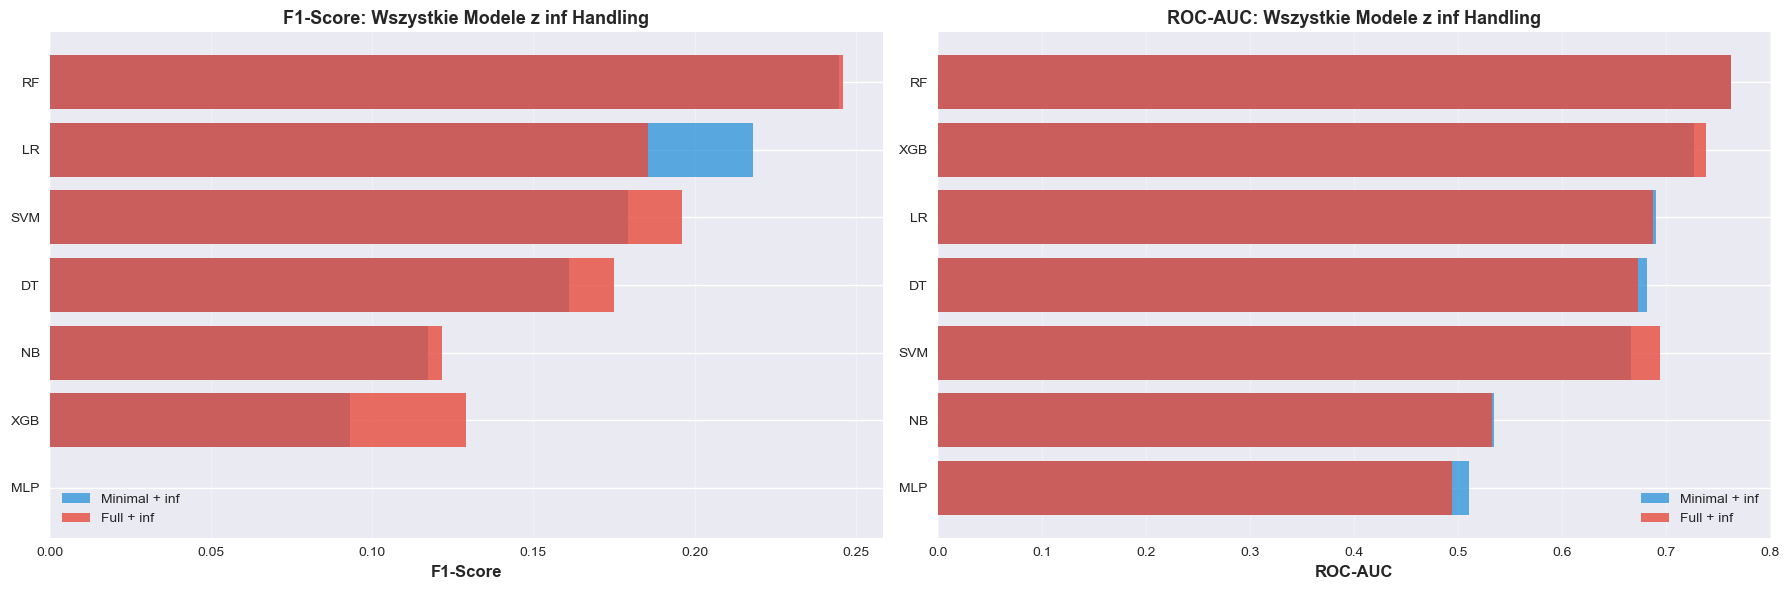


✅ WSZYSTKIE MODELE Z INF HANDLING ZAKOŃCZONE


In [158]:
print("="*100)
print("📊 PODSUMOWANIE: WSZYSTKIE MODELE Z INF HANDLING")
print("="*100)

# Tabela podsumowująca wszystkie modele z inf handling
all_inf_models = []

# Minimal Pipeline + inf handling
if 'results_minimal_inf' in dir():
    for model_name, metrics in results_minimal_inf.items():
        all_inf_models.append({
            'Pipeline': 'Minimal + inf',
            'Model': model_name,
            'Accuracy': metrics.get('accuracy', 0),
            'Precision': metrics.get('precision', 0),
            'Recall': metrics.get('recall', 0),
            'F1-Score': metrics.get('f1', 0),
            'ROC-AUC': metrics.get('roc_auc', 0)
        })

# Full Pipeline + inf handling
if 'results_full_inf' in dir():
    for model_name, metrics in results_full_inf.items():
        all_inf_models.append({
            'Pipeline': 'Full + inf',
            'Model': model_name,
            'Accuracy': metrics.get('accuracy', 0),
            'Precision': metrics.get('precision', 0),
            'Recall': metrics.get('recall', 0),
            'F1-Score': metrics.get('f1', 0),
            'ROC-AUC': metrics.get('roc_auc', 0)
        })

if len(all_inf_models) > 0:
    all_inf_df = pd.DataFrame(all_inf_models)
    all_inf_df_sorted = all_inf_df.sort_values('F1-Score', ascending=False)
    
    print("\n📋 RANKING MODELI (sortowane po F1-Score):")
    print(all_inf_df_sorted.to_string(index=False))
    
    # Najlepszy model
    best_model_inf = all_inf_df_sorted.iloc[0]
    print(f"\n🏆 NAJLEPSZY MODEL Z INF HANDLING:")
    print(f"   Pipeline: {best_model_inf['Pipeline']}")
    print(f"   Model:    {best_model_inf['Model']}")
    print(f"   F1-Score: {best_model_inf['F1-Score']:.4f}")
    print(f"   ROC-AUC:  {best_model_inf['ROC-AUC']:.4f}")
    
    # Wykres porównawczy
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot 1: F1-Score comparison
    ax1 = axes[0]
    colors_map = {'Minimal + inf': '#3498db', 'Full + inf': '#e74c3c'}
    
    for pipeline in all_inf_df['Pipeline'].unique():
        pipeline_data = all_inf_df[all_inf_df['Pipeline'] == pipeline].sort_values('F1-Score', ascending=True)
        ax1.barh(pipeline_data['Model'], pipeline_data['F1-Score'], 
                label=pipeline, alpha=0.8, color=colors_map.get(pipeline, '#95a5a6'))
    
    ax1.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
    ax1.set_title('F1-Score: Wszystkie Modele z inf Handling', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: ROC-AUC comparison
    ax2 = axes[1]
    
    for pipeline in all_inf_df['Pipeline'].unique():
        pipeline_data = all_inf_df[all_inf_df['Pipeline'] == pipeline].sort_values('ROC-AUC', ascending=True)
        ax2.barh(pipeline_data['Model'], pipeline_data['ROC-AUC'], 
                label=pipeline, alpha=0.8, color=colors_map.get(pipeline, '#95a5a6'))
    
    ax2.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
    ax2.set_title('ROC-AUC: Wszystkie Modele z inf Handling', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n⚠️ Brak wyników do podsumowania")

print("\n" + "="*100)
print("✅ WSZYSTKIE MODELE Z INF HANDLING ZAKOŃCZONE")
print("="*100)

### 24.8. Modele z Selektywną Winsoryzacją (Minimal Pipeline + inf handling)

In [160]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

print("="*100)
print("🔧 PRZYGOTOWANIE DANYCH Z SELEKTYWNĄ WINSORYZACJĄ + INF HANDLING")
print("="*100)

def apply_selective_winsorization(X, percentile_low=1, percentile_high=99):
    """
    Winsoryzacja która NIE NISZCZY informacji w kolumnach sparse/binary.
    
    Podobne podejście jak w Full Pipeline:
    - Kolumny sparse (>90% zer) → zostawiane BEZ winsoryzacji lub jako binary
    - Kolumny normalne → winsoryzacja 1-99 percentyl
    """
    X_processed = X.copy()
    winsor_report = {
        'winsorized': [],
        'preserved_sparse': [],
        'preserved_binary': []
    }
    
    for col in X_processed.columns:
        if X_processed[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            
            # Sprawdź czy kolumna jest sparse (>90% zer)
            zero_pct = (X_processed[col] == 0).sum() / len(X_processed[col])
            
            # Sprawdź czy kolumna jest binarna
            unique_vals = X_processed[col].nunique()
            
            if zero_pct > 0.9:
                # SPARSE: Nie winsoryzuj, zachowaj oryginalną informację
                winsor_report['preserved_sparse'].append(col)
                print(f"   ⚠️ {col}: SPARSE ({zero_pct*100:.1f}% zer) - BEZ winsoryzacji")
                
            elif unique_vals <= 2:
                # BINARY: Nie winsoryzuj, to flaga 0/1
                winsor_report['preserved_binary'].append(col)
                print(f"   🏴 {col}: BINARY ({unique_vals} wartości) - BEZ winsoryzacji")
                
            else:
                # NORMALNA: Zastosuj winsoryzację
                lower = np.percentile(X_processed[col], percentile_low)
                upper = np.percentile(X_processed[col], percentile_high)
                
                X_processed[col] = X_processed[col].clip(lower=lower, upper=upper)
                winsor_report['winsorized'].append(col)
    
    return X_processed, winsor_report

# Zastosuj selektywną winsoryzację na danych z obsłużonymi inf
print("\n📊 Aplikowanie selektywnej winsoryzacji...")
print("-" * 100)

if 'X_train_inf_handled' in dir() and 'X_test_inf_handled' in dir():
    # Usuń flagi inf przed winsoryzacją
    flag_cols = [col for col in X_train_inf_handled.columns if col.endswith('_had_inf')]
    
    # WAŻNE: Wybierz tylko kolumny numeryczne (bez string columns jak 'SFJIN')
    numeric_cols = X_train_inf_handled.select_dtypes(include=[np.number]).columns
    numeric_cols_no_flags = [col for col in numeric_cols if col not in flag_cols]
    
    print(f"   📊 Kolumn numerycznych (bez flag): {len(numeric_cols_no_flags)}")
    print(f"   🏴 Flag inf: {len(flag_cols)}")
    
    X_train_no_flags = X_train_inf_handled[numeric_cols_no_flags]
    X_test_no_flags = X_test_inf_handled[numeric_cols_no_flags]
    
    # Selektywna winsoryzacja
    X_train_selective_winsor, train_winsor_report = apply_selective_winsorization(
        X_train_no_flags, percentile_low=1, percentile_high=99
    )
    
    X_test_selective_winsor, test_winsor_report = apply_selective_winsorization(
        X_test_no_flags, percentile_low=1, percentile_high=99
    )
    
    print(f"\n📋 RAPORT WINSORYZACJI:")
    print(f"   Winsoryzowane:     {len(train_winsor_report['winsorized'])} kolumn")
    print(f"   Sparse (zachowane): {len(train_winsor_report['preserved_sparse'])} kolumn")
    print(f"   Binary (zachowane): {len(train_winsor_report['preserved_binary'])} kolumn")
    
    # Standaryzacja
    print(f"\n🔄 Standaryzacja...")
    scaler_selective = StandardScaler()
    X_train_selective = scaler_selective.fit_transform(X_train_selective_winsor)
    X_test_selective = scaler_selective.transform(X_test_selective_winsor)
    
    # Opcjonalnie: dodaj flagi inf z powrotem
    if len(flag_cols) > 0:
        X_train_selective = np.hstack([X_train_selective, X_train_inf_handled[flag_cols].values])
        X_test_selective = np.hstack([X_test_selective, X_test_inf_handled[flag_cols].values])
        print(f"   ✅ Dodano {len(flag_cols)} flag inf jako dodatkowe cechy")
    
    print(f"\n✅ Dane gotowe:")
    print(f"   Train shape: {X_train_selective.shape}")
    print(f"   Test shape: {X_test_selective.shape}")
    print(f"   Zawiera NaN: {np.isnan(X_train_selective).any()}")
    print(f"   Zawiera inf: {np.isinf(X_train_selective).any()}")
    
else:
    raise NameError("⚠️ Brak X_train_inf_handled. Uruchom sekcję 24.1")

# Upewnij się że nie ma NaN
if np.isnan(X_train_selective).any() or np.isnan(X_test_selective).any():
    print("\n⚠️ Znaleziono NaN - wypełniam medianą...")
    from sklearn.impute import SimpleImputer
    imputer_selective = SimpleImputer(strategy='median')
    X_train_selective = imputer_selective.fit_transform(X_train_selective)
    X_test_selective = imputer_selective.transform(X_test_selective)
    print("✅ NaN wypełnione")

results_selective = {}

print("\n" + "="*100)

🔧 PRZYGOTOWANIE DANYCH Z SELEKTYWNĄ WINSORYZACJĄ + INF HANDLING

📊 Aplikowanie selektywnej winsoryzacji...
----------------------------------------------------------------------------------------------------
   📊 Kolumn numerycznych (bez flag): 217
   🏴 Flag inf: 3
   🏴 szczegolnaFormaPrawna_Symbol: BINARY (1 wartości) - BEZ winsoryzacji
   ⚠️ Wartosc_firmy: SPARSE (99.3% zer) - BEZ winsoryzacji
   ⚠️ Naleznosci_dlugoterminowe: SPARSE (95.8% zer) - BEZ winsoryzacji
   ⚠️ Rozliczenia_miedzyokresowe_dlugie: SPARSE (93.4% zer) - BEZ winsoryzacji
   ⚠️ Naleznosci_dostaw_uslug_12m_powiazane: SPARSE (93.8% zer) - BEZ winsoryzacji
   ⚠️ Naleznosci_dostaw_uslug_pow12m_powiazane: SPARSE (99.8% zer) - BEZ winsoryzacji
   ⚠️ Naleznosci_dostaw_uslug_12m_kapitale: SPARSE (98.2% zer) - BEZ winsoryzacji
   ⚠️ Naleznosci_dostaw_uslug_pow12m_kapitale: SPARSE (99.8% zer) - BEZ winsoryzacji
   ⚠️ Naleznosci_dostaw_uslug_pow12m_pozostale: SPARSE (98.7% zer) - BEZ winsoryzacji
   ⚠️ Naleznosci_dostaw_uslug

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("="*70)
print("MODEL 1: LOGISTIC REGRESSION (Selektywna winsoryzacja + inf)")
print("="*70)

lr_selective = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_selective.fit(X_train_selective, y_train)

y_pred_lr_selective = lr_selective.predict(X_test_selective)
y_proba_lr_selective = lr_selective.predict_proba(X_test_selective)[:, 1]

results_selective['LR'] = {
    'model': lr_selective,
    'y_pred': y_pred_lr_selective,
    'y_proba': y_proba_lr_selective,
    'accuracy': accuracy_score(y_test, y_pred_lr_selective),
    'precision': precision_score(y_test, y_pred_lr_selective, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr_selective, zero_division=0),
    'f1': f1_score(y_test, y_pred_lr_selective, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_lr_selective)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_selective['LR']['accuracy']:.4f}")
print(f"  Precision: {results_selective['LR']['precision']:.4f}")
print(f"  Recall:    {results_selective['LR']['recall']:.4f}")
print(f"  F1-Score:  {results_selective['LR']['f1']:.4f}")
print(f"  ROC-AUC:   {results_selective['LR']['roc_auc']:.4f}")

print("\n✅ Logistic Regression (selektywna winsoryzacja) ukończona")

MODEL 1: LOGISTIC REGRESSION (Selektywna winsoryzacja + inf)

📊 Wyniki:
  Accuracy:  0.7967
  Precision: 0.1322
  Recall:    0.4182
  F1-Score:  0.2009
  ROC-AUC:   0.6427

✅ Logistic Regression (selektywna winsoryzacja) ukończona

📊 Wyniki:
  Accuracy:  0.7967
  Precision: 0.1322
  Recall:    0.4182
  F1-Score:  0.2009
  ROC-AUC:   0.6427

✅ Logistic Regression (selektywna winsoryzacja) ukończona


In [162]:
from sklearn.tree import DecisionTreeClassifier

print("="*70)
print("MODEL 2: DECISION TREE (Selektywna winsoryzacja + inf)")
print("="*70)

dt_selective = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42,
    class_weight='balanced'
)
dt_selective.fit(X_train_selective, y_train)

y_pred_dt_selective = dt_selective.predict(X_test_selective)
y_proba_dt_selective = dt_selective.predict_proba(X_test_selective)[:, 1]

results_selective['DT'] = {
    'model': dt_selective,
    'y_pred': y_pred_dt_selective,
    'y_proba': y_proba_dt_selective,
    'accuracy': accuracy_score(y_test, y_pred_dt_selective),
    'precision': precision_score(y_test, y_pred_dt_selective, zero_division=0),
    'recall': recall_score(y_test, y_pred_dt_selective, zero_division=0),
    'f1': f1_score(y_test, y_pred_dt_selective, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba_dt_selective)
}

print(f"\n📊 Wyniki:")
print(f"  Accuracy:  {results_selective['DT']['accuracy']:.4f}")
print(f"  Precision: {results_selective['DT']['precision']:.4f}")
print(f"  Recall:    {results_selective['DT']['recall']:.4f}")
print(f"  F1-Score:  {results_selective['DT']['f1']:.4f}")
print(f"  ROC-AUC:   {results_selective['DT']['roc_auc']:.4f}")

print("\n✅ Decision Tree (selektywna winsoryzacja) ukończone")

MODEL 2: DECISION TREE (Selektywna winsoryzacja + inf)

📊 Wyniki:
  Accuracy:  0.5833
  Precision: 0.0980
  Recall:    0.7091
  F1-Score:  0.1722
  ROC-AUC:   0.6653

✅ Decision Tree (selektywna winsoryzacja) ukończone

📊 Wyniki:
  Accuracy:  0.5833
  Precision: 0.0980
  Recall:    0.7091
  F1-Score:  0.1722
  ROC-AUC:   0.6653

✅ Decision Tree (selektywna winsoryzacja) ukończone


### 24.9. Porównanie: Standardowa vs Selektywna Winsoryzacja

📊 PORÓWNANIE: STANDARDOWA vs SELEKTYWNA WINSORYZACJA

📋 TABELA PORÓWNAWCZA:
Model                 Approach  F1-Score   Recall  Precision  ROC-AUC
   LR Standardowa winsoryzacja  0.218045 0.527273   0.137441 0.690479
   DT Standardowa winsoryzacja  0.161002 0.818182   0.089286 0.681259
   LR  Selektywna winsoryzacja  0.200873 0.418182   0.132184 0.642711
   DT  Selektywna winsoryzacja  0.172185 0.709091   0.097990 0.665272


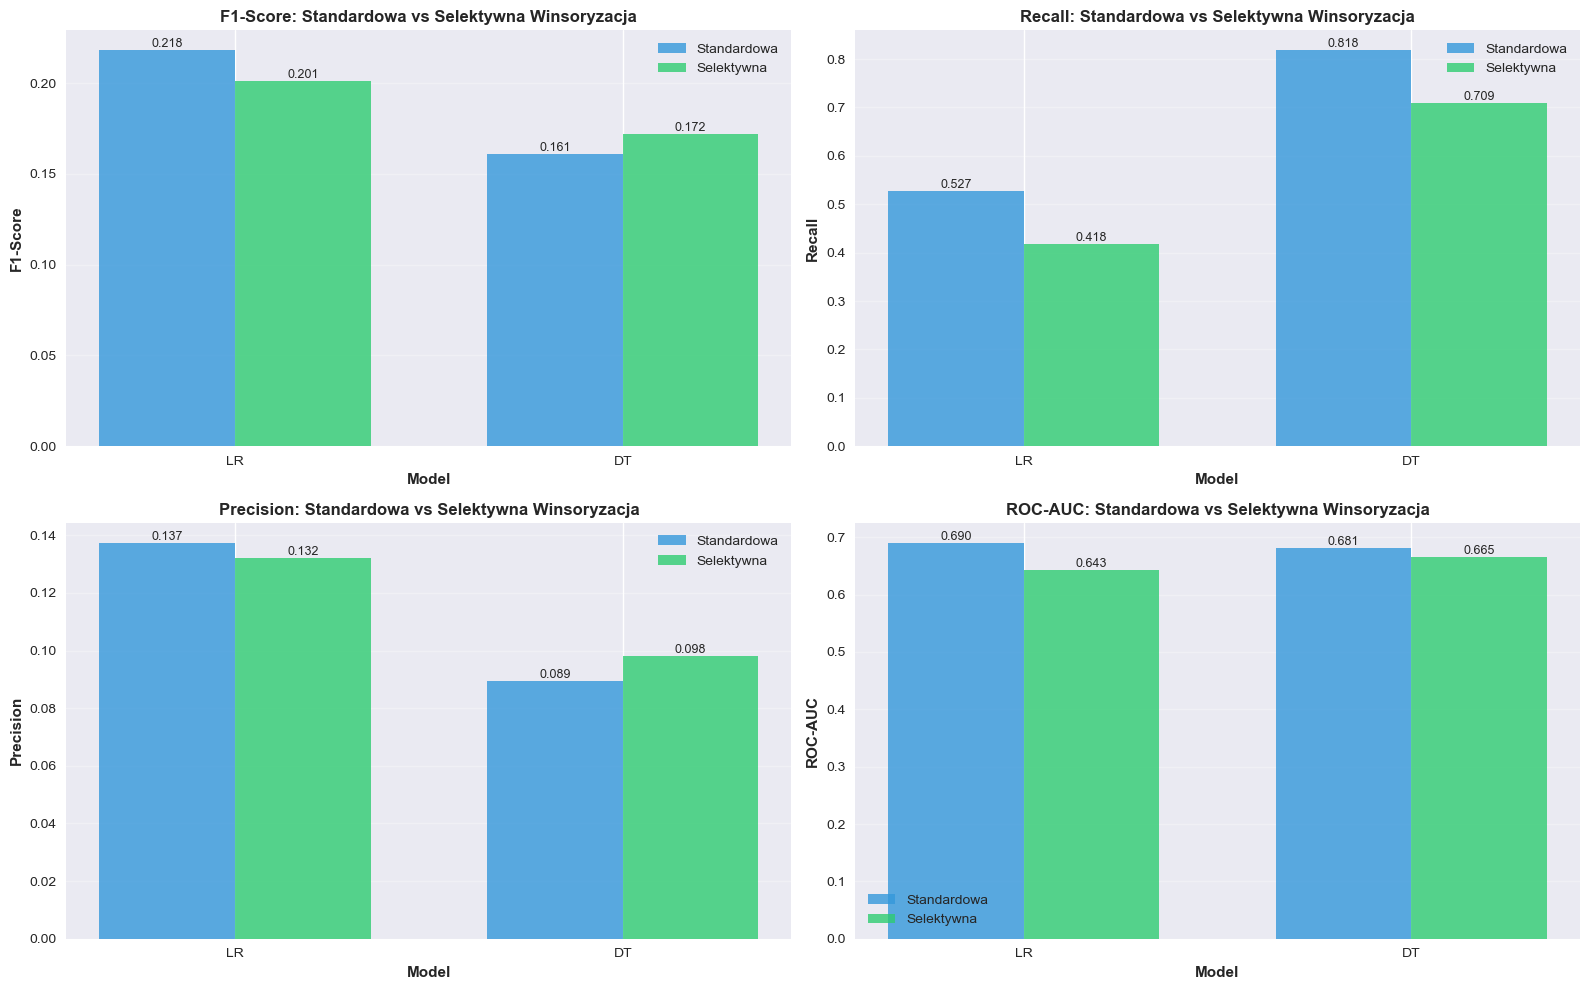


📈 ANALIZA RÓŻNIC (Selektywna - Standardowa)

📊 LR:
   F1-Score:  0.2180 → 0.2009 (-0.0172)
   Recall:    0.5273 → 0.4182 (-0.1091)
   Precision: 0.1374 → 0.1322 (-0.0053)
   ROC-AUC:   0.6905 → 0.6427 (-0.0478)
   ⚠️ POGORSZENIE - standardowa lepsza

📊 DT:
   F1-Score:  0.1610 → 0.1722 (+0.0112)
   Recall:    0.8182 → 0.7091 (-0.1091)
   Precision: 0.0893 → 0.0980 (+0.0087)
   ROC-AUC:   0.6813 → 0.6653 (-0.0160)
   ✅ POPRAWA dzięki selektywnej winsoryzacji!

💡 WYJAŚNIENIE

🔧 SELEKTYWNA WINSORYZACJA zachowuje informację w:
   • Kolumnach SPARSE (>90% zer) - nie obcina wartości niezerowych
   • Kolumnach BINARY (tylko 0/1) - nie niszczy flag
   • Flagi _had_inf - dodane jako cechy informacyjne

📊 STANDARDOWA WINSORYZACJA:
   • Obcina WSZYSTKIE kolumny (1-99 percentyl)
   • Może niszczyć informację w sparse features
   • Może spłaszczać rozkłady binarnych flag

🎯 WNIOSEK:
   Jeśli selektywna jest LEPSZA → sparse/binary features były ważne
   Jeśli standardowa jest LEPSZA → outliers były

In [163]:
import matplotlib.pyplot as plt

print("="*100)
print("📊 PORÓWNANIE: STANDARDOWA vs SELEKTYWNA WINSORYZACJA")
print("="*100)

# Porównaj z wynikami z Minimal Pipeline (standardowa winsoryzacja)
comparison_winsor_data = []

# Minimal Pipeline (standardowa winsoryzacja + inf handling)
if 'results_minimal_inf' in dir():
    for model_name in ['LR', 'DT']:
        if model_name in results_minimal_inf:
            comparison_winsor_data.append({
                'Model': model_name,
                'Approach': 'Standardowa winsoryzacja',
                'F1-Score': results_minimal_inf[model_name].get('f1', 0),
                'Recall': results_minimal_inf[model_name].get('recall', 0),
                'Precision': results_minimal_inf[model_name].get('precision', 0),
                'ROC-AUC': results_minimal_inf[model_name].get('roc_auc', 0)
            })

# Selektywna winsoryzacja
if 'results_selective' in dir():
    for model_name in ['LR', 'DT']:
        if model_name in results_selective:
            comparison_winsor_data.append({
                'Model': model_name,
                'Approach': 'Selektywna winsoryzacja',
                'F1-Score': results_selective[model_name].get('f1', 0),
                'Recall': results_selective[model_name].get('recall', 0),
                'Precision': results_selective[model_name].get('precision', 0),
                'ROC-AUC': results_selective[model_name].get('roc_auc', 0)
            })

if len(comparison_winsor_data) > 0:
    comparison_winsor_df = pd.DataFrame(comparison_winsor_data)
    
    print("\n📋 TABELA PORÓWNAWCZA:")
    print(comparison_winsor_df.to_string(index=False))
    
    # Wizualizacja
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    metrics = ['F1-Score', 'Recall', 'Precision', 'ROC-AUC']
    models = comparison_winsor_df['Model'].unique()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        x = np.arange(len(models))
        width = 0.35
        
        # Standardowa winsoryzacja
        standard_vals = []
        for model in models:
            model_data = comparison_winsor_df[(comparison_winsor_df['Model'] == model) & 
                                             (comparison_winsor_df['Approach'] == 'Standardowa winsoryzacja')]
            if len(model_data) > 0:
                standard_vals.append(model_data[metric].values[0])
            else:
                standard_vals.append(0)
        
        # Selektywna winsoryzacja
        selective_vals = []
        for model in models:
            model_data = comparison_winsor_df[(comparison_winsor_df['Model'] == model) & 
                                             (comparison_winsor_df['Approach'] == 'Selektywna winsoryzacja')]
            if len(model_data) > 0:
                selective_vals.append(model_data[metric].values[0])
            else:
                selective_vals.append(0)
        
        bars1 = ax.bar(x - width/2, standard_vals, width, label='Standardowa', alpha=0.8, color='#3498db')
        bars2 = ax.bar(x + width/2, selective_vals, width, label='Selektywna', alpha=0.8, color='#2ecc71')
        
        # Dodaj wartości
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=9)
        
        ax.set_xlabel('Model', fontsize=11, fontweight='bold')
        ax.set_ylabel(metric, fontsize=11, fontweight='bold')
        ax.set_title(f'{metric}: Standardowa vs Selektywna Winsoryzacja', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend(fontsize=10)
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analiza różnic
    print("\n" + "="*100)
    print("📈 ANALIZA RÓŻNIC (Selektywna - Standardowa)")
    print("="*100)
    
    for model in models:
        print(f"\n📊 {model}:")
        
        standard = comparison_winsor_df[(comparison_winsor_df['Model'] == model) & 
                                       (comparison_winsor_df['Approach'] == 'Standardowa winsoryzacja')]
        selective = comparison_winsor_df[(comparison_winsor_df['Model'] == model) & 
                                        (comparison_winsor_df['Approach'] == 'Selektywna winsoryzacja')]
        
        if len(standard) > 0 and len(selective) > 0:
            standard = standard.iloc[0]
            selective = selective.iloc[0]
            
            diff_f1 = selective['F1-Score'] - standard['F1-Score']
            diff_recall = selective['Recall'] - standard['Recall']
            diff_precision = selective['Precision'] - standard['Precision']
            diff_auc = selective['ROC-AUC'] - standard['ROC-AUC']
            
            print(f"   F1-Score:  {standard['F1-Score']:.4f} → {selective['F1-Score']:.4f} ({diff_f1:+.4f})")
            print(f"   Recall:    {standard['Recall']:.4f} → {selective['Recall']:.4f} ({diff_recall:+.4f})")
            print(f"   Precision: {standard['Precision']:.4f} → {selective['Precision']:.4f} ({diff_precision:+.4f})")
            print(f"   ROC-AUC:   {standard['ROC-AUC']:.4f} → {selective['ROC-AUC']:.4f} ({diff_auc:+.4f})")
            
            if diff_f1 > 0.01:
                print(f"   ✅ POPRAWA dzięki selektywnej winsoryzacji!")
            elif diff_f1 < -0.01:
                print(f"   ⚠️ POGORSZENIE - standardowa lepsza")
            else:
                print(f"   ➖ Brak znaczącej różnicy")
    
    # Wyjaśnienie
    print("\n" + "="*100)
    print("💡 WYJAŚNIENIE")
    print("="*100)
    print("""
🔧 SELEKTYWNA WINSORYZACJA zachowuje informację w:
   • Kolumnach SPARSE (>90% zer) - nie obcina wartości niezerowych
   • Kolumnach BINARY (tylko 0/1) - nie niszczy flag
   • Flagi _had_inf - dodane jako cechy informacyjne

📊 STANDARDOWA WINSORYZACJA:
   • Obcina WSZYSTKIE kolumny (1-99 percentyl)
   • Może niszczyć informację w sparse features
   • Może spłaszczać rozkłady binarnych flag

🎯 WNIOSEK:
   Jeśli selektywna jest LEPSZA → sparse/binary features były ważne
   Jeśli standardowa jest LEPSZA → outliers były problemem wszędzie
""")
    
else:
    print("\n⚠️ Brak danych do porównania")

print("\n" + "="*100)
print("✅ PORÓWNANIE ZAKOŃCZONE")
print("="*100)